## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [34]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

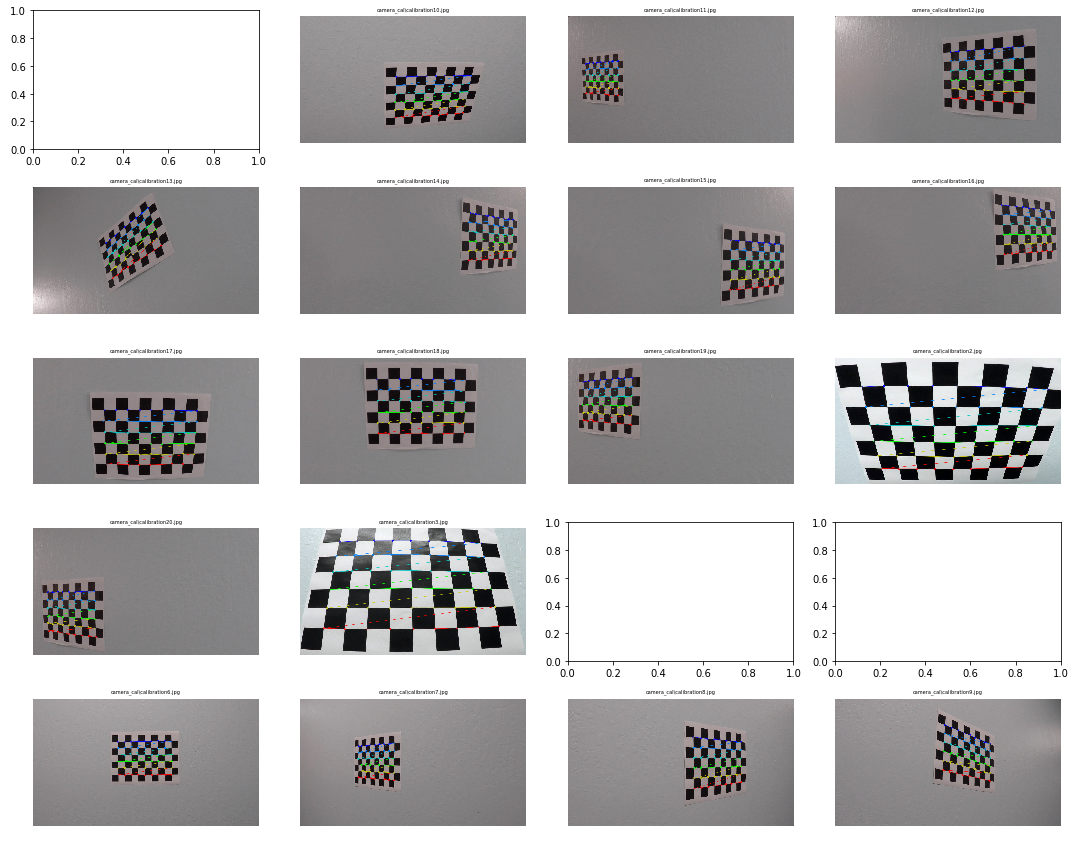

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

f, axs = plt.subplots(5,4, figsize=(15,12))
axs = np.array(axs).reshape(-1)
f.tight_layout()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].imshow(img)
        axs[i].set_title(fname, fontsize=5)
        axs[i].axis('off')
#         cv2.imshow('img',img)
#         cv2.waitKey(0)

f.savefig('output_images/chessboard_corners.png')
# cv2.destroyAllWindows()

## Undistort image

In [3]:
def undistort(img):
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # compute camera calibration matrix and distortion co-efficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    # return undistorted image
    return cv2.undistort(img, mtx, dist, None, mtx)

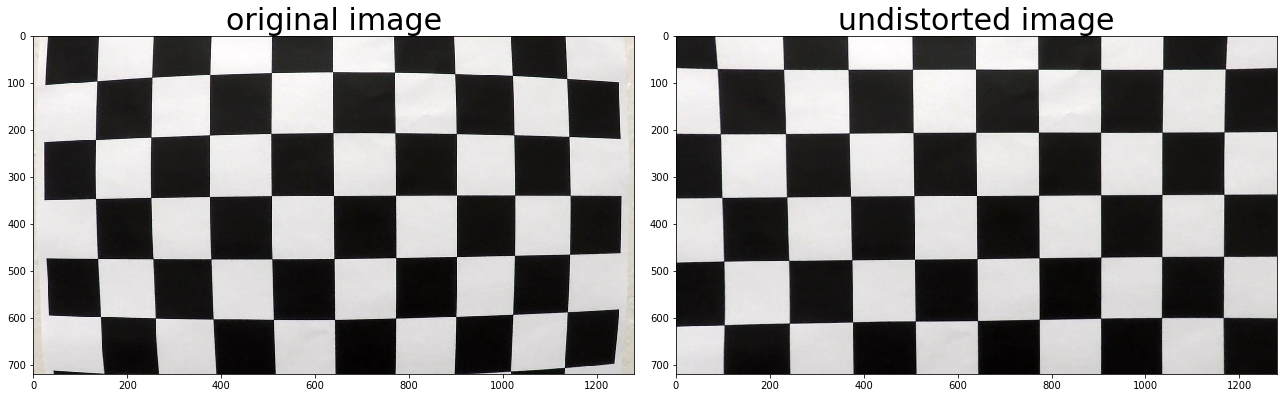

In [37]:
# undistort chessboard image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_undst = undistort(img)

f, axs = plt.subplots(1,2, figsize=(18,10))
f.tight_layout()
axs[0].imshow(img)
axs[0].set_title('original image', fontsize=30)
axs[1].imshow(img_undst)
axs[1].set_title('undistorted image', fontsize=30)
f.savefig('output_images/undistorted_chessboard.png', bbox_inches='tight', pad_inches=0)

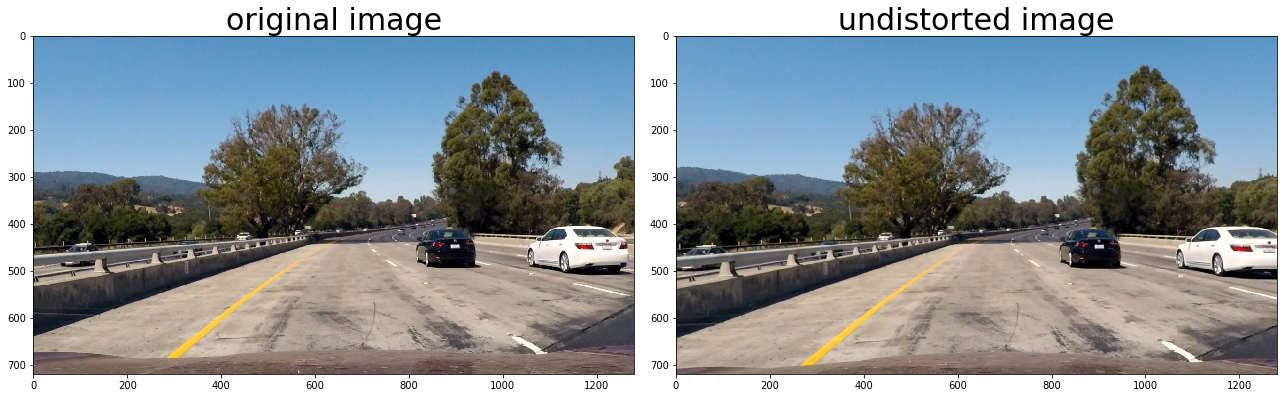

In [38]:
# undistort test image
img = mpimg.imread('test_images/test1.jpg')
img_undst = undistort(img)

f, axs = plt.subplots(1,2, figsize=(18,10))
f.tight_layout()
axs[0].imshow(img)
axs[0].set_title('original image', fontsize=30)
axs[1].imshow(img_undst)
axs[1].set_title('undistorted image', fontsize=30)
f.savefig('output_images/undistorted_test1.png', bbox_inches='tight', pad_inches=0)

## Create thresholded binary image

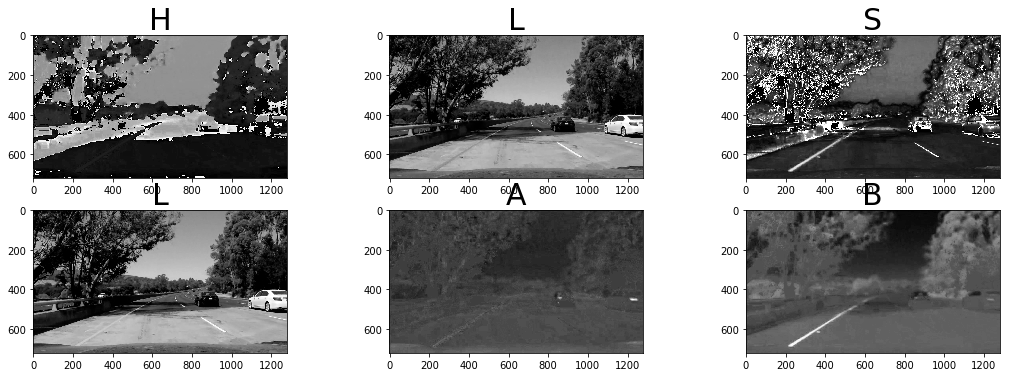

In [44]:
# exploring color spaces
img = cv2.imread('test_images/test5.jpg')
img_HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

f, axs = plt.subplots(2,3, figsize=(15,5))
f.tight_layout()
axs[0,0].imshow(img_HLS[:,:,0], cmap='gray')
axs[0,0].set_title('H', fontsize=30)
axs[0,1].imshow(img_HLS[:,:,1], cmap='gray')
axs[0,1].set_title('L', fontsize=30)
axs[0,2].imshow(img_HLS[:,:,2], cmap='gray')
axs[0,2].set_title('S', fontsize=30)

axs[1,0].imshow(img_LAB[:,:,0], cmap='gray')
axs[1,0].set_title('L', fontsize=30)
axs[1,1].imshow(img_LAB[:,:,1], cmap='gray')
axs[1,1].set_title('A', fontsize=30)
axs[1,2].imshow(img_LAB[:,:,2], cmap='gray')
axs[1,2].set_title('B', fontsize=30)

### Gradients

In [4]:
# sobel absolute, magnitude, direction gradients

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)    
        
    # Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8(255*sobel/np.max(sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # Return this mask as your grad_binary image
    grad_binary = np.zeros_like(sobel)
    grad_binary[(sobel>=thresh[0]) & (sobel<=thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel = np.uint8(255*sobel/np.max(sobel))
    
    # 5) Create a binary mask where mag thresholds are met
    mask = (sobel>=thresh[0]) & (sobel<=thresh[1])
    
    # 6) Return this mask as your binary_output image
    mag_binary = np.zeros_like(sobel)
    mag_binary[mask] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return dir_binary

### Color spaces

In [5]:
def hls_s(img, thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = img[:,:,2]
    mask = (S>thresh[0]) & (S<=thresh[1])
    binary_output = np.zeros_like(S)
    binary_output[mask] = 1
    return binary_output

def hls_h(img, thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = img[:,:,0]
    mask = (H>thresh[0]) & (H<=thresh[1])
    binary_output = np.zeros_like(H)
    binary_output[mask] = 1
    return binary_output

def hls_l(img, thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = img[:,:,1]
    mask = (L>thresh[0]) & (L<=thresh[1])
    binary_output = np.zeros_like(L)
    binary_output[mask] = 1
    return binary_output
                       
def lab_b(img, thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    B = img[:,:,2]
    mask = (B>thresh[0]) & (B<=thresh[1])
    binary_output = np.zeros_like(B)
    binary_output[mask] = 1
    return binary_output

### test thresholding

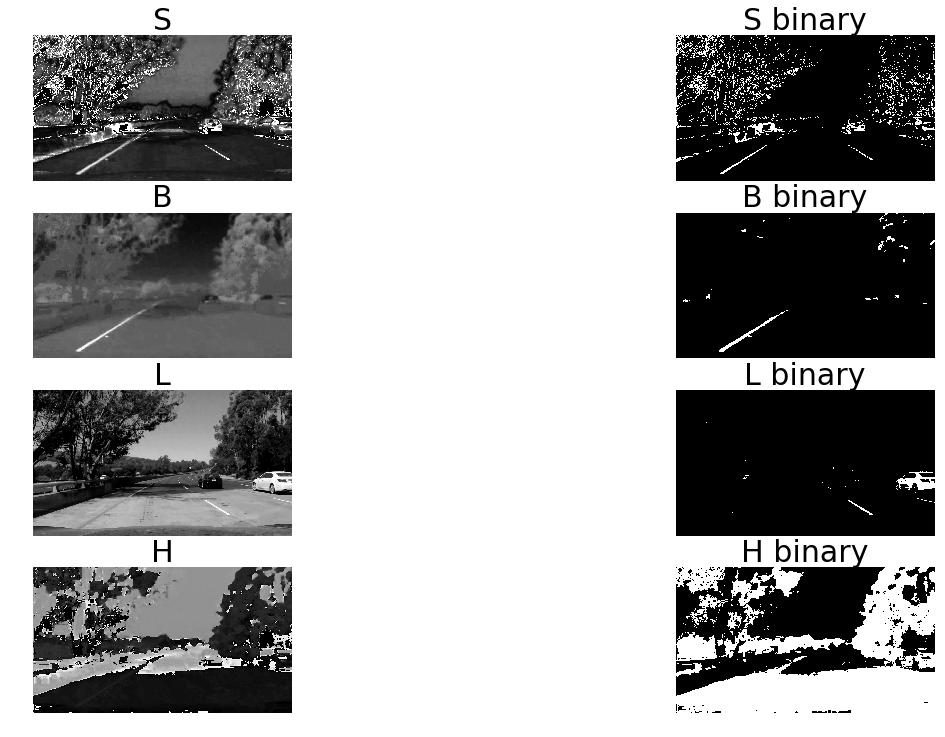

In [39]:
img = mpimg.imread('test_images/test5.jpg')
img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

hls_s_binary = hls_s(img, thresh=(180,255))
lab_b_binary = lab_b(img, thresh=(150,255))
hls_l_binary = hls_l(img, thresh=(200,255))
hls_h_binary = hls_h(img, thresh=(0,50))

f, axs = plt.subplots(4,2, figsize=(18,10))
f.tight_layout()
axs[0,0].imshow(img_HLS[:,:,2], cmap='gray')
axs[0,0].set_title('S', fontsize=30)
axs[0,0].axis('off')
axs[0,1].imshow(hls_s_binary, cmap='gray')
axs[0,1].set_title('S binary', fontsize=30)
axs[0,1].axis('off')

axs[1,0].imshow(img_LAB[:,:,2], cmap='gray')
axs[1,0].set_title('B', fontsize=30)
axs[1,0].axis('off')
axs[1,1].imshow(lab_b_binary, cmap='gray')
axs[1,1].set_title('B binary', fontsize=30)
axs[1,1].axis('off')

axs[2,0].imshow(img_HLS[:,:,1], cmap='gray')
axs[2,0].set_title('L', fontsize=30)
axs[2,0].axis('off')
axs[2,1].imshow(hls_l_binary, cmap='gray')
axs[2,1].set_title('L binary', fontsize=30)
axs[2,1].axis('off')

axs[3,0].imshow(img_HLS[:,:,0], cmap='gray')
axs[3,0].set_title('H', fontsize=30)
axs[3,0].axis('off')
axs[3,1].imshow(hls_h_binary, cmap='gray')
axs[3,1].set_title('H binary', fontsize=30)
axs[3,1].axis('off')
f.savefig('output_images/color_thresholding.jpg', bbox_inches='tight', pad_inches=0)

### Combine

In [6]:
def binary_thresh(img):
    ksize = 3
#     sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(40, 100))
#     sobely = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(40, 100))
#     dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.0))
#     mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(50, 100))
    
    hls_s_bin = hls_s(img, thresh=(180, 255))
    lab_b_bin = lab_b(img, thresh=(150, 255))
    hls_l_bin = hls_l(img, thresh=(200, 255))
    hls_h_bin = hls_h(img, thresh=(0, 50))
      
    # apply a region mask
    region_mask = np.zeros_like(hls_s_bin)
    h = img.shape[0]
    w = img.shape[1]
    vertices = np.int32([[520, 430], [760, 430], [w, h], [0, h]])
    cv2.fillPoly(region_mask, [vertices], 1)
    
    combined_binary = np.zeros_like(hls_s_bin)
#     combined_binary[(((sobelx==1) & (sobely==1)) | ((dir_binary==1) & (mag_binary==1)) | \
#                     (hls_s_bin == 1) | (lab_b_bin == 1)) \
#                     & (region_mask == 1)] = 1
#     combined_binary[(((hls_h_bin == 1) & (hls_s_bin == 1)) | (lab_b_bin == 1)) \
#                     & (region_mask == 1)] = 1
    combined_binary[((((hls_s_bin == 1) & (hls_h_bin == 1)) | (lab_b_bin == 1) | (hls_l_bin == 1)) \
                    & (region_mask == 1))] = 1
    return combined_binary
    

### binary thresholding

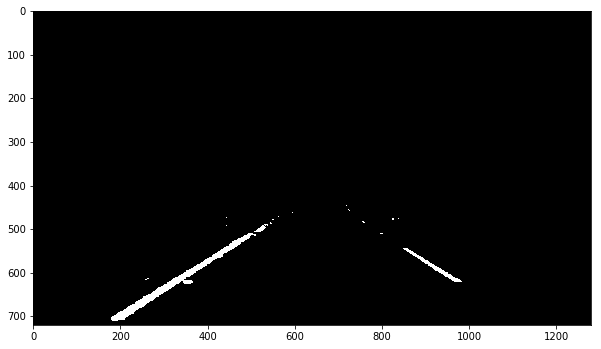

In [40]:
img = mpimg.imread('test_images/test5.jpg')
    
img = undistort(img)
    
img_binary = binary_thresh(img)

plt.figure(figsize=(10,6))
plt.imshow(img_binary, cmap='gray')
plt.imsave('output_images/binary_thresholding.jpg', img_binary, cmap='gray')

## Perspective transform

In [7]:
# # choose src points
# import matplotlib.pyplot as plt
# %matplotlib qt

# img = cv2.imread('test_images/straight_lines1.jpg')
# img = undistort(img)
# plt.imshow(img)
# cv2.waitKey(0)


-1

In [7]:
src = np.float32([[577, 462], [705, 462], [1053, 685], [254, 685]])

offset = 400
h = img.shape[0]
w = img.shape[1]
dst = np.float32([[offset, 0], [w-offset, 0], [w-offset, h], [offset, h]])

   
def perspective_transform(img, src, dst):
    h = img.shape[0]
    w = img.shape[1]
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, (w,h))
    
    return warped, M, Minv

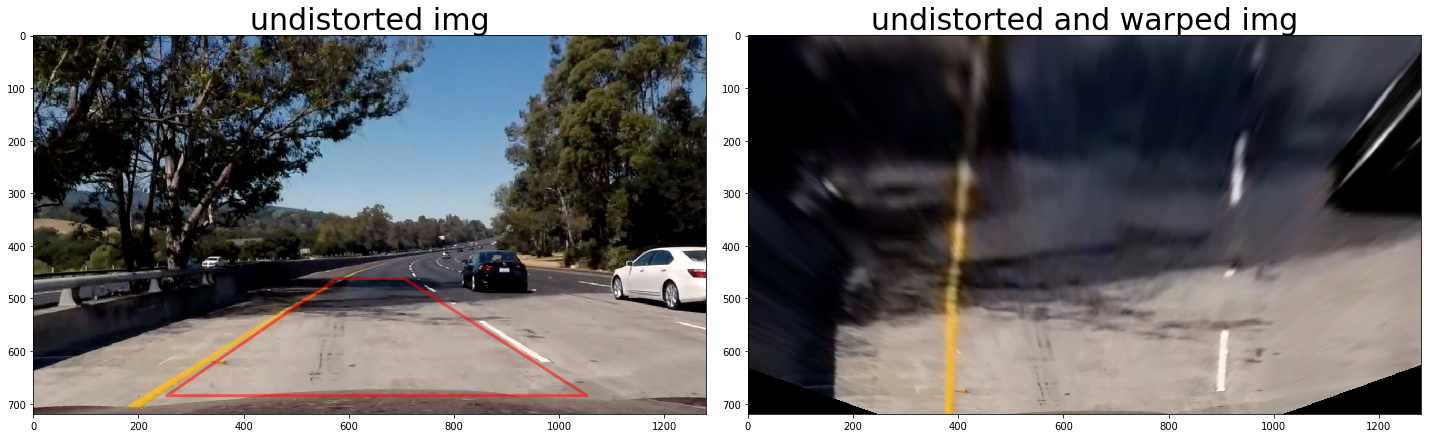

In [57]:
%matplotlib inline

img = mpimg.imread('test_images/test5.jpg')

img = undistort(img)

img_warped, M, _ = perspective_transform(img, src, dst)


f, axs = plt.subplots(1,2, figsize=(20,10))
f.tight_layout()
axs[0].imshow(img)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
axs[0].plot(x, y, color='#ff0000', alpha=0.5, linewidth=3)
axs[0].set_title('undistorted img', fontsize=30)

axs[1].imshow(img_warped)
axs[1].set_title('undistorted and warped img', fontsize=30)
f.savefig('output_images/warped.jpg')

### apply thresholding on test images

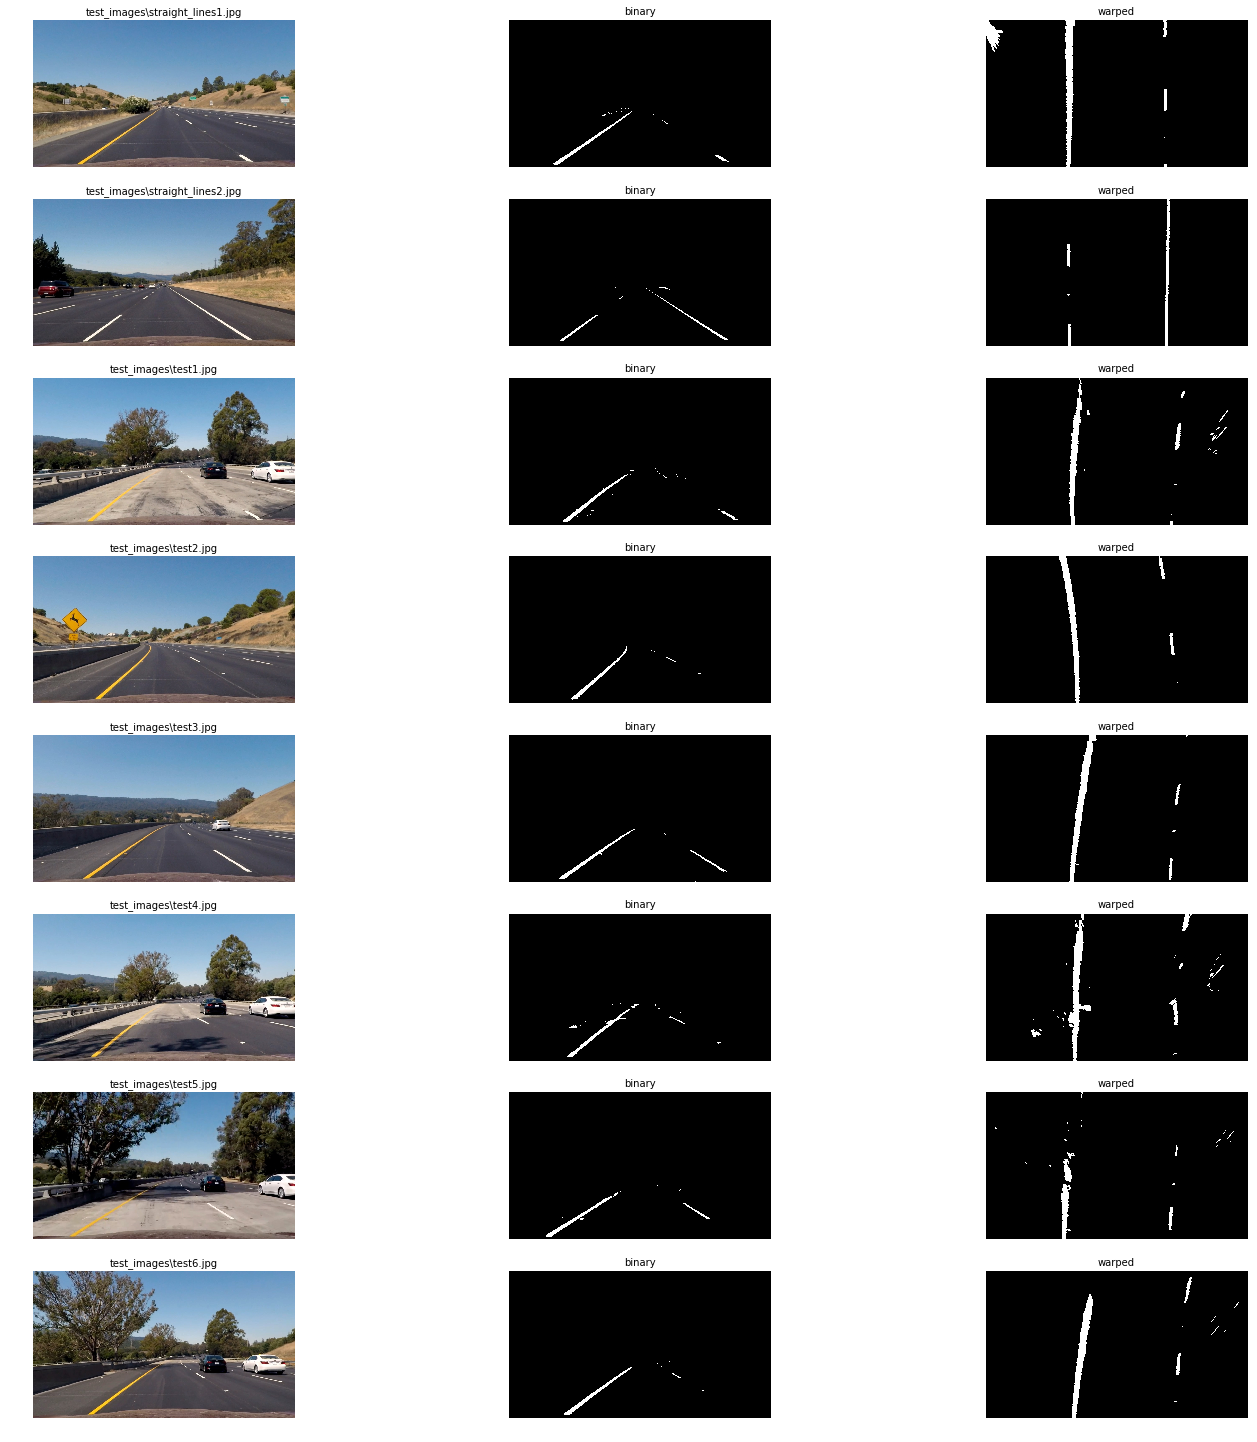

In [79]:
images = glob.glob('test_images/*.jpg')

f, axs = plt.subplots(len(images),3, figsize=(20, 20))
f.subplots_adjust(hspace = .2, wspace=.001)
f.tight_layout()
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    
    img = undistort(img)
    
    img_binary = binary_thresh(img)
    
    img_warped, M, _ = perspective_transform(img_binary, src, dst)
    
    
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(fname, fontsize=10)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(img_binary, cmap='gray')
    axs[i, 1].set_title('binary', fontsize=10)
    axs[i, 1].axis('off')
    axs[i, 2].imshow(img_warped, cmap='gray')
    axs[i, 2].set_title('warped', fontsize=10)
    axs[i, 2].axis('off')
    

## Detect lane boundary

In [8]:
def find_lanes_sliding_window(binary_warped, draw_rect=True):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_rect:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if leftx.size==0 or lefty.size==0 or rightx.size==0 or righty.size==0:
        return np.array([]), np.array([]), None, None, out_img
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
                                     
    return left_fitx, right_fitx, left_lane_inds, right_lane_inds, out_img


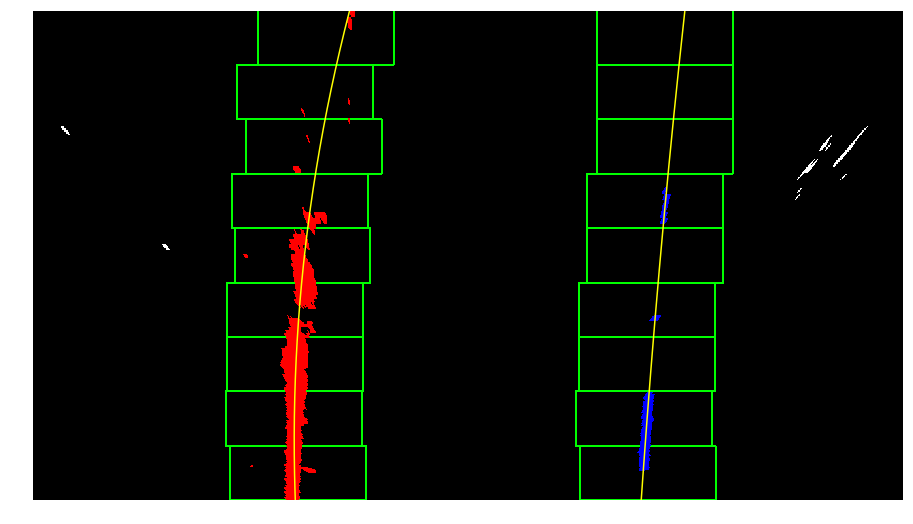

In [23]:
# sliding window on a test image

img = mpimg.imread('test_images/test5.jpg')

img = undistort(img)

img_binary = binary_thresh(img)

img_warped, M, _ = perspective_transform(img_binary, src, dst)

left_fitx, right_fitx, left_lane_inds, right_lane_inds, out_img = find_lanes_sliding_window(img_warped)

ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])
plt.figure(figsize=(16,9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.axis('off')
plt.savefig('output_images/sliding_window.jpg', bbox_inches='tight', pad_inches=0)

469.429264581
480.912380102
497.591722806
474.546801339
470.081269083
495.428801584
516.46033027
478.819127778


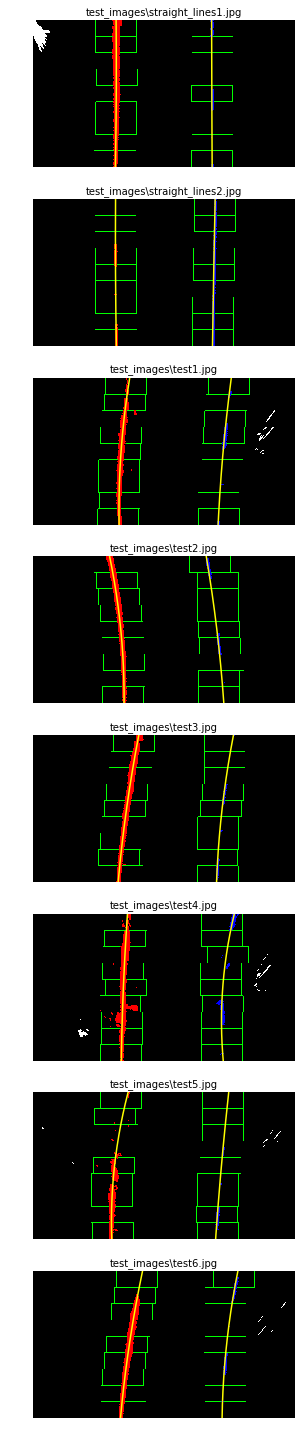

In [51]:
%matplotlib inline

images = glob.glob('test_images/*.jpg')
    
f, axs = plt.subplots(len(images),1, figsize=(20, 20))
f.tight_layout()

for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    
    img = undistort(img)

    img_binary = binary_thresh(img)

    img_warped, M, _ = perspective_transform(img_binary, src, dst)

    left_fitx, right_fitx, left_lane_inds, right_lane_inds, out_img = find_lanes_sliding_window(img_warped)
    
    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])
    
    print(np.mean(right_fitx - left_fitx))
    axs[i].imshow(out_img)
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
    axs[i].set_title(fname, fontsize=10)
    axs[i].axis('off')

# f.savefig(str(i)+'.jpg')

In [9]:
# detect the lane lines in the binary warped img within a margin of the previous fit
def find_lanes_prev_fit(binary_warped, left_fit, right_fit):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if leftx.size==0 or lefty.size==0 or rightx.size==0 or righty.size==0:
        return np.array([]), np.array([]), None, None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_lane_inds, right_lane_inds
    

In [10]:
def get_radius_curvature_center_offset(img_warped, left_lane_inds, right_lane_inds):
    
    if left_lane_inds is None or right_lane_inds is None:
        return -1, -1, -1
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/480 # meters per pixel in x dimension
    
    nonzero = img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # find the radius of curvature at the bottom of the image
    y_eval = (img_warped.shape[0] - 1) * ym_per_pix
    
    # Calculate the radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # compute offset from center
    left_bottomxm = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_bottomxm = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
#     print("leftbottom:{}, rightbottom:{}".format(left_bottomxm, right_bottomxm))
    
    # assume camera is mounted center of car
    lane_center = (right_bottomxm + left_bottomxm)/2
    vehicle_pos = img_warped.shape[1]*xm_per_pix/2
    offset = lane_center - vehicle_pos 
    
    return left_curverad, right_curverad, offset

In [11]:
def draw_lane(img_undistorted, img_warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    if left_fitx is None:
        return cv2.warpPerspective(color_warp, Minv, (img_undistorted.shape[1], img_undistorted.shape[0])) 
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_undistorted.shape[1], img_undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undistorted, 1, newwarp, 0.3, 0)
    return result
    

In [12]:
def draw_text(img, rad_curvature, pos_center):
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    txt = 'Radius of curvature: ' + '{:04.2f}'.format(rad_curvature) + 'm'
    cv2.putText(img, txt, (50,50), font, 2, (255,255,255), 2, cv2.LINE_AA)
    
    direction = 'left'
    if pos_center < 0:
        direction = 'right'
    txt = 'Vehicle is ' + '{:04.2f}'.format(np.absolute(pos_center)) + 'm ' + direction +' of center'
    cv2.putText(img, txt, (50,100), font, 2, (255,255,255), 2, cv2.LINE_AA)
    
    return img

In [13]:
# returns an undistorted, binary, warped img
def get_binary_warped_img(img):
    
    # undistort image
    img_undist = undistort(img)

    # apply binary thresholding on the undistorted image to detect lane lines
    img_binary = binary_thresh(img_undist)
    
    # warp the image to get an aerial view of the road
    warped, M, Minv = perspective_transform(img_binary, src, dst)

    return warped, img_undist, Minv

### Result of test images

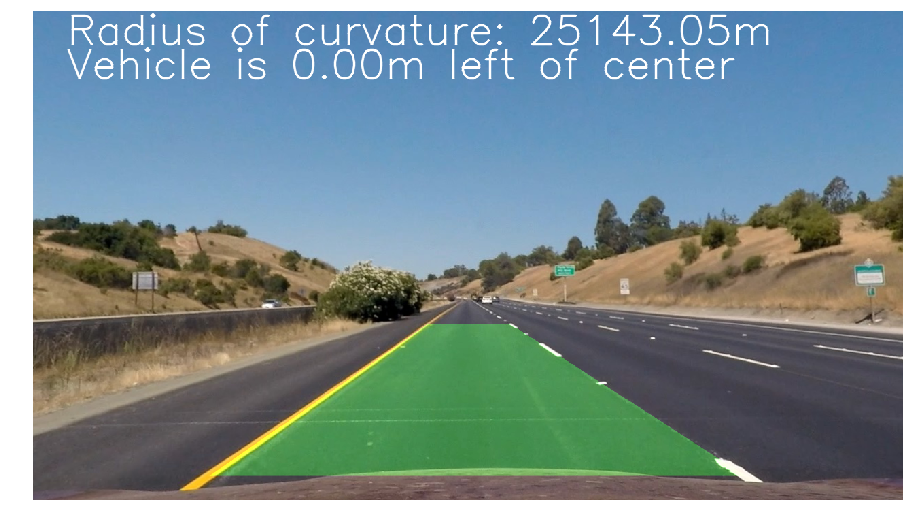

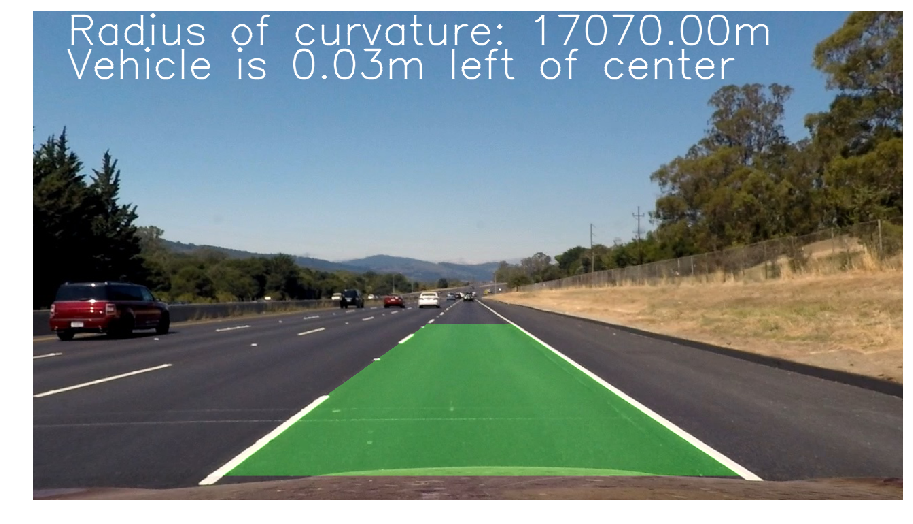

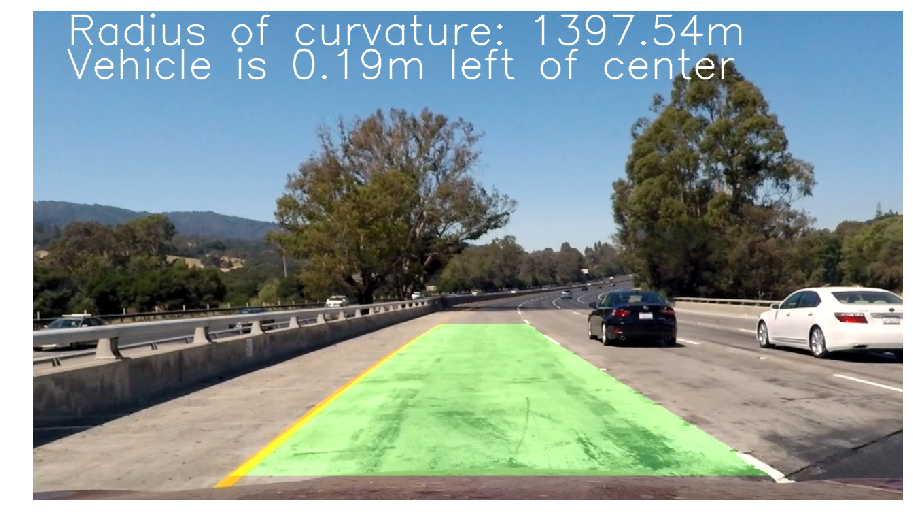

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [25]:
images = glob.glob('test_images/*.jpg')

for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    
    img_warped, img_undist, Minv = get_binary_warped_img(img)

    left_fitx, right_fitx, left_lane_inds, right_lane_inds, _ = find_lanes_sliding_window(img_warped)

    # get the radius of curvature of the lanes
    l_radius, r_radius, center_offset = get_radius_curvature_center_offset(img_warped, left_lane_inds, right_lane_inds)

    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])

    # draw the lane lines on the unwarped image
    img_result = draw_lane(img_undist, img_warped, Minv, left_fitx, right_fitx, ploty)

    # draw radius of curvature and position of vehicle
    img_result = draw_text(img_result, (l_radius+r_radius)/2, center_offset)

    plt.figure(figsize=(16,9))
    plt.imshow(img_result)
    plt.axis('off')
    plt.savefig('output_images/result_'+fname.split('\\')[1], bbox_inches='tight', pad_inches=0)


### Pipeline on the test images

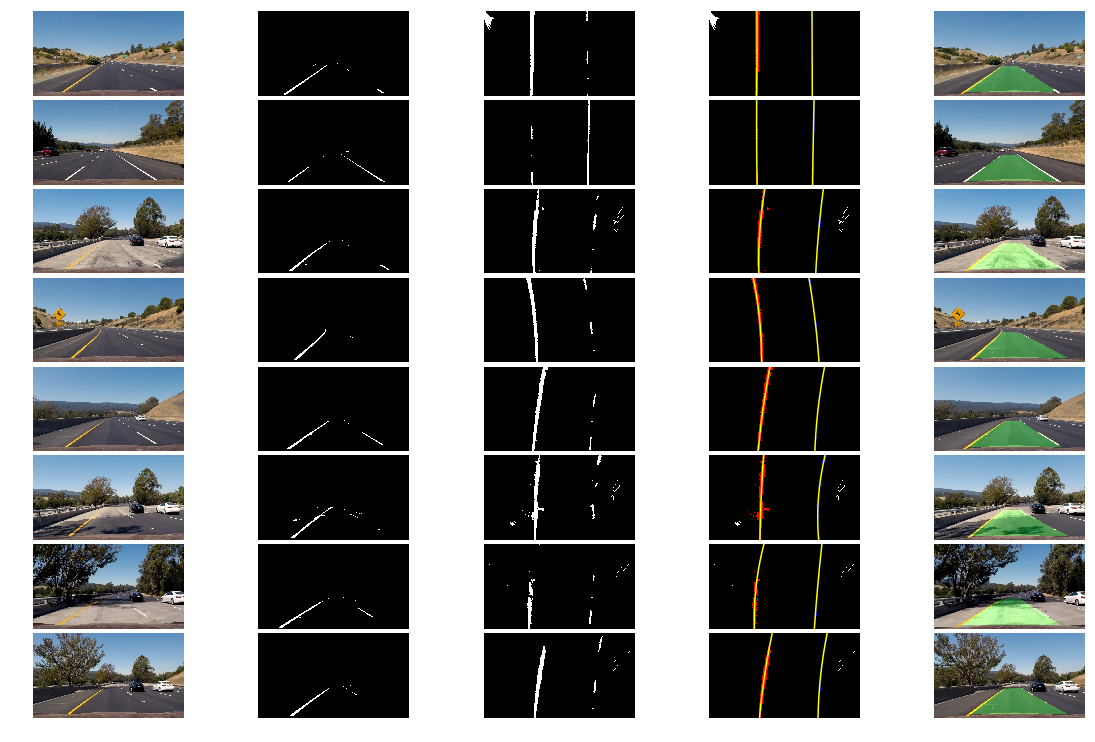

In [14]:
%matplotlib inline

images = glob.glob('test_images/*.jpg')
    
f, axs = plt.subplots(len(images),5, figsize=(20, 13))
plt.subplots_adjust(wspace=.05, hspace=.05)

for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    
    # undistort image
    img_undist = undistort(img)

    # apply binary thresholding on the undistorted image to detect lane lines
    img_binary = binary_thresh(img_undist)
    
    # warp the image to get an aerial view of the road
    img_warped, M, Minv = perspective_transform(img_binary, src, dst)

    left_fitx, right_fitx, left_lane_inds, right_lane_inds, out_img = find_lanes_sliding_window(img_warped, False)
#     print('Dist bw lanes:', np.mean(right_fitx - left_fitx))
    
    # get the radius of curvature of the lanes
    l_radius, r_radius, center_offset = get_radius_curvature_center_offset(img_warped, left_lane_inds, right_lane_inds)
#     print('Radius of curvature: ', (l_radius+r_radius)/2, 'm', '(left:',l_radius,'m',' right:',r_radius,'m')
#     print("offset:{}".format(center_offset))

    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])
        
    # draw the lane lines on the unwarped image
    img_result = draw_lane(img_undist, img_warped, Minv, left_fitx, right_fitx, ploty)
       
    axs[i, 0].imshow(img)
#     axs[i, 0].set_title(fname, fontsize=10)
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(img_binary, cmap='gray')
#     axs[i, 1].set_title('binary', fontsize=10)
    axs[i, 1].axis('off')
    
    axs[i, 2].imshow(img_warped, cmap='gray')
#     axs[i, 2].set_title('warped', fontsize=10)
    axs[i, 2].axis('off')
    
    axs[i, 3].imshow(out_img)
    axs[i, 3].plot(left_fitx, ploty, color='yellow')
    axs[i, 3].plot(right_fitx, ploty, color='yellow')
#     axs[i, 3].set_title('lane lines', fontsize=10)
    axs[i, 3].axis('off')
    
    axs[i, 4].imshow(img_result)
#     axs[i, 4].set_title('unwarped result', fontsize=10)
    axs[i, 4].axis('off')


f.savefig('output_images/result_testimgs.png', bbox_inches='tight', pad_inches=0)

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False 
        # smoothing span
        self.n_avg = 10
        # x values of the last n_avg fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None 

        self.i = 0
    
#         #polynomial coefficients for the most recent fit
#         self.current_fit = [np.array([False])] 
        
#         #radius of curvature of the line in some units
#         self.radius_of_curvature = None 
#         #distance in meters of vehicle center from the line
#         self.line_base_pos = None 
#         #difference in fit coefficients between last and new fits
#         self.diffs = np.array([0,0,0], dtype='float') 
#         #x values for detected line pixels
#         self.allx = None  
#         #y values for detected line pixels
#         self.ally = None
    
    def add(self, recent_xfitted, ploty):
        # add in line
        self.detected = True
        self.recent_xfitted.append(recent_xfitted)

        # smooth out last n fits
        # keep only n_avg values
        if len(self.recent_xfitted) > self.n_avg:
            self.recent_xfitted = self.recent_xfitted[(len(self.recent_xfitted) - self.n_avg):]
        self.bestx = np.mean(self.recent_xfitted, axis=0)

        # find polynomial co-efficients of averaged x values
        self.best_fit = np.polyfit(ploty, self.bestx, 2)

In [16]:
%matplotlib inline
def process_image(image):
    
    # get undistorted, binary thresholded, warped img
    binary_warped, img_undist, Minv = get_binary_warped_img(image)
    
    # find lanes
#     tmp_img = np.zeros_like(binary_warped).astype(np.uint8)
#     tmp_img = np.dstack((tmp_img, tmp_img, tmp_img))
    if (not l_line.detected) or (not r_line.detected):
        print('sliding window...', end=' ')
        left_fitx, right_fitx, left_lane_inds, right_lane_inds, _ = \
        find_lanes_sliding_window(binary_warped)
    else:
        print('prev fit...', end=' ')
        left_fitx, right_fitx, left_lane_inds, right_lane_inds = find_lanes_prev_fit(binary_warped, l_line.best_fit, r_line.best_fit)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        
    # the distance between the lanes should be about 480px
    dist_bw_lanes = np.mean(right_fitx - left_fitx)
    if (np.absolute(dist_bw_lanes-480) < 50) and (left_fitx.size > 0) and (right_fitx.size > 0):
        l_line.add(left_fitx, ploty)
        r_line.add(right_fitx, ploty)
    else: # use previous best fit
        print("using prev fit. dist_bw_lanes:{} left:{} right:{}".format(dist_bw_lanes, left_fitx.size, right_fitx.size), end='')
        l_line.detected = False
        r_line.detected = False
        
       
    # get the radius of curvature of the lanes
    l_radius, r_radius, center_offset = get_radius_curvature_center_offset(binary_warped, left_lane_inds, right_lane_inds)
    
    # draw the lane lines on the unwarped image
    result = draw_lane(img_undist, binary_warped, Minv, l_line.bestx, r_line.bestx, ploty)
    # draw radius of curvature and position of vehicle from center of lane
    result = draw_text(result, (l_radius+r_radius)/2, center_offset)
    
#     # debugging
#     f, axs = plt.subplots(1,3, figsize=(20, 20))
#     axs[0].imshow(binary_warped, cmap='gray')
#     axs[0].axis('off')
#     axs[1].imshow(tmp_img)
#     if (left_fitx.size > 0):
#         axs[1].plot(left_fitx, ploty, color='yellow')
#     if (right_fitx.size > 0):
#         axs[1].plot(right_fitx, ploty, color='yellow')
#     axs[1].set_xlim([0, 1280])
#     axs[1].set_ylim([720, 0])
#     axs[1].set_title(str(dist_bw_lanes), fontsize=10) 
#     axs[1].axis('off')
#     axs[2].imshow(result)
    
#     f.savefig('tmp/'+str(l_line.i)+'.jpg')
#     l_line.i +=1
    
    print('\n')
    return result

In [17]:
# # testing sliding window + finding lanes on previous fit with test images
# l_line = Line()
# r_line = Line()

# f, axs = plt.subplots(2,1, figsize=(20, 20))
# f.tight_layout()

# img = cv2.imread('test_images/test5.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# result = process_image(img)
# axs[0].imshow(result)

# img = cv2.imread('test_images/test5.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# result = process_image(img)
# axs[1].imshow(result)

## Apply lane detection to project video

In [18]:
# process project video
l_line = Line()
r_line = Line()

output = 'project_video_result.mp4'
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("project_video.mp4")
# clip_result = clip.fl_image(process_image).subclip(0,20)
clip_result = clip.fl_image(process_image)
%time clip_result.write_videofile(output, audio=False)

sliding window... 

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

prev fit... 



  0%|                                                                                 | 1/1261 [00:00<13:25,  1.56it/s]

prev fit... 



  0%|▏                                                                                | 2/1261 [00:01<13:27,  1.56it/s]

prev fit... 



  0%|▏                                                                                | 3/1261 [00:01<13:32,  1.55it/s]

prev fit... 



  0%|▎                                                                                | 4/1261 [00:02<13:48,  1.52it/s]

prev fit... 



  0%|▎                                                                                | 5/1261 [00:03<13:54,  1.50it/s]

prev fit... 



  0%|▍                                                                                | 6/1261 [00:03<13:41,  1.53it/s]

prev fit... 



  1%|▍                                                                                | 7/1261 [00:04<13:35,  1.54it/s]

prev fit... 



  1%|▌                                                                                | 8/1261 [00:05<14:00,  1.49it/s]

prev fit... 



  1%|▌                                                                                | 9/1261 [00:06<14:18,  1.46it/s]

prev fit... 



  1%|▋                                                                               | 10/1261 [00:06<14:16,  1.46it/s]

prev fit... 



  1%|▋                                                                               | 11/1261 [00:07<14:08,  1.47it/s]

prev fit... 



  1%|▊                                                                               | 12/1261 [00:07<13:44,  1.51it/s]

prev fit... 



  1%|▊                                                                               | 13/1261 [00:08<13:36,  1.53it/s]

prev fit... 



  1%|▉                                                                               | 14/1261 [00:09<13:49,  1.50it/s]

prev fit... 



  1%|▉                                                                               | 15/1261 [00:09<13:42,  1.52it/s]

prev fit... 



  1%|█                                                                               | 16/1261 [00:10<14:21,  1.44it/s]

prev fit... 



  1%|█                                                                               | 17/1261 [00:11<14:05,  1.47it/s]

prev fit... 



  1%|█▏                                                                              | 18/1261 [00:12<13:48,  1.50it/s]

prev fit... 



  2%|█▏                                                                              | 19/1261 [00:12<14:00,  1.48it/s]

prev fit... 



  2%|█▎                                                                              | 20/1261 [00:13<13:57,  1.48it/s]

prev fit... 



  2%|█▎                                                                              | 21/1261 [00:14<13:55,  1.48it/s]

prev fit... 



  2%|█▍                                                                              | 22/1261 [00:14<13:59,  1.48it/s]

prev fit... 



  2%|█▍                                                                              | 23/1261 [00:15<13:52,  1.49it/s]

prev fit... 



  2%|█▌                                                                              | 24/1261 [00:16<13:51,  1.49it/s]

prev fit... 



  2%|█▌                                                                              | 25/1261 [00:16<14:14,  1.45it/s]

prev fit... 



  2%|█▋                                                                              | 26/1261 [00:17<14:19,  1.44it/s]

prev fit... 



  2%|█▋                                                                              | 27/1261 [00:18<14:23,  1.43it/s]

prev fit... 



  2%|█▊                                                                              | 28/1261 [00:18<14:10,  1.45it/s]

prev fit... 



  2%|█▊                                                                              | 29/1261 [00:19<14:07,  1.45it/s]

prev fit... 



  2%|█▉                                                                              | 30/1261 [00:20<13:59,  1.47it/s]

prev fit... 



  2%|█▉                                                                              | 31/1261 [00:20<14:05,  1.45it/s]

prev fit... 



  3%|██                                                                              | 32/1261 [00:21<14:09,  1.45it/s]

prev fit... 



  3%|██                                                                              | 33/1261 [00:22<13:55,  1.47it/s]

prev fit... 



  3%|██▏                                                                             | 34/1261 [00:22<13:53,  1.47it/s]

prev fit... 



  3%|██▏                                                                             | 35/1261 [00:23<13:47,  1.48it/s]

prev fit... 



  3%|██▎                                                                             | 36/1261 [00:24<13:38,  1.50it/s]

prev fit... 



  3%|██▎                                                                             | 37/1261 [00:24<13:45,  1.48it/s]

prev fit... 



  3%|██▍                                                                             | 38/1261 [00:25<13:52,  1.47it/s]

prev fit... 



  3%|██▍                                                                             | 39/1261 [00:26<13:35,  1.50it/s]

prev fit... 



  3%|██▌                                                                             | 40/1261 [00:27<13:47,  1.48it/s]

prev fit... 



  3%|██▌                                                                             | 41/1261 [00:27<13:31,  1.50it/s]

prev fit... 



  3%|██▋                                                                             | 42/1261 [00:28<13:38,  1.49it/s]

prev fit... 



  3%|██▋                                                                             | 43/1261 [00:29<13:39,  1.49it/s]

prev fit... 



  3%|██▊                                                                             | 44/1261 [00:29<13:31,  1.50it/s]

prev fit... 



  4%|██▊                                                                             | 45/1261 [00:30<13:21,  1.52it/s]

prev fit... 



  4%|██▉                                                                             | 46/1261 [00:30<13:29,  1.50it/s]

prev fit... 



  4%|██▉                                                                             | 47/1261 [00:31<13:29,  1.50it/s]

prev fit... 



  4%|███                                                                             | 48/1261 [00:32<13:30,  1.50it/s]

prev fit... 



  4%|███                                                                             | 49/1261 [00:32<13:09,  1.54it/s]

prev fit... 



  4%|███▏                                                                            | 50/1261 [00:33<12:57,  1.56it/s]

prev fit... 



  4%|███▏                                                                            | 51/1261 [00:34<13:05,  1.54it/s]

prev fit... 



  4%|███▎                                                                            | 52/1261 [00:34<13:16,  1.52it/s]

prev fit... 



  4%|███▎                                                                            | 53/1261 [00:35<13:16,  1.52it/s]

prev fit... 



  4%|███▍                                                                            | 54/1261 [00:36<13:21,  1.51it/s]

prev fit... 



  4%|███▍                                                                            | 55/1261 [00:36<13:26,  1.50it/s]

prev fit... 



  4%|███▌                                                                            | 56/1261 [00:37<13:25,  1.50it/s]

prev fit... 



  5%|███▌                                                                            | 57/1261 [00:38<13:28,  1.49it/s]

prev fit... 



  5%|███▋                                                                            | 58/1261 [00:38<13:15,  1.51it/s]

prev fit... 



  5%|███▋                                                                            | 59/1261 [00:39<13:18,  1.51it/s]

prev fit... 



  5%|███▊                                                                            | 60/1261 [00:40<13:17,  1.51it/s]

prev fit... 



  5%|███▊                                                                            | 61/1261 [00:40<13:22,  1.49it/s]

prev fit... 



  5%|███▉                                                                            | 62/1261 [00:41<13:09,  1.52it/s]

prev fit... 



  5%|███▉                                                                            | 63/1261 [00:42<12:58,  1.54it/s]

prev fit... 



  5%|████                                                                            | 64/1261 [00:42<12:50,  1.55it/s]

prev fit... 



  5%|████                                                                            | 65/1261 [00:43<12:43,  1.57it/s]

prev fit... 



  5%|████▏                                                                           | 66/1261 [00:44<12:54,  1.54it/s]

prev fit... 



  5%|████▎                                                                           | 67/1261 [00:44<13:00,  1.53it/s]

prev fit... 



  5%|████▎                                                                           | 68/1261 [00:45<13:02,  1.52it/s]

prev fit... 



  5%|████▍                                                                           | 69/1261 [00:46<13:12,  1.50it/s]

prev fit... 



  6%|████▍                                                                           | 70/1261 [00:46<13:10,  1.51it/s]

prev fit... 



  6%|████▌                                                                           | 71/1261 [00:47<13:13,  1.50it/s]

prev fit... 



  6%|████▌                                                                           | 72/1261 [00:48<13:07,  1.51it/s]

prev fit... 



  6%|████▋                                                                           | 73/1261 [00:48<13:18,  1.49it/s]

prev fit... 



  6%|████▋                                                                           | 74/1261 [00:49<13:08,  1.51it/s]

prev fit... 



  6%|████▊                                                                           | 75/1261 [00:50<12:58,  1.52it/s]

prev fit... 



  6%|████▊                                                                           | 76/1261 [00:50<13:03,  1.51it/s]

prev fit... 



  6%|████▉                                                                           | 77/1261 [00:51<13:08,  1.50it/s]

prev fit... 



  6%|████▉                                                                           | 78/1261 [00:52<13:18,  1.48it/s]

prev fit... 



  6%|█████                                                                           | 79/1261 [00:52<13:11,  1.49it/s]

prev fit... 



  6%|█████                                                                           | 80/1261 [00:53<13:09,  1.50it/s]

prev fit... 



  6%|█████▏                                                                          | 81/1261 [00:54<12:58,  1.52it/s]

prev fit... 



  7%|█████▏                                                                          | 82/1261 [00:54<13:02,  1.51it/s]

prev fit... 



  7%|█████▎                                                                          | 83/1261 [00:55<13:13,  1.48it/s]

prev fit... 



  7%|█████▎                                                                          | 84/1261 [00:56<13:22,  1.47it/s]

prev fit... 



  7%|█████▍                                                                          | 85/1261 [00:56<13:37,  1.44it/s]

prev fit... 



  7%|█████▍                                                                          | 86/1261 [00:57<13:19,  1.47it/s]

prev fit... 



  7%|█████▌                                                                          | 87/1261 [00:58<13:07,  1.49it/s]

prev fit... 



  7%|█████▌                                                                          | 88/1261 [00:58<13:00,  1.50it/s]

prev fit... 



  7%|█████▋                                                                          | 89/1261 [00:59<13:08,  1.49it/s]

prev fit... 



  7%|█████▋                                                                          | 90/1261 [01:00<13:10,  1.48it/s]

prev fit... 



  7%|█████▊                                                                          | 91/1261 [01:00<13:15,  1.47it/s]

prev fit... 



  7%|█████▊                                                                          | 92/1261 [01:01<13:27,  1.45it/s]

prev fit... 



  7%|█████▉                                                                          | 93/1261 [01:02<13:05,  1.49it/s]

prev fit... 



  7%|█████▉                                                                          | 94/1261 [01:02<12:58,  1.50it/s]

prev fit... 



  8%|██████                                                                          | 95/1261 [01:03<12:47,  1.52it/s]

prev fit... 



  8%|██████                                                                          | 96/1261 [01:04<12:46,  1.52it/s]

prev fit... 



  8%|██████▏                                                                         | 97/1261 [01:04<12:44,  1.52it/s]

prev fit... 



  8%|██████▏                                                                         | 98/1261 [01:05<12:35,  1.54it/s]

prev fit... 



  8%|██████▎                                                                         | 99/1261 [01:06<12:22,  1.57it/s]

prev fit... 



  8%|██████▎                                                                        | 100/1261 [01:06<12:31,  1.55it/s]

prev fit... 



  8%|██████▎                                                                        | 101/1261 [01:07<12:29,  1.55it/s]

prev fit... 



  8%|██████▍                                                                        | 102/1261 [01:08<12:25,  1.55it/s]

prev fit... 



  8%|██████▍                                                                        | 103/1261 [01:08<12:27,  1.55it/s]

prev fit... 



  8%|██████▌                                                                        | 104/1261 [01:09<12:48,  1.51it/s]

prev fit... 



  8%|██████▌                                                                        | 105/1261 [01:10<13:02,  1.48it/s]

prev fit... 



  8%|██████▋                                                                        | 106/1261 [01:10<13:03,  1.47it/s]

prev fit... 



  8%|██████▋                                                                        | 107/1261 [01:11<12:56,  1.49it/s]

prev fit... 



  9%|██████▊                                                                        | 108/1261 [01:12<12:46,  1.50it/s]

prev fit... 



  9%|██████▊                                                                        | 109/1261 [01:12<12:44,  1.51it/s]

prev fit... 



  9%|██████▉                                                                        | 110/1261 [01:13<12:44,  1.51it/s]

prev fit... 



  9%|██████▉                                                                        | 111/1261 [01:14<12:35,  1.52it/s]

prev fit... 



  9%|███████                                                                        | 112/1261 [01:14<12:22,  1.55it/s]

prev fit... 



  9%|███████                                                                        | 113/1261 [01:15<12:36,  1.52it/s]

prev fit... 



  9%|███████▏                                                                       | 114/1261 [01:16<12:50,  1.49it/s]

prev fit... 



  9%|███████▏                                                                       | 115/1261 [01:16<13:04,  1.46it/s]

prev fit... 



  9%|███████▎                                                                       | 116/1261 [01:17<13:07,  1.45it/s]

prev fit... 



  9%|███████▎                                                                       | 117/1261 [01:18<12:47,  1.49it/s]

prev fit... 



  9%|███████▍                                                                       | 118/1261 [01:18<12:32,  1.52it/s]

prev fit... 



  9%|███████▍                                                                       | 119/1261 [01:19<12:16,  1.55it/s]

prev fit... 



 10%|███████▌                                                                       | 120/1261 [01:19<12:06,  1.57it/s]

prev fit... 



 10%|███████▌                                                                       | 121/1261 [01:20<12:18,  1.54it/s]

prev fit... 



 10%|███████▋                                                                       | 122/1261 [01:21<12:18,  1.54it/s]

prev fit... 



 10%|███████▋                                                                       | 123/1261 [01:21<12:31,  1.52it/s]

prev fit... 



 10%|███████▊                                                                       | 124/1261 [01:22<12:28,  1.52it/s]

prev fit... 



 10%|███████▊                                                                       | 125/1261 [01:23<12:14,  1.55it/s]

prev fit... 



 10%|███████▉                                                                       | 126/1261 [01:23<12:36,  1.50it/s]

prev fit... 



 10%|███████▉                                                                       | 127/1261 [01:24<12:35,  1.50it/s]

prev fit... 



 10%|████████                                                                       | 128/1261 [01:25<12:24,  1.52it/s]

prev fit... 



 10%|████████                                                                       | 129/1261 [01:25<12:26,  1.52it/s]

prev fit... 



 10%|████████▏                                                                      | 130/1261 [01:26<12:39,  1.49it/s]

prev fit... 



 10%|████████▏                                                                      | 131/1261 [01:27<12:37,  1.49it/s]

prev fit... 



 10%|████████▎                                                                      | 132/1261 [01:27<12:27,  1.51it/s]

prev fit... 



 11%|████████▎                                                                      | 133/1261 [01:28<12:36,  1.49it/s]

prev fit... 



 11%|████████▍                                                                      | 134/1261 [01:29<12:34,  1.49it/s]

prev fit... 



 11%|████████▍                                                                      | 135/1261 [01:29<12:35,  1.49it/s]

prev fit... 



 11%|████████▌                                                                      | 136/1261 [01:30<12:31,  1.50it/s]

prev fit... 



 11%|████████▌                                                                      | 137/1261 [01:31<12:48,  1.46it/s]

prev fit... 



 11%|████████▋                                                                      | 138/1261 [01:32<12:51,  1.46it/s]

prev fit... 



 11%|████████▋                                                                      | 139/1261 [01:32<12:43,  1.47it/s]

prev fit... 



 11%|████████▊                                                                      | 140/1261 [01:33<12:32,  1.49it/s]

prev fit... 



 11%|████████▊                                                                      | 141/1261 [01:34<12:27,  1.50it/s]

prev fit... 



 11%|████████▉                                                                      | 142/1261 [01:34<12:33,  1.48it/s]

prev fit... 



 11%|████████▉                                                                      | 143/1261 [01:35<12:40,  1.47it/s]

prev fit... 



 11%|█████████                                                                      | 144/1261 [01:36<12:48,  1.45it/s]

prev fit... 



 11%|█████████                                                                      | 145/1261 [01:36<12:59,  1.43it/s]

prev fit... 



 12%|█████████▏                                                                     | 146/1261 [01:37<12:54,  1.44it/s]

prev fit... 



 12%|█████████▏                                                                     | 147/1261 [01:38<12:55,  1.44it/s]

prev fit... 



 12%|█████████▎                                                                     | 148/1261 [01:38<12:48,  1.45it/s]

prev fit... 



 12%|█████████▎                                                                     | 149/1261 [01:39<12:38,  1.47it/s]

prev fit... 



 12%|█████████▍                                                                     | 150/1261 [01:40<12:34,  1.47it/s]

prev fit... 



 12%|█████████▍                                                                     | 151/1261 [01:40<12:48,  1.44it/s]

prev fit... 



 12%|█████████▌                                                                     | 152/1261 [01:41<13:06,  1.41it/s]

prev fit... 



 12%|█████████▌                                                                     | 153/1261 [01:42<13:23,  1.38it/s]

prev fit... 



 12%|█████████▋                                                                     | 154/1261 [01:43<13:08,  1.40it/s]

prev fit... 



 12%|█████████▋                                                                     | 155/1261 [01:43<12:49,  1.44it/s]

prev fit... 



 12%|█████████▊                                                                     | 156/1261 [01:44<12:38,  1.46it/s]

prev fit... 



 12%|█████████▊                                                                     | 157/1261 [01:45<12:42,  1.45it/s]

prev fit... 



 13%|█████████▉                                                                     | 158/1261 [01:45<12:39,  1.45it/s]

prev fit... 



 13%|█████████▉                                                                     | 159/1261 [01:46<12:45,  1.44it/s]

prev fit... 



 13%|██████████                                                                     | 160/1261 [01:47<12:51,  1.43it/s]

prev fit... 



 13%|██████████                                                                     | 161/1261 [01:48<13:12,  1.39it/s]

prev fit... 



 13%|██████████▏                                                                    | 162/1261 [01:48<13:04,  1.40it/s]

prev fit... 



 13%|██████████▏                                                                    | 163/1261 [01:49<12:50,  1.43it/s]

prev fit... 



 13%|██████████▎                                                                    | 164/1261 [01:50<12:56,  1.41it/s]

prev fit... 



 13%|██████████▎                                                                    | 165/1261 [01:50<13:20,  1.37it/s]

prev fit... 



 13%|██████████▍                                                                    | 166/1261 [01:51<13:16,  1.38it/s]

prev fit... 



 13%|██████████▍                                                                    | 167/1261 [01:52<12:58,  1.41it/s]

prev fit... 



 13%|██████████▌                                                                    | 168/1261 [01:52<12:34,  1.45it/s]

prev fit... 



 13%|██████████▌                                                                    | 169/1261 [01:53<12:30,  1.46it/s]

prev fit... 



 13%|██████████▋                                                                    | 170/1261 [01:54<12:26,  1.46it/s]

prev fit... 



 14%|██████████▋                                                                    | 171/1261 [01:54<12:18,  1.48it/s]

prev fit... 



 14%|██████████▊                                                                    | 172/1261 [01:55<11:55,  1.52it/s]

prev fit... 



 14%|██████████▊                                                                    | 173/1261 [01:56<11:57,  1.52it/s]

prev fit... 



 14%|██████████▉                                                                    | 174/1261 [01:56<12:04,  1.50it/s]

prev fit... 



 14%|██████████▉                                                                    | 175/1261 [01:57<12:18,  1.47it/s]

prev fit... 



 14%|███████████                                                                    | 176/1261 [01:58<12:10,  1.48it/s]

prev fit... 



 14%|███████████                                                                    | 177/1261 [01:58<12:03,  1.50it/s]

prev fit... 



 14%|███████████▏                                                                   | 178/1261 [01:59<11:59,  1.51it/s]

prev fit... 



 14%|███████████▏                                                                   | 179/1261 [02:00<12:21,  1.46it/s]

prev fit... 



 14%|███████████▎                                                                   | 180/1261 [02:01<12:31,  1.44it/s]

prev fit... 



 14%|███████████▎                                                                   | 181/1261 [02:01<12:10,  1.48it/s]

prev fit... 



 14%|███████████▍                                                                   | 182/1261 [02:02<12:04,  1.49it/s]

prev fit... 



 15%|███████████▍                                                                   | 183/1261 [02:02<11:48,  1.52it/s]

prev fit... 



 15%|███████████▌                                                                   | 184/1261 [02:03<11:55,  1.51it/s]

prev fit... 



 15%|███████████▌                                                                   | 185/1261 [02:04<12:01,  1.49it/s]

prev fit... 



 15%|███████████▋                                                                   | 186/1261 [02:05<11:54,  1.50it/s]

prev fit... 



 15%|███████████▋                                                                   | 187/1261 [02:05<11:53,  1.51it/s]

prev fit... 



 15%|███████████▊                                                                   | 188/1261 [02:06<12:01,  1.49it/s]

prev fit... 



 15%|███████████▊                                                                   | 189/1261 [02:07<12:02,  1.48it/s]

prev fit... 



 15%|███████████▉                                                                   | 190/1261 [02:07<11:58,  1.49it/s]

prev fit... 



 15%|███████████▉                                                                   | 191/1261 [02:08<11:48,  1.51it/s]

prev fit... 



 15%|████████████                                                                   | 192/1261 [02:08<11:35,  1.54it/s]

prev fit... 



 15%|████████████                                                                   | 193/1261 [02:09<11:27,  1.55it/s]

prev fit... 



 15%|████████████▏                                                                  | 194/1261 [02:10<11:48,  1.51it/s]

prev fit... 



 15%|████████████▏                                                                  | 195/1261 [02:10<11:52,  1.50it/s]

prev fit... 



 16%|████████████▎                                                                  | 196/1261 [02:11<11:33,  1.53it/s]

prev fit... 



 16%|████████████▎                                                                  | 197/1261 [02:12<11:31,  1.54it/s]

prev fit... 



 16%|████████████▍                                                                  | 198/1261 [02:12<11:31,  1.54it/s]

prev fit... 



 16%|████████████▍                                                                  | 199/1261 [02:13<11:35,  1.53it/s]

prev fit... 



 16%|████████████▌                                                                  | 200/1261 [02:14<11:38,  1.52it/s]

prev fit... 



 16%|████████████▌                                                                  | 201/1261 [02:14<11:36,  1.52it/s]

prev fit... 



 16%|████████████▋                                                                  | 202/1261 [02:15<11:29,  1.53it/s]

prev fit... 



 16%|████████████▋                                                                  | 203/1261 [02:16<11:35,  1.52it/s]

prev fit... 



 16%|████████████▊                                                                  | 204/1261 [02:16<11:25,  1.54it/s]

prev fit... 



 16%|████████████▊                                                                  | 205/1261 [02:17<11:36,  1.52it/s]

prev fit... 



 16%|████████████▉                                                                  | 206/1261 [02:18<11:45,  1.50it/s]

prev fit... 



 16%|████████████▉                                                                  | 207/1261 [02:18<11:48,  1.49it/s]

prev fit... 



 16%|█████████████                                                                  | 208/1261 [02:19<11:41,  1.50it/s]

prev fit... 



 17%|█████████████                                                                  | 209/1261 [02:20<11:44,  1.49it/s]

prev fit... 



 17%|█████████████▏                                                                 | 210/1261 [02:20<11:48,  1.48it/s]

prev fit... 



 17%|█████████████▏                                                                 | 211/1261 [02:21<11:37,  1.50it/s]

prev fit... 



 17%|█████████████▎                                                                 | 212/1261 [02:22<11:46,  1.49it/s]

prev fit... 



 17%|█████████████▎                                                                 | 213/1261 [02:22<11:42,  1.49it/s]

prev fit... 



 17%|█████████████▍                                                                 | 214/1261 [02:23<11:35,  1.51it/s]

prev fit... 



 17%|█████████████▍                                                                 | 215/1261 [02:24<11:36,  1.50it/s]

prev fit... 



 17%|█████████████▌                                                                 | 216/1261 [02:24<11:38,  1.50it/s]

prev fit... 



 17%|█████████████▌                                                                 | 217/1261 [02:25<11:42,  1.49it/s]

prev fit... 



 17%|█████████████▋                                                                 | 218/1261 [02:26<11:43,  1.48it/s]

prev fit... 



 17%|█████████████▋                                                                 | 219/1261 [02:26<11:39,  1.49it/s]

prev fit... 



 17%|█████████████▊                                                                 | 220/1261 [02:27<11:49,  1.47it/s]

prev fit... 



 18%|█████████████▊                                                                 | 221/1261 [02:28<11:51,  1.46it/s]

prev fit... 



 18%|█████████████▉                                                                 | 222/1261 [02:29<11:56,  1.45it/s]

prev fit... 



 18%|█████████████▉                                                                 | 223/1261 [02:29<11:49,  1.46it/s]

prev fit... 



 18%|██████████████                                                                 | 224/1261 [02:30<11:44,  1.47it/s]

prev fit... 



 18%|██████████████                                                                 | 225/1261 [02:31<11:40,  1.48it/s]

prev fit... 



 18%|██████████████▏                                                                | 226/1261 [02:31<11:23,  1.52it/s]

prev fit... 



 18%|██████████████▏                                                                | 227/1261 [02:32<11:23,  1.51it/s]

prev fit... 



 18%|██████████████▎                                                                | 228/1261 [02:32<11:18,  1.52it/s]

prev fit... 



 18%|██████████████▎                                                                | 229/1261 [02:33<11:18,  1.52it/s]

prev fit... 



 18%|██████████████▍                                                                | 230/1261 [02:34<11:14,  1.53it/s]

prev fit... 



 18%|██████████████▍                                                                | 231/1261 [02:34<11:19,  1.52it/s]

prev fit... 



 18%|██████████████▌                                                                | 232/1261 [02:35<11:13,  1.53it/s]

prev fit... 



 18%|██████████████▌                                                                | 233/1261 [02:36<11:28,  1.49it/s]

prev fit... 



 19%|██████████████▋                                                                | 234/1261 [02:36<11:18,  1.51it/s]

prev fit... 



 19%|██████████████▋                                                                | 235/1261 [02:37<11:36,  1.47it/s]

prev fit... 



 19%|██████████████▊                                                                | 236/1261 [02:38<11:37,  1.47it/s]

prev fit... 



 19%|██████████████▊                                                                | 237/1261 [02:38<11:33,  1.48it/s]

prev fit... 



 19%|██████████████▉                                                                | 238/1261 [02:39<11:29,  1.48it/s]

prev fit... 



 19%|██████████████▉                                                                | 239/1261 [02:40<11:17,  1.51it/s]

prev fit... 



 19%|███████████████                                                                | 240/1261 [02:40<11:18,  1.50it/s]

prev fit... 



 19%|███████████████                                                                | 241/1261 [02:41<11:16,  1.51it/s]

prev fit... 



 19%|███████████████▏                                                               | 242/1261 [02:42<11:21,  1.50it/s]

prev fit... 



 19%|███████████████▏                                                               | 243/1261 [02:42<11:16,  1.51it/s]

prev fit... 



 19%|███████████████▎                                                               | 244/1261 [02:43<11:15,  1.51it/s]

prev fit... 



 19%|███████████████▎                                                               | 245/1261 [02:44<11:06,  1.53it/s]

prev fit... 



 20%|███████████████▍                                                               | 246/1261 [02:44<11:01,  1.53it/s]

prev fit... 



 20%|███████████████▍                                                               | 247/1261 [02:45<11:00,  1.53it/s]

prev fit... 



 20%|███████████████▌                                                               | 248/1261 [02:46<11:08,  1.52it/s]

prev fit... 



 20%|███████████████▌                                                               | 249/1261 [02:46<11:18,  1.49it/s]

prev fit... 



 20%|███████████████▋                                                               | 250/1261 [02:47<11:12,  1.50it/s]

prev fit... 



 20%|███████████████▋                                                               | 251/1261 [02:48<10:57,  1.54it/s]

prev fit... 



 20%|███████████████▊                                                               | 252/1261 [02:48<11:02,  1.52it/s]

prev fit... 



 20%|███████████████▊                                                               | 253/1261 [02:49<10:59,  1.53it/s]

prev fit... 



 20%|███████████████▉                                                               | 254/1261 [02:50<11:04,  1.51it/s]

prev fit... 



 20%|███████████████▉                                                               | 255/1261 [02:50<10:58,  1.53it/s]

prev fit... 



 20%|████████████████                                                               | 256/1261 [02:51<10:46,  1.55it/s]

prev fit... 



 20%|████████████████                                                               | 257/1261 [02:52<10:42,  1.56it/s]

prev fit... 



 20%|████████████████▏                                                              | 258/1261 [02:52<10:41,  1.56it/s]

prev fit... 



 21%|████████████████▏                                                              | 259/1261 [02:53<10:39,  1.57it/s]

prev fit... 



 21%|████████████████▎                                                              | 260/1261 [02:54<11:02,  1.51it/s]

prev fit... 



 21%|████████████████▎                                                              | 261/1261 [02:54<11:06,  1.50it/s]

prev fit... 



 21%|████████████████▍                                                              | 262/1261 [02:55<11:18,  1.47it/s]

prev fit... 



 21%|████████████████▍                                                              | 263/1261 [02:56<11:23,  1.46it/s]

prev fit... 



 21%|████████████████▌                                                              | 264/1261 [02:56<11:23,  1.46it/s]

prev fit... 



 21%|████████████████▌                                                              | 265/1261 [02:57<11:25,  1.45it/s]

prev fit... 



 21%|████████████████▋                                                              | 266/1261 [02:58<11:07,  1.49it/s]

prev fit... 



 21%|████████████████▋                                                              | 267/1261 [02:58<11:02,  1.50it/s]

prev fit... 



 21%|████████████████▊                                                              | 268/1261 [02:59<10:59,  1.51it/s]

prev fit... 



 21%|████████████████▊                                                              | 269/1261 [03:00<11:06,  1.49it/s]

prev fit... 



 21%|████████████████▉                                                              | 270/1261 [03:00<11:02,  1.50it/s]

prev fit... 



 21%|████████████████▉                                                              | 271/1261 [03:01<11:04,  1.49it/s]

prev fit... 



 22%|█████████████████                                                              | 272/1261 [03:02<10:57,  1.50it/s]

prev fit... 



 22%|█████████████████                                                              | 273/1261 [03:02<10:48,  1.52it/s]

prev fit... 



 22%|█████████████████▏                                                             | 274/1261 [03:03<10:52,  1.51it/s]

prev fit... 



 22%|█████████████████▏                                                             | 275/1261 [03:04<10:56,  1.50it/s]

prev fit... 



 22%|█████████████████▎                                                             | 276/1261 [03:04<10:50,  1.51it/s]

prev fit... 



 22%|█████████████████▎                                                             | 277/1261 [03:05<10:43,  1.53it/s]

prev fit... 



 22%|█████████████████▍                                                             | 278/1261 [03:06<10:46,  1.52it/s]

prev fit... 



 22%|█████████████████▍                                                             | 279/1261 [03:06<10:52,  1.51it/s]

prev fit... 



 22%|█████████████████▌                                                             | 280/1261 [03:07<10:56,  1.49it/s]

prev fit... 



 22%|█████████████████▌                                                             | 281/1261 [03:08<11:16,  1.45it/s]

prev fit... 



 22%|█████████████████▋                                                             | 282/1261 [03:08<11:01,  1.48it/s]

prev fit... 



 22%|█████████████████▋                                                             | 283/1261 [03:09<10:58,  1.48it/s]

prev fit... 



 23%|█████████████████▊                                                             | 284/1261 [03:10<11:05,  1.47it/s]

prev fit... 



 23%|█████████████████▊                                                             | 285/1261 [03:10<11:08,  1.46it/s]

prev fit... 



 23%|█████████████████▉                                                             | 286/1261 [03:11<11:09,  1.46it/s]

prev fit... 



 23%|█████████████████▉                                                             | 287/1261 [03:12<11:20,  1.43it/s]

prev fit... 



 23%|██████████████████                                                             | 288/1261 [03:13<11:15,  1.44it/s]

prev fit... 



 23%|██████████████████                                                             | 289/1261 [03:13<11:15,  1.44it/s]

prev fit... 



 23%|██████████████████▏                                                            | 290/1261 [03:14<11:07,  1.45it/s]

prev fit... 



 23%|██████████████████▏                                                            | 291/1261 [03:15<11:03,  1.46it/s]

prev fit... 



 23%|██████████████████▎                                                            | 292/1261 [03:15<10:55,  1.48it/s]

prev fit... 



 23%|██████████████████▎                                                            | 293/1261 [03:16<10:43,  1.50it/s]

prev fit... 



 23%|██████████████████▍                                                            | 294/1261 [03:17<10:56,  1.47it/s]

prev fit... 



 23%|██████████████████▍                                                            | 295/1261 [03:17<10:55,  1.47it/s]

prev fit... 



 23%|██████████████████▌                                                            | 296/1261 [03:18<10:49,  1.49it/s]

prev fit... 



 24%|██████████████████▌                                                            | 297/1261 [03:19<10:45,  1.49it/s]

prev fit... 



 24%|██████████████████▋                                                            | 298/1261 [03:19<10:38,  1.51it/s]

prev fit... 



 24%|██████████████████▋                                                            | 299/1261 [03:20<10:37,  1.51it/s]

prev fit... 



 24%|██████████████████▊                                                            | 300/1261 [03:21<10:49,  1.48it/s]

prev fit... 



 24%|██████████████████▊                                                            | 301/1261 [03:21<10:50,  1.48it/s]

prev fit... 



 24%|██████████████████▉                                                            | 302/1261 [03:22<10:55,  1.46it/s]

prev fit... 



 24%|██████████████████▉                                                            | 303/1261 [03:23<10:57,  1.46it/s]

prev fit... 



 24%|███████████████████                                                            | 304/1261 [03:23<10:47,  1.48it/s]

prev fit... 



 24%|███████████████████                                                            | 305/1261 [03:24<11:31,  1.38it/s]

prev fit... 



 24%|███████████████████▏                                                           | 306/1261 [03:25<11:15,  1.41it/s]

prev fit... 



 24%|███████████████████▏                                                           | 307/1261 [03:25<11:07,  1.43it/s]

prev fit... 



 24%|███████████████████▎                                                           | 308/1261 [03:26<10:59,  1.44it/s]

prev fit... 



 25%|███████████████████▎                                                           | 309/1261 [03:27<11:10,  1.42it/s]

prev fit... 



 25%|███████████████████▍                                                           | 310/1261 [03:28<11:29,  1.38it/s]

prev fit... 



 25%|███████████████████▍                                                           | 311/1261 [03:28<11:01,  1.44it/s]

prev fit... 



 25%|███████████████████▌                                                           | 312/1261 [03:29<10:46,  1.47it/s]

prev fit... 



 25%|███████████████████▌                                                           | 313/1261 [03:30<10:54,  1.45it/s]

prev fit... 



 25%|███████████████████▋                                                           | 314/1261 [03:30<11:12,  1.41it/s]

prev fit... 



 25%|███████████████████▋                                                           | 315/1261 [03:31<11:05,  1.42it/s]

prev fit... 



 25%|███████████████████▊                                                           | 316/1261 [03:32<11:02,  1.43it/s]

prev fit... 



 25%|███████████████████▊                                                           | 317/1261 [03:32<10:47,  1.46it/s]

prev fit... 



 25%|███████████████████▉                                                           | 318/1261 [03:33<10:33,  1.49it/s]

prev fit... 



 25%|███████████████████▉                                                           | 319/1261 [03:34<10:27,  1.50it/s]

prev fit... 



 25%|████████████████████                                                           | 320/1261 [03:34<10:27,  1.50it/s]

prev fit... 



 25%|████████████████████                                                           | 321/1261 [03:35<10:18,  1.52it/s]

prev fit... 



 26%|████████████████████▏                                                          | 322/1261 [03:36<10:11,  1.54it/s]

prev fit... 



 26%|████████████████████▏                                                          | 323/1261 [03:36<10:11,  1.53it/s]

prev fit... 



 26%|████████████████████▎                                                          | 324/1261 [03:37<10:23,  1.50it/s]

prev fit... 



 26%|████████████████████▎                                                          | 325/1261 [03:38<10:35,  1.47it/s]

prev fit... 



 26%|████████████████████▍                                                          | 326/1261 [03:38<10:36,  1.47it/s]

prev fit... 



 26%|████████████████████▍                                                          | 327/1261 [03:39<10:32,  1.48it/s]

prev fit... 



 26%|████████████████████▌                                                          | 328/1261 [03:40<10:40,  1.46it/s]

prev fit... 



 26%|████████████████████▌                                                          | 329/1261 [03:40<10:27,  1.48it/s]

prev fit... 



 26%|████████████████████▋                                                          | 330/1261 [03:41<10:22,  1.50it/s]

prev fit... 



 26%|████████████████████▋                                                          | 331/1261 [03:42<10:20,  1.50it/s]

prev fit... 



 26%|████████████████████▊                                                          | 332/1261 [03:42<10:16,  1.51it/s]

prev fit... 



 26%|████████████████████▊                                                          | 333/1261 [03:43<10:17,  1.50it/s]

prev fit... 



 26%|████████████████████▉                                                          | 334/1261 [03:44<10:08,  1.52it/s]

prev fit... 



 27%|████████████████████▉                                                          | 335/1261 [03:44<10:05,  1.53it/s]

prev fit... 



 27%|█████████████████████                                                          | 336/1261 [03:45<09:51,  1.56it/s]

prev fit... 



 27%|█████████████████████                                                          | 337/1261 [03:46<09:49,  1.57it/s]

prev fit... 



 27%|█████████████████████▏                                                         | 338/1261 [03:46<09:47,  1.57it/s]

prev fit... 



 27%|█████████████████████▏                                                         | 339/1261 [03:47<09:46,  1.57it/s]

prev fit... 



 27%|█████████████████████▎                                                         | 340/1261 [03:48<09:51,  1.56it/s]

prev fit... 



 27%|█████████████████████▎                                                         | 341/1261 [03:48<09:52,  1.55it/s]

prev fit... 



 27%|█████████████████████▍                                                         | 342/1261 [03:49<10:03,  1.52it/s]

prev fit... 



 27%|█████████████████████▍                                                         | 343/1261 [03:50<09:59,  1.53it/s]

prev fit... 



 27%|█████████████████████▌                                                         | 344/1261 [03:50<10:00,  1.53it/s]

prev fit... 



 27%|█████████████████████▌                                                         | 345/1261 [03:51<10:08,  1.50it/s]

prev fit... 



 27%|█████████████████████▋                                                         | 346/1261 [03:52<10:12,  1.49it/s]

prev fit... 



 28%|█████████████████████▋                                                         | 347/1261 [03:52<10:20,  1.47it/s]

prev fit... 



 28%|█████████████████████▊                                                         | 348/1261 [03:53<10:16,  1.48it/s]

prev fit... 



 28%|█████████████████████▊                                                         | 349/1261 [03:54<10:19,  1.47it/s]

prev fit... 



 28%|█████████████████████▉                                                         | 350/1261 [03:54<10:12,  1.49it/s]

prev fit... 



 28%|█████████████████████▉                                                         | 351/1261 [03:55<10:21,  1.46it/s]

prev fit... 



 28%|██████████████████████                                                         | 352/1261 [03:56<10:20,  1.46it/s]

prev fit... 



 28%|██████████████████████                                                         | 353/1261 [03:56<10:17,  1.47it/s]

prev fit... 



 28%|██████████████████████▏                                                        | 354/1261 [03:57<10:16,  1.47it/s]

prev fit... 



 28%|██████████████████████▏                                                        | 355/1261 [03:58<10:12,  1.48it/s]

prev fit... 



 28%|██████████████████████▎                                                        | 356/1261 [03:58<10:04,  1.50it/s]

prev fit... 



 28%|██████████████████████▎                                                        | 357/1261 [03:59<09:55,  1.52it/s]

prev fit... 



 28%|██████████████████████▍                                                        | 358/1261 [04:00<09:53,  1.52it/s]

prev fit... 



 28%|██████████████████████▍                                                        | 359/1261 [04:00<09:59,  1.51it/s]

prev fit... 



 29%|██████████████████████▌                                                        | 360/1261 [04:01<10:02,  1.50it/s]

prev fit... 



 29%|██████████████████████▌                                                        | 361/1261 [04:02<10:05,  1.49it/s]

prev fit... 



 29%|██████████████████████▋                                                        | 362/1261 [04:02<10:00,  1.50it/s]

prev fit... 



 29%|██████████████████████▋                                                        | 363/1261 [04:03<09:48,  1.53it/s]

prev fit... 



 29%|██████████████████████▊                                                        | 364/1261 [04:04<09:59,  1.50it/s]

prev fit... 



 29%|██████████████████████▊                                                        | 365/1261 [04:04<09:59,  1.49it/s]

prev fit... 



 29%|██████████████████████▉                                                        | 366/1261 [04:05<09:56,  1.50it/s]

prev fit... 



 29%|██████████████████████▉                                                        | 367/1261 [04:06<10:00,  1.49it/s]

prev fit... 



 29%|███████████████████████                                                        | 368/1261 [04:06<09:54,  1.50it/s]

prev fit... 



 29%|███████████████████████                                                        | 369/1261 [04:07<09:46,  1.52it/s]

prev fit... 



 29%|███████████████████████▏                                                       | 370/1261 [04:08<09:38,  1.54it/s]

prev fit... 



 29%|███████████████████████▏                                                       | 371/1261 [04:08<09:49,  1.51it/s]

prev fit... 



 30%|███████████████████████▎                                                       | 372/1261 [04:09<09:49,  1.51it/s]

prev fit... 



 30%|███████████████████████▎                                                       | 373/1261 [04:10<09:51,  1.50it/s]

prev fit... 



 30%|███████████████████████▍                                                       | 374/1261 [04:10<09:52,  1.50it/s]

prev fit... 



 30%|███████████████████████▍                                                       | 375/1261 [04:11<09:55,  1.49it/s]

prev fit... 



 30%|███████████████████████▌                                                       | 376/1261 [04:12<09:54,  1.49it/s]

prev fit... 



 30%|███████████████████████▌                                                       | 377/1261 [04:12<10:00,  1.47it/s]

prev fit... 



 30%|███████████████████████▋                                                       | 378/1261 [04:13<09:54,  1.49it/s]

prev fit... 



 30%|███████████████████████▋                                                       | 379/1261 [04:14<09:42,  1.51it/s]

prev fit... 



 30%|███████████████████████▊                                                       | 380/1261 [04:14<09:47,  1.50it/s]

prev fit... 



 30%|███████████████████████▊                                                       | 381/1261 [04:15<09:45,  1.50it/s]

prev fit... 



 30%|███████████████████████▉                                                       | 382/1261 [04:16<09:56,  1.47it/s]

prev fit... 



 30%|███████████████████████▉                                                       | 383/1261 [04:16<10:03,  1.45it/s]

prev fit... 



 30%|████████████████████████                                                       | 384/1261 [04:17<10:04,  1.45it/s]

prev fit... 



 31%|████████████████████████                                                       | 385/1261 [04:18<09:59,  1.46it/s]

prev fit... 



 31%|████████████████████████▏                                                      | 386/1261 [04:18<10:09,  1.43it/s]

prev fit... 



 31%|████████████████████████▏                                                      | 387/1261 [04:19<10:01,  1.45it/s]

prev fit... 



 31%|████████████████████████▎                                                      | 388/1261 [04:20<09:51,  1.48it/s]

prev fit... 



 31%|████████████████████████▎                                                      | 389/1261 [04:20<09:50,  1.48it/s]

prev fit... 



 31%|████████████████████████▍                                                      | 390/1261 [04:21<09:45,  1.49it/s]

prev fit... 



 31%|████████████████████████▍                                                      | 391/1261 [04:22<09:39,  1.50it/s]

prev fit... 



 31%|████████████████████████▌                                                      | 392/1261 [04:22<09:42,  1.49it/s]

prev fit... 



 31%|████████████████████████▌                                                      | 393/1261 [04:23<09:46,  1.48it/s]

prev fit... 



 31%|████████████████████████▋                                                      | 394/1261 [04:24<09:44,  1.48it/s]

prev fit... 



 31%|████████████████████████▋                                                      | 395/1261 [04:24<09:43,  1.48it/s]

prev fit... 



 31%|████████████████████████▊                                                      | 396/1261 [04:25<09:41,  1.49it/s]

prev fit... 



 31%|████████████████████████▊                                                      | 397/1261 [04:26<09:33,  1.51it/s]

prev fit... 



 32%|████████████████████████▉                                                      | 398/1261 [04:27<09:45,  1.47it/s]

prev fit... 



 32%|████████████████████████▉                                                      | 399/1261 [04:27<09:39,  1.49it/s]

prev fit... 



 32%|█████████████████████████                                                      | 400/1261 [04:28<09:35,  1.50it/s]

prev fit... 



 32%|█████████████████████████                                                      | 401/1261 [04:28<09:35,  1.49it/s]

prev fit... 



 32%|█████████████████████████▏                                                     | 402/1261 [04:29<09:39,  1.48it/s]

prev fit... 



 32%|█████████████████████████▏                                                     | 403/1261 [04:30<09:31,  1.50it/s]

prev fit... 



 32%|█████████████████████████▎                                                     | 404/1261 [04:30<09:23,  1.52it/s]

prev fit... 



 32%|█████████████████████████▎                                                     | 405/1261 [04:31<09:27,  1.51it/s]

prev fit... 



 32%|█████████████████████████▍                                                     | 406/1261 [04:32<09:26,  1.51it/s]

prev fit... 



 32%|█████████████████████████▍                                                     | 407/1261 [04:32<09:20,  1.52it/s]

prev fit... 



 32%|█████████████████████████▌                                                     | 408/1261 [04:33<09:34,  1.49it/s]

prev fit... 



 32%|█████████████████████████▌                                                     | 409/1261 [04:34<09:42,  1.46it/s]

prev fit... 



 33%|█████████████████████████▋                                                     | 410/1261 [04:35<09:37,  1.47it/s]

prev fit... 



 33%|█████████████████████████▋                                                     | 411/1261 [04:35<09:38,  1.47it/s]

prev fit... 



 33%|█████████████████████████▊                                                     | 412/1261 [04:36<09:27,  1.50it/s]

prev fit... 



 33%|█████████████████████████▊                                                     | 413/1261 [04:37<09:31,  1.48it/s]

prev fit... 



 33%|█████████████████████████▉                                                     | 414/1261 [04:37<09:21,  1.51it/s]

prev fit... 



 33%|█████████████████████████▉                                                     | 415/1261 [04:38<09:31,  1.48it/s]

prev fit... 



 33%|██████████████████████████                                                     | 416/1261 [04:39<09:33,  1.47it/s]

prev fit... 



 33%|██████████████████████████                                                     | 417/1261 [04:39<09:21,  1.50it/s]

prev fit... 



 33%|██████████████████████████▏                                                    | 418/1261 [04:40<09:20,  1.50it/s]

prev fit... 



 33%|██████████████████████████▏                                                    | 419/1261 [04:41<09:25,  1.49it/s]

prev fit... 



 33%|██████████████████████████▎                                                    | 420/1261 [04:41<09:13,  1.52it/s]

prev fit... 



 33%|██████████████████████████▍                                                    | 421/1261 [04:42<09:22,  1.49it/s]

prev fit... 



 33%|██████████████████████████▍                                                    | 422/1261 [04:43<09:25,  1.48it/s]

prev fit... 



 34%|██████████████████████████▌                                                    | 423/1261 [04:43<09:20,  1.50it/s]

prev fit... 



 34%|██████████████████████████▌                                                    | 424/1261 [04:44<09:24,  1.48it/s]

prev fit... 



 34%|██████████████████████████▋                                                    | 425/1261 [04:45<09:25,  1.48it/s]

prev fit... 



 34%|██████████████████████████▋                                                    | 426/1261 [04:45<09:18,  1.49it/s]

prev fit... 



 34%|██████████████████████████▊                                                    | 427/1261 [04:46<09:21,  1.49it/s]

prev fit... 



 34%|██████████████████████████▊                                                    | 428/1261 [04:47<09:16,  1.50it/s]

prev fit... 



 34%|██████████████████████████▉                                                    | 429/1261 [04:47<09:11,  1.51it/s]

prev fit... 



 34%|██████████████████████████▉                                                    | 430/1261 [04:48<09:14,  1.50it/s]

prev fit... 



 34%|███████████████████████████                                                    | 431/1261 [04:49<09:12,  1.50it/s]

prev fit... 



 34%|███████████████████████████                                                    | 432/1261 [04:49<09:09,  1.51it/s]

prev fit... 



 34%|███████████████████████████▏                                                   | 433/1261 [04:50<09:12,  1.50it/s]

prev fit... 



 34%|███████████████████████████▏                                                   | 434/1261 [04:51<09:17,  1.48it/s]

prev fit... 



 34%|███████████████████████████▎                                                   | 435/1261 [04:51<09:26,  1.46it/s]

prev fit... 



 35%|███████████████████████████▎                                                   | 436/1261 [04:52<09:21,  1.47it/s]

prev fit... 



 35%|███████████████████████████▍                                                   | 437/1261 [04:53<09:11,  1.50it/s]

prev fit... 



 35%|███████████████████████████▍                                                   | 438/1261 [04:53<09:13,  1.49it/s]

prev fit... 



 35%|███████████████████████████▌                                                   | 439/1261 [04:54<09:37,  1.42it/s]

prev fit... 



 35%|███████████████████████████▌                                                   | 440/1261 [04:55<09:36,  1.42it/s]

prev fit... 



 35%|███████████████████████████▋                                                   | 441/1261 [04:55<09:30,  1.44it/s]

prev fit... 



 35%|███████████████████████████▋                                                   | 442/1261 [04:56<09:22,  1.46it/s]

prev fit... 



 35%|███████████████████████████▊                                                   | 443/1261 [04:57<09:18,  1.46it/s]

prev fit... 



 35%|███████████████████████████▊                                                   | 444/1261 [04:58<09:24,  1.45it/s]

prev fit... 



 35%|███████████████████████████▉                                                   | 445/1261 [04:58<09:29,  1.43it/s]

prev fit... 



 35%|███████████████████████████▉                                                   | 446/1261 [04:59<09:25,  1.44it/s]

prev fit... 



 35%|████████████████████████████                                                   | 447/1261 [05:00<09:26,  1.44it/s]

prev fit... 



 36%|████████████████████████████                                                   | 448/1261 [05:00<09:22,  1.45it/s]

prev fit... 



 36%|████████████████████████████▏                                                  | 449/1261 [05:01<09:26,  1.43it/s]

prev fit... 



 36%|████████████████████████████▏                                                  | 450/1261 [05:02<09:25,  1.43it/s]

prev fit... 



 36%|████████████████████████████▎                                                  | 451/1261 [05:02<09:37,  1.40it/s]

prev fit... 



 36%|████████████████████████████▎                                                  | 452/1261 [05:03<09:26,  1.43it/s]

prev fit... 



 36%|████████████████████████████▍                                                  | 453/1261 [05:04<09:15,  1.45it/s]

prev fit... 



 36%|████████████████████████████▍                                                  | 454/1261 [05:05<09:34,  1.41it/s]

prev fit... 



 36%|████████████████████████████▌                                                  | 455/1261 [05:05<09:30,  1.41it/s]

prev fit... 



 36%|████████████████████████████▌                                                  | 456/1261 [05:06<09:21,  1.43it/s]

prev fit... 



 36%|████████████████████████████▋                                                  | 457/1261 [05:07<09:13,  1.45it/s]

prev fit... 



 36%|████████████████████████████▋                                                  | 458/1261 [05:07<09:04,  1.47it/s]

prev fit... 



 36%|████████████████████████████▊                                                  | 459/1261 [05:08<09:05,  1.47it/s]

prev fit... 



 36%|████████████████████████████▊                                                  | 460/1261 [05:09<09:06,  1.46it/s]

prev fit... 



 37%|████████████████████████████▉                                                  | 461/1261 [05:09<09:04,  1.47it/s]

prev fit... 



 37%|████████████████████████████▉                                                  | 462/1261 [05:10<09:06,  1.46it/s]

prev fit... 



 37%|█████████████████████████████                                                  | 463/1261 [05:11<09:15,  1.44it/s]

prev fit... 



 37%|█████████████████████████████                                                  | 464/1261 [05:11<09:08,  1.45it/s]

prev fit... 



 37%|█████████████████████████████▏                                                 | 465/1261 [05:12<09:03,  1.46it/s]

prev fit... 



 37%|█████████████████████████████▏                                                 | 466/1261 [05:13<09:00,  1.47it/s]

prev fit... 



 37%|█████████████████████████████▎                                                 | 467/1261 [05:13<09:00,  1.47it/s]

prev fit... 



 37%|█████████████████████████████▎                                                 | 468/1261 [05:14<08:56,  1.48it/s]

prev fit... 



 37%|█████████████████████████████▍                                                 | 469/1261 [05:15<08:54,  1.48it/s]

prev fit... 



 37%|█████████████████████████████▍                                                 | 470/1261 [05:15<08:54,  1.48it/s]

prev fit... 



 37%|█████████████████████████████▌                                                 | 471/1261 [05:16<08:57,  1.47it/s]

prev fit... 



 37%|█████████████████████████████▌                                                 | 472/1261 [05:17<09:01,  1.46it/s]

prev fit... 



 38%|█████████████████████████████▋                                                 | 473/1261 [05:17<08:58,  1.46it/s]

prev fit... 



 38%|█████████████████████████████▋                                                 | 474/1261 [05:18<08:54,  1.47it/s]

prev fit... 



 38%|█████████████████████████████▊                                                 | 475/1261 [05:19<08:52,  1.48it/s]

prev fit... 



 38%|█████████████████████████████▊                                                 | 476/1261 [05:19<08:46,  1.49it/s]

prev fit... 



 38%|█████████████████████████████▉                                                 | 477/1261 [05:20<08:51,  1.48it/s]

prev fit... 



 38%|█████████████████████████████▉                                                 | 478/1261 [05:21<08:52,  1.47it/s]

prev fit... 



 38%|██████████████████████████████                                                 | 479/1261 [05:22<08:48,  1.48it/s]

prev fit... 



 38%|██████████████████████████████                                                 | 480/1261 [05:22<08:44,  1.49it/s]

prev fit... 



 38%|██████████████████████████████▏                                                | 481/1261 [05:23<08:44,  1.49it/s]

prev fit... 



 38%|██████████████████████████████▏                                                | 482/1261 [05:24<08:47,  1.48it/s]

prev fit... 



 38%|██████████████████████████████▎                                                | 483/1261 [05:24<08:52,  1.46it/s]

prev fit... 



 38%|██████████████████████████████▎                                                | 484/1261 [05:25<08:50,  1.47it/s]

prev fit... 



 38%|██████████████████████████████▍                                                | 485/1261 [05:26<08:48,  1.47it/s]

prev fit... 



 39%|██████████████████████████████▍                                                | 486/1261 [05:26<08:52,  1.46it/s]

prev fit... 



 39%|██████████████████████████████▌                                                | 487/1261 [05:27<09:03,  1.42it/s]

prev fit... 



 39%|██████████████████████████████▌                                                | 488/1261 [05:28<08:57,  1.44it/s]

prev fit... 



 39%|██████████████████████████████▋                                                | 489/1261 [05:28<08:52,  1.45it/s]

prev fit... 



 39%|██████████████████████████████▋                                                | 490/1261 [05:29<09:11,  1.40it/s]

prev fit... 



 39%|██████████████████████████████▊                                                | 491/1261 [05:30<09:02,  1.42it/s]

prev fit... 



 39%|██████████████████████████████▊                                                | 492/1261 [05:31<08:52,  1.44it/s]

prev fit... 



 39%|██████████████████████████████▉                                                | 493/1261 [05:31<08:52,  1.44it/s]

prev fit... 



 39%|██████████████████████████████▉                                                | 494/1261 [05:32<08:40,  1.47it/s]

prev fit... 



 39%|███████████████████████████████                                                | 495/1261 [05:33<08:42,  1.47it/s]

prev fit... 



 39%|███████████████████████████████                                                | 496/1261 [05:33<08:37,  1.48it/s]

prev fit... 



 39%|███████████████████████████████▏                                               | 497/1261 [05:34<08:38,  1.47it/s]

prev fit... 



 39%|███████████████████████████████▏                                               | 498/1261 [05:35<08:34,  1.48it/s]

prev fit... 



 40%|███████████████████████████████▎                                               | 499/1261 [05:35<08:38,  1.47it/s]

prev fit... 



 40%|███████████████████████████████▎                                               | 500/1261 [05:36<08:42,  1.46it/s]

prev fit... 



 40%|███████████████████████████████▍                                               | 501/1261 [05:37<08:34,  1.48it/s]

prev fit... 



 40%|███████████████████████████████▍                                               | 502/1261 [05:37<08:42,  1.45it/s]

prev fit... 



 40%|███████████████████████████████▌                                               | 503/1261 [05:38<08:55,  1.42it/s]

prev fit... 



 40%|███████████████████████████████▌                                               | 504/1261 [05:39<08:47,  1.43it/s]

prev fit... 



 40%|███████████████████████████████▋                                               | 505/1261 [05:39<08:49,  1.43it/s]

prev fit... 



 40%|███████████████████████████████▋                                               | 506/1261 [05:40<08:46,  1.43it/s]

prev fit... 



 40%|███████████████████████████████▊                                               | 507/1261 [05:41<08:42,  1.44it/s]

prev fit... 



 40%|███████████████████████████████▊                                               | 508/1261 [05:42<08:39,  1.45it/s]

prev fit... 



 40%|███████████████████████████████▉                                               | 509/1261 [05:42<08:41,  1.44it/s]

prev fit... 



 40%|███████████████████████████████▉                                               | 510/1261 [05:43<08:32,  1.47it/s]

prev fit... 



 41%|████████████████████████████████                                               | 511/1261 [05:44<08:28,  1.47it/s]

prev fit... 



 41%|████████████████████████████████                                               | 512/1261 [05:44<08:26,  1.48it/s]

prev fit... 



 41%|████████████████████████████████▏                                              | 513/1261 [05:45<08:21,  1.49it/s]

prev fit... 



 41%|████████████████████████████████▏                                              | 514/1261 [05:46<08:30,  1.46it/s]

prev fit... 



 41%|████████████████████████████████▎                                              | 515/1261 [05:46<08:32,  1.45it/s]

prev fit... 



 41%|████████████████████████████████▎                                              | 516/1261 [05:47<08:24,  1.48it/s]

prev fit... 



 41%|████████████████████████████████▍                                              | 517/1261 [05:48<08:24,  1.48it/s]

prev fit... 



 41%|████████████████████████████████▍                                              | 518/1261 [05:48<08:20,  1.48it/s]

prev fit... 



 41%|████████████████████████████████▌                                              | 519/1261 [05:49<08:29,  1.46it/s]

prev fit... 



 41%|████████████████████████████████▌                                              | 520/1261 [05:50<08:26,  1.46it/s]

prev fit... 



 41%|████████████████████████████████▋                                              | 521/1261 [05:50<08:21,  1.48it/s]

prev fit... 



 41%|████████████████████████████████▋                                              | 522/1261 [05:51<08:20,  1.48it/s]

prev fit... 



 41%|████████████████████████████████▊                                              | 523/1261 [05:52<08:27,  1.45it/s]

prev fit... 



 42%|████████████████████████████████▊                                              | 524/1261 [05:52<08:21,  1.47it/s]

prev fit... 



 42%|████████████████████████████████▉                                              | 525/1261 [05:53<08:24,  1.46it/s]

prev fit... 



 42%|████████████████████████████████▉                                              | 526/1261 [05:54<08:28,  1.44it/s]

prev fit... 



 42%|█████████████████████████████████                                              | 527/1261 [05:54<08:26,  1.45it/s]

prev fit... 



 42%|█████████████████████████████████                                              | 528/1261 [05:55<08:28,  1.44it/s]

prev fit... 



 42%|█████████████████████████████████▏                                             | 529/1261 [05:56<08:25,  1.45it/s]

prev fit... 



 42%|█████████████████████████████████▏                                             | 530/1261 [05:57<08:20,  1.46it/s]

prev fit... 



 42%|█████████████████████████████████▎                                             | 531/1261 [05:57<08:15,  1.47it/s]

prev fit... 



 42%|█████████████████████████████████▎                                             | 532/1261 [05:58<08:17,  1.46it/s]

prev fit... 



 42%|█████████████████████████████████▍                                             | 533/1261 [05:59<08:15,  1.47it/s]

prev fit... 



 42%|█████████████████████████████████▍                                             | 534/1261 [05:59<08:17,  1.46it/s]

prev fit... 



 42%|█████████████████████████████████▌                                             | 535/1261 [06:00<08:18,  1.46it/s]

prev fit... 



 43%|█████████████████████████████████▌                                             | 536/1261 [06:01<08:16,  1.46it/s]

prev fit... 



 43%|█████████████████████████████████▋                                             | 537/1261 [06:01<08:14,  1.46it/s]

prev fit... 



 43%|█████████████████████████████████▋                                             | 538/1261 [06:02<08:11,  1.47it/s]

prev fit... 



 43%|█████████████████████████████████▊                                             | 539/1261 [06:03<08:14,  1.46it/s]

prev fit... 



 43%|█████████████████████████████████▊                                             | 540/1261 [06:03<08:08,  1.48it/s]

prev fit... 



 43%|█████████████████████████████████▉                                             | 541/1261 [06:04<08:05,  1.48it/s]

prev fit... 



 43%|█████████████████████████████████▉                                             | 542/1261 [06:05<08:05,  1.48it/s]

prev fit... 



 43%|██████████████████████████████████                                             | 543/1261 [06:05<08:02,  1.49it/s]

prev fit... 



 43%|██████████████████████████████████                                             | 544/1261 [06:06<08:00,  1.49it/s]

prev fit... 



 43%|██████████████████████████████████▏                                            | 545/1261 [06:07<07:58,  1.50it/s]

prev fit... 



 43%|██████████████████████████████████▏                                            | 546/1261 [06:07<07:56,  1.50it/s]

prev fit... 



 43%|██████████████████████████████████▎                                            | 547/1261 [06:08<07:56,  1.50it/s]

prev fit... 



 43%|██████████████████████████████████▎                                            | 548/1261 [06:09<07:55,  1.50it/s]

prev fit... 



 44%|██████████████████████████████████▍                                            | 549/1261 [06:09<07:51,  1.51it/s]

prev fit... 



 44%|██████████████████████████████████▍                                            | 550/1261 [06:10<07:58,  1.49it/s]

prev fit... 



 44%|██████████████████████████████████▌                                            | 551/1261 [06:11<08:02,  1.47it/s]

prev fit... 



 44%|██████████████████████████████████▌                                            | 552/1261 [06:11<07:56,  1.49it/s]

prev fit... 



 44%|██████████████████████████████████▋                                            | 553/1261 [06:12<07:53,  1.49it/s]

prev fit... 



 44%|██████████████████████████████████▋                                            | 554/1261 [06:13<07:54,  1.49it/s]

prev fit... 



 44%|██████████████████████████████████▊                                            | 555/1261 [06:13<07:53,  1.49it/s]

prev fit... 



 44%|██████████████████████████████████▊                                            | 556/1261 [06:14<07:52,  1.49it/s]

prev fit... 



 44%|██████████████████████████████████▉                                            | 557/1261 [06:15<07:53,  1.49it/s]

prev fit... 



 44%|██████████████████████████████████▉                                            | 558/1261 [06:15<07:49,  1.50it/s]

prev fit... 



 44%|███████████████████████████████████                                            | 559/1261 [06:16<07:50,  1.49it/s]

prev fit... using prev fit. dist_bw_lanes:567.9165541876224 left:720 right:720



 44%|███████████████████████████████████                                            | 560/1261 [06:17<07:52,  1.48it/s]

sliding window... using prev fit. dist_bw_lanes:578.3259975547026 left:720 right:720



 44%|███████████████████████████████████▏                                           | 561/1261 [06:17<07:59,  1.46it/s]

sliding window... using prev fit. dist_bw_lanes:591.8567173027683 left:720 right:720



 45%|███████████████████████████████████▏                                           | 562/1261 [06:18<08:11,  1.42it/s]

sliding window... using prev fit. dist_bw_lanes:560.0474599148744 left:720 right:720



 45%|███████████████████████████████████▎                                           | 563/1261 [06:19<08:07,  1.43it/s]

sliding window... using prev fit. dist_bw_lanes:531.3877427051231 left:720 right:720



 45%|███████████████████████████████████▎                                           | 564/1261 [06:20<07:59,  1.45it/s]

sliding window... 



 45%|███████████████████████████████████▍                                           | 565/1261 [06:20<07:57,  1.46it/s]

prev fit... 



 45%|███████████████████████████████████▍                                           | 566/1261 [06:21<07:56,  1.46it/s]

prev fit... 



 45%|███████████████████████████████████▌                                           | 567/1261 [06:22<07:56,  1.46it/s]

prev fit... 



 45%|███████████████████████████████████▌                                           | 568/1261 [06:22<07:54,  1.46it/s]

prev fit... 



 45%|███████████████████████████████████▋                                           | 569/1261 [06:23<08:13,  1.40it/s]

prev fit... 



 45%|███████████████████████████████████▋                                           | 570/1261 [06:24<08:09,  1.41it/s]

prev fit... 



 45%|███████████████████████████████████▊                                           | 571/1261 [06:24<08:06,  1.42it/s]

prev fit... 



 45%|███████████████████████████████████▊                                           | 572/1261 [06:25<07:56,  1.45it/s]

prev fit... 



 45%|███████████████████████████████████▉                                           | 573/1261 [06:26<08:00,  1.43it/s]

prev fit... 



 46%|███████████████████████████████████▉                                           | 574/1261 [06:27<07:56,  1.44it/s]

prev fit... 



 46%|████████████████████████████████████                                           | 575/1261 [06:27<07:44,  1.48it/s]

prev fit... 



 46%|████████████████████████████████████                                           | 576/1261 [06:28<07:37,  1.50it/s]

prev fit... 



 46%|████████████████████████████████████▏                                          | 577/1261 [06:28<07:33,  1.51it/s]

prev fit... 



 46%|████████████████████████████████████▏                                          | 578/1261 [06:29<07:27,  1.53it/s]

prev fit... 



 46%|████████████████████████████████████▎                                          | 579/1261 [06:30<07:34,  1.50it/s]

prev fit... 



 46%|████████████████████████████████████▎                                          | 580/1261 [06:30<07:33,  1.50it/s]

prev fit... 



 46%|████████████████████████████████████▍                                          | 581/1261 [06:31<07:37,  1.49it/s]

prev fit... 



 46%|████████████████████████████████████▍                                          | 582/1261 [06:32<07:47,  1.45it/s]

prev fit... 



 46%|████████████████████████████████████▌                                          | 583/1261 [06:33<07:48,  1.45it/s]

prev fit... 



 46%|████████████████████████████████████▌                                          | 584/1261 [06:33<07:48,  1.44it/s]

prev fit... 



 46%|████████████████████████████████████▋                                          | 585/1261 [06:34<07:43,  1.46it/s]

prev fit... 



 46%|████████████████████████████████████▋                                          | 586/1261 [06:35<07:37,  1.47it/s]

prev fit... 



 47%|████████████████████████████████████▊                                          | 587/1261 [06:35<07:32,  1.49it/s]

prev fit... 



 47%|████████████████████████████████████▊                                          | 588/1261 [06:36<07:28,  1.50it/s]

prev fit... 



 47%|████████████████████████████████████▉                                          | 589/1261 [06:37<07:39,  1.46it/s]

prev fit... 



 47%|████████████████████████████████████▉                                          | 590/1261 [06:37<07:29,  1.49it/s]

prev fit... 



 47%|█████████████████████████████████████                                          | 591/1261 [06:38<07:29,  1.49it/s]

prev fit... 



 47%|█████████████████████████████████████                                          | 592/1261 [06:39<07:40,  1.45it/s]

prev fit... 



 47%|█████████████████████████████████████▏                                         | 593/1261 [06:39<07:44,  1.44it/s]

prev fit... 



 47%|█████████████████████████████████████▏                                         | 594/1261 [06:40<07:42,  1.44it/s]

prev fit... 



 47%|█████████████████████████████████████▎                                         | 595/1261 [06:41<07:33,  1.47it/s]

prev fit... 



 47%|█████████████████████████████████████▎                                         | 596/1261 [06:41<07:37,  1.45it/s]

prev fit... 



 47%|█████████████████████████████████████▍                                         | 597/1261 [06:42<07:39,  1.45it/s]

prev fit... 



 47%|█████████████████████████████████████▍                                         | 598/1261 [06:43<07:41,  1.44it/s]

prev fit... 



 48%|█████████████████████████████████████▌                                         | 599/1261 [06:43<07:31,  1.46it/s]

prev fit... 



 48%|█████████████████████████████████████▌                                         | 600/1261 [06:44<07:25,  1.48it/s]

prev fit... using prev fit. dist_bw_lanes:536.4086233175177 left:720 right:720



 48%|█████████████████████████████████████▋                                         | 601/1261 [06:45<07:26,  1.48it/s]

sliding window... using prev fit. dist_bw_lanes:541.2521702725446 left:720 right:720



 48%|█████████████████████████████████████▋                                         | 602/1261 [06:45<07:24,  1.48it/s]

sliding window... using prev fit. dist_bw_lanes:541.5513214176086 left:720 right:720



 48%|█████████████████████████████████████▊                                         | 603/1261 [06:46<07:21,  1.49it/s]

sliding window... using prev fit. dist_bw_lanes:537.7204869284757 left:720 right:720



 48%|█████████████████████████████████████▊                                         | 604/1261 [06:47<07:23,  1.48it/s]

sliding window... 



 48%|█████████████████████████████████████▉                                         | 605/1261 [06:47<07:20,  1.49it/s]

prev fit... 



 48%|█████████████████████████████████████▉                                         | 606/1261 [06:48<07:26,  1.47it/s]

prev fit... 



 48%|██████████████████████████████████████                                         | 607/1261 [06:49<07:21,  1.48it/s]

prev fit... 



 48%|██████████████████████████████████████                                         | 608/1261 [06:49<07:14,  1.50it/s]

prev fit... 



 48%|██████████████████████████████████████▏                                        | 609/1261 [06:50<07:06,  1.53it/s]

prev fit... 



 48%|██████████████████████████████████████▏                                        | 610/1261 [06:51<07:09,  1.51it/s]

prev fit... 



 48%|██████████████████████████████████████▎                                        | 611/1261 [06:51<07:09,  1.52it/s]

prev fit... 



 49%|██████████████████████████████████████▎                                        | 612/1261 [06:52<07:10,  1.51it/s]

prev fit... 



 49%|██████████████████████████████████████▍                                        | 613/1261 [06:53<07:18,  1.48it/s]

prev fit... 



 49%|██████████████████████████████████████▍                                        | 614/1261 [06:53<07:12,  1.49it/s]

prev fit... 



 49%|██████████████████████████████████████▌                                        | 615/1261 [06:54<07:09,  1.50it/s]

prev fit... 



 49%|██████████████████████████████████████▌                                        | 616/1261 [06:55<07:14,  1.49it/s]

prev fit... 



 49%|██████████████████████████████████████▋                                        | 617/1261 [06:56<07:17,  1.47it/s]

prev fit... 



 49%|██████████████████████████████████████▋                                        | 618/1261 [06:56<07:14,  1.48it/s]

prev fit... 



 49%|██████████████████████████████████████▊                                        | 619/1261 [06:57<07:16,  1.47it/s]

prev fit... 



 49%|██████████████████████████████████████▊                                        | 620/1261 [06:58<07:17,  1.47it/s]

prev fit... 



 49%|██████████████████████████████████████▉                                        | 621/1261 [06:58<07:11,  1.48it/s]

prev fit... 



 49%|██████████████████████████████████████▉                                        | 622/1261 [06:59<07:06,  1.50it/s]

prev fit... 



 49%|███████████████████████████████████████                                        | 623/1261 [07:00<07:05,  1.50it/s]

prev fit... 



 49%|███████████████████████████████████████                                        | 624/1261 [07:00<07:08,  1.49it/s]

prev fit... 



 50%|███████████████████████████████████████▏                                       | 625/1261 [07:01<07:07,  1.49it/s]

prev fit... 



 50%|███████████████████████████████████████▏                                       | 626/1261 [07:02<07:15,  1.46it/s]

prev fit... 



 50%|███████████████████████████████████████▎                                       | 627/1261 [07:02<07:11,  1.47it/s]

prev fit... 



 50%|███████████████████████████████████████▎                                       | 628/1261 [07:03<07:07,  1.48it/s]

prev fit... 



 50%|███████████████████████████████████████▍                                       | 629/1261 [07:04<07:00,  1.50it/s]

prev fit... 



 50%|███████████████████████████████████████▍                                       | 630/1261 [07:04<06:58,  1.51it/s]

prev fit... 



 50%|███████████████████████████████████████▌                                       | 631/1261 [07:05<06:54,  1.52it/s]

prev fit... 



 50%|███████████████████████████████████████▌                                       | 632/1261 [07:06<06:51,  1.53it/s]

prev fit... 



 50%|███████████████████████████████████████▋                                       | 633/1261 [07:06<06:58,  1.50it/s]

prev fit... 



 50%|███████████████████████████████████████▋                                       | 634/1261 [07:07<06:59,  1.49it/s]

prev fit... 



 50%|███████████████████████████████████████▊                                       | 635/1261 [07:08<07:05,  1.47it/s]

prev fit... 



 50%|███████████████████████████████████████▊                                       | 636/1261 [07:08<07:03,  1.48it/s]

prev fit... 



 51%|███████████████████████████████████████▉                                       | 637/1261 [07:09<06:56,  1.50it/s]

prev fit... 



 51%|███████████████████████████████████████▉                                       | 638/1261 [07:10<07:00,  1.48it/s]

prev fit... 



 51%|████████████████████████████████████████                                       | 639/1261 [07:10<07:01,  1.48it/s]

prev fit... 



 51%|████████████████████████████████████████                                       | 640/1261 [07:11<06:54,  1.50it/s]

prev fit... 



 51%|████████████████████████████████████████▏                                      | 641/1261 [07:12<06:54,  1.50it/s]

prev fit... 



 51%|████████████████████████████████████████▏                                      | 642/1261 [07:12<06:56,  1.49it/s]

prev fit... 



 51%|████████████████████████████████████████▎                                      | 643/1261 [07:13<06:55,  1.49it/s]

prev fit... 



 51%|████████████████████████████████████████▎                                      | 644/1261 [07:14<06:51,  1.50it/s]

prev fit... 



 51%|████████████████████████████████████████▍                                      | 645/1261 [07:14<07:00,  1.47it/s]

prev fit... 



 51%|████████████████████████████████████████▍                                      | 646/1261 [07:15<07:01,  1.46it/s]

prev fit... 



 51%|████████████████████████████████████████▌                                      | 647/1261 [07:16<06:59,  1.46it/s]

prev fit... 



 51%|████████████████████████████████████████▌                                      | 648/1261 [07:16<06:50,  1.49it/s]

prev fit... 



 51%|████████████████████████████████████████▋                                      | 649/1261 [07:17<06:47,  1.50it/s]

prev fit... 



 52%|████████████████████████████████████████▋                                      | 650/1261 [07:18<06:48,  1.50it/s]

prev fit... 



 52%|████████████████████████████████████████▊                                      | 651/1261 [07:18<06:59,  1.45it/s]

prev fit... 



 52%|████████████████████████████████████████▊                                      | 652/1261 [07:19<07:00,  1.45it/s]

prev fit... 



 52%|████████████████████████████████████████▉                                      | 653/1261 [07:20<07:01,  1.44it/s]

prev fit... 



 52%|████████████████████████████████████████▉                                      | 654/1261 [07:20<06:54,  1.46it/s]

prev fit... 



 52%|█████████████████████████████████████████                                      | 655/1261 [07:21<06:51,  1.47it/s]

prev fit... 



 52%|█████████████████████████████████████████                                      | 656/1261 [07:22<06:53,  1.46it/s]

prev fit... 



 52%|█████████████████████████████████████████▏                                     | 657/1261 [07:23<06:49,  1.47it/s]

prev fit... 



 52%|█████████████████████████████████████████▏                                     | 658/1261 [07:23<06:44,  1.49it/s]

prev fit... 



 52%|█████████████████████████████████████████▎                                     | 659/1261 [07:24<06:47,  1.48it/s]

prev fit... 



 52%|█████████████████████████████████████████▎                                     | 660/1261 [07:25<06:46,  1.48it/s]

prev fit... 



 52%|█████████████████████████████████████████▍                                     | 661/1261 [07:25<06:44,  1.48it/s]

prev fit... 



 52%|█████████████████████████████████████████▍                                     | 662/1261 [07:26<06:42,  1.49it/s]

prev fit... 



 53%|█████████████████████████████████████████▌                                     | 663/1261 [07:27<06:43,  1.48it/s]

prev fit... 



 53%|█████████████████████████████████████████▌                                     | 664/1261 [07:27<06:41,  1.49it/s]

prev fit... 



 53%|█████████████████████████████████████████▋                                     | 665/1261 [07:28<06:38,  1.50it/s]

prev fit... 



 53%|█████████████████████████████████████████▋                                     | 666/1261 [07:29<06:37,  1.50it/s]

prev fit... 



 53%|█████████████████████████████████████████▊                                     | 667/1261 [07:29<06:31,  1.52it/s]

prev fit... 



 53%|█████████████████████████████████████████▊                                     | 668/1261 [07:30<06:34,  1.50it/s]

prev fit... 



 53%|█████████████████████████████████████████▉                                     | 669/1261 [07:31<06:35,  1.50it/s]

prev fit... 



 53%|█████████████████████████████████████████▉                                     | 670/1261 [07:31<06:30,  1.51it/s]

prev fit... 



 53%|██████████████████████████████████████████                                     | 671/1261 [07:32<06:31,  1.51it/s]

prev fit... 



 53%|██████████████████████████████████████████                                     | 672/1261 [07:33<06:33,  1.50it/s]

prev fit... 



 53%|██████████████████████████████████████████▏                                    | 673/1261 [07:33<06:31,  1.50it/s]

prev fit... 



 53%|██████████████████████████████████████████▏                                    | 674/1261 [07:34<06:34,  1.49it/s]

prev fit... 



 54%|██████████████████████████████████████████▎                                    | 675/1261 [07:35<06:33,  1.49it/s]

prev fit... 



 54%|██████████████████████████████████████████▎                                    | 676/1261 [07:35<06:28,  1.51it/s]

prev fit... 



 54%|██████████████████████████████████████████▍                                    | 677/1261 [07:36<06:28,  1.50it/s]

prev fit... 



 54%|██████████████████████████████████████████▍                                    | 678/1261 [07:37<06:25,  1.51it/s]

prev fit... 



 54%|██████████████████████████████████████████▌                                    | 679/1261 [07:37<06:23,  1.52it/s]

prev fit... 



 54%|██████████████████████████████████████████▌                                    | 680/1261 [07:38<06:25,  1.51it/s]

prev fit... 



 54%|██████████████████████████████████████████▋                                    | 681/1261 [07:39<06:27,  1.50it/s]

prev fit... 



 54%|██████████████████████████████████████████▋                                    | 682/1261 [07:39<06:30,  1.48it/s]

prev fit... 



 54%|██████████████████████████████████████████▊                                    | 683/1261 [07:40<06:29,  1.48it/s]

prev fit... 



 54%|██████████████████████████████████████████▊                                    | 684/1261 [07:41<06:28,  1.48it/s]

prev fit... 



 54%|██████████████████████████████████████████▉                                    | 685/1261 [07:41<06:27,  1.49it/s]

prev fit... 



 54%|██████████████████████████████████████████▉                                    | 686/1261 [07:42<06:25,  1.49it/s]

prev fit... 



 54%|███████████████████████████████████████████                                    | 687/1261 [07:43<06:28,  1.48it/s]

prev fit... 



 55%|███████████████████████████████████████████                                    | 688/1261 [07:43<06:25,  1.49it/s]

prev fit... 



 55%|███████████████████████████████████████████▏                                   | 689/1261 [07:44<06:20,  1.50it/s]

prev fit... 



 55%|███████████████████████████████████████████▏                                   | 690/1261 [07:45<06:21,  1.50it/s]

prev fit... 



 55%|███████████████████████████████████████████▎                                   | 691/1261 [07:45<06:24,  1.48it/s]

prev fit... 



 55%|███████████████████████████████████████████▎                                   | 692/1261 [07:46<06:26,  1.47it/s]

prev fit... 



 55%|███████████████████████████████████████████▍                                   | 693/1261 [07:47<06:36,  1.43it/s]

prev fit... 



 55%|███████████████████████████████████████████▍                                   | 694/1261 [07:47<06:26,  1.47it/s]

prev fit... 



 55%|███████████████████████████████████████████▌                                   | 695/1261 [07:48<06:25,  1.47it/s]

prev fit... 



 55%|███████████████████████████████████████████▌                                   | 696/1261 [07:49<06:22,  1.48it/s]

prev fit... 



 55%|███████████████████████████████████████████▋                                   | 697/1261 [07:49<06:22,  1.47it/s]

prev fit... 



 55%|███████████████████████████████████████████▋                                   | 698/1261 [07:50<06:27,  1.45it/s]

prev fit... 



 55%|███████████████████████████████████████████▊                                   | 699/1261 [07:51<06:24,  1.46it/s]

prev fit... 



 56%|███████████████████████████████████████████▊                                   | 700/1261 [07:51<06:16,  1.49it/s]

prev fit... 



 56%|███████████████████████████████████████████▉                                   | 701/1261 [07:52<06:13,  1.50it/s]

prev fit... 



 56%|███████████████████████████████████████████▉                                   | 702/1261 [07:53<06:11,  1.50it/s]

prev fit... 



 56%|████████████████████████████████████████████                                   | 703/1261 [07:53<06:13,  1.49it/s]

prev fit... 



 56%|████████████████████████████████████████████                                   | 704/1261 [07:54<06:07,  1.52it/s]

prev fit... 



 56%|████████████████████████████████████████████▏                                  | 705/1261 [07:55<06:05,  1.52it/s]

prev fit... 



 56%|████████████████████████████████████████████▏                                  | 706/1261 [07:55<06:06,  1.51it/s]

prev fit... 



 56%|████████████████████████████████████████████▎                                  | 707/1261 [07:56<06:09,  1.50it/s]

prev fit... 



 56%|████████████████████████████████████████████▎                                  | 708/1261 [07:57<06:05,  1.51it/s]

prev fit... 



 56%|████████████████████████████████████████████▍                                  | 709/1261 [07:57<06:07,  1.50it/s]

prev fit... 



 56%|████████████████████████████████████████████▍                                  | 710/1261 [07:58<06:07,  1.50it/s]

prev fit... 



 56%|████████████████████████████████████████████▌                                  | 711/1261 [07:59<06:08,  1.49it/s]

prev fit... 



 56%|████████████████████████████████████████████▌                                  | 712/1261 [07:59<06:08,  1.49it/s]

prev fit... 



 57%|████████████████████████████████████████████▋                                  | 713/1261 [08:00<06:08,  1.49it/s]

prev fit... 



 57%|████████████████████████████████████████████▋                                  | 714/1261 [08:01<06:00,  1.52it/s]

prev fit... 



 57%|████████████████████████████████████████████▊                                  | 715/1261 [08:01<06:04,  1.50it/s]

prev fit... 



 57%|████████████████████████████████████████████▊                                  | 716/1261 [08:02<06:06,  1.49it/s]

prev fit... 



 57%|████████████████████████████████████████████▉                                  | 717/1261 [08:03<06:06,  1.49it/s]

prev fit... 



 57%|████████████████████████████████████████████▉                                  | 718/1261 [08:03<06:05,  1.49it/s]

prev fit... 



 57%|█████████████████████████████████████████████                                  | 719/1261 [08:04<06:02,  1.50it/s]

prev fit... 



 57%|█████████████████████████████████████████████                                  | 720/1261 [08:05<06:00,  1.50it/s]

prev fit... 



 57%|█████████████████████████████████████████████▏                                 | 721/1261 [08:05<05:59,  1.50it/s]

prev fit... 



 57%|█████████████████████████████████████████████▏                                 | 722/1261 [08:06<05:58,  1.51it/s]

prev fit... 



 57%|█████████████████████████████████████████████▎                                 | 723/1261 [08:07<06:00,  1.49it/s]

prev fit... 



 57%|█████████████████████████████████████████████▎                                 | 724/1261 [08:07<06:00,  1.49it/s]

prev fit... 



 57%|█████████████████████████████████████████████▍                                 | 725/1261 [08:08<06:05,  1.47it/s]

prev fit... 



 58%|█████████████████████████████████████████████▍                                 | 726/1261 [08:09<06:03,  1.47it/s]

prev fit... 



 58%|█████████████████████████████████████████████▌                                 | 727/1261 [08:09<06:04,  1.47it/s]

prev fit... 



 58%|█████████████████████████████████████████████▌                                 | 728/1261 [08:10<05:53,  1.51it/s]

prev fit... 



 58%|█████████████████████████████████████████████▋                                 | 729/1261 [08:11<05:53,  1.51it/s]

prev fit... 



 58%|█████████████████████████████████████████████▋                                 | 730/1261 [08:11<05:52,  1.51it/s]

prev fit... 



 58%|█████████████████████████████████████████████▊                                 | 731/1261 [08:12<05:50,  1.51it/s]

prev fit... 



 58%|█████████████████████████████████████████████▊                                 | 732/1261 [08:13<05:52,  1.50it/s]

prev fit... 



 58%|█████████████████████████████████████████████▉                                 | 733/1261 [08:13<05:53,  1.49it/s]

prev fit... 



 58%|█████████████████████████████████████████████▉                                 | 734/1261 [08:14<06:07,  1.43it/s]

prev fit... 



 58%|██████████████████████████████████████████████                                 | 735/1261 [08:15<06:07,  1.43it/s]

prev fit... 



 58%|██████████████████████████████████████████████                                 | 736/1261 [08:16<05:56,  1.47it/s]

prev fit... 



 58%|██████████████████████████████████████████████▏                                | 737/1261 [08:16<05:53,  1.48it/s]

prev fit... 



 59%|██████████████████████████████████████████████▏                                | 738/1261 [08:17<05:51,  1.49it/s]

prev fit... 



 59%|██████████████████████████████████████████████▎                                | 739/1261 [08:18<05:48,  1.50it/s]

prev fit... 



 59%|██████████████████████████████████████████████▎                                | 740/1261 [08:18<05:49,  1.49it/s]

prev fit... 



 59%|██████████████████████████████████████████████▍                                | 741/1261 [08:19<05:53,  1.47it/s]

prev fit... 



 59%|██████████████████████████████████████████████▍                                | 742/1261 [08:20<05:54,  1.47it/s]

prev fit... 



 59%|██████████████████████████████████████████████▌                                | 743/1261 [08:20<05:47,  1.49it/s]

prev fit... 



 59%|██████████████████████████████████████████████▌                                | 744/1261 [08:21<05:47,  1.49it/s]

prev fit... 



 59%|██████████████████████████████████████████████▋                                | 745/1261 [08:22<05:43,  1.50it/s]

prev fit... 



 59%|██████████████████████████████████████████████▋                                | 746/1261 [08:22<05:42,  1.51it/s]

prev fit... 



 59%|██████████████████████████████████████████████▊                                | 747/1261 [08:23<05:37,  1.52it/s]

prev fit... 



 59%|██████████████████████████████████████████████▊                                | 748/1261 [08:23<05:33,  1.54it/s]

prev fit... 



 59%|██████████████████████████████████████████████▉                                | 749/1261 [08:24<05:32,  1.54it/s]

prev fit... 



 59%|██████████████████████████████████████████████▉                                | 750/1261 [08:25<05:44,  1.49it/s]

prev fit... 



 60%|███████████████████████████████████████████████                                | 751/1261 [08:26<05:42,  1.49it/s]

prev fit... 



 60%|███████████████████████████████████████████████                                | 752/1261 [08:26<05:41,  1.49it/s]

prev fit... 



 60%|███████████████████████████████████████████████▏                               | 753/1261 [08:27<05:35,  1.52it/s]

prev fit... 



 60%|███████████████████████████████████████████████▏                               | 754/1261 [08:28<05:43,  1.48it/s]

prev fit... 



 60%|███████████████████████████████████████████████▎                               | 755/1261 [08:28<05:40,  1.49it/s]

prev fit... 



 60%|███████████████████████████████████████████████▎                               | 756/1261 [08:29<05:38,  1.49it/s]

prev fit... 



 60%|███████████████████████████████████████████████▍                               | 757/1261 [08:30<05:38,  1.49it/s]

prev fit... 



 60%|███████████████████████████████████████████████▍                               | 758/1261 [08:30<05:40,  1.48it/s]

prev fit... 



 60%|███████████████████████████████████████████████▌                               | 759/1261 [08:31<05:44,  1.46it/s]

prev fit... 



 60%|███████████████████████████████████████████████▌                               | 760/1261 [08:32<05:41,  1.47it/s]

prev fit... 



 60%|███████████████████████████████████████████████▋                               | 761/1261 [08:32<05:35,  1.49it/s]

prev fit... 



 60%|███████████████████████████████████████████████▋                               | 762/1261 [08:33<05:36,  1.48it/s]

prev fit... 



 61%|███████████████████████████████████████████████▊                               | 763/1261 [08:34<05:35,  1.49it/s]

prev fit... 



 61%|███████████████████████████████████████████████▊                               | 764/1261 [08:34<05:30,  1.50it/s]

prev fit... 



 61%|███████████████████████████████████████████████▉                               | 765/1261 [08:35<05:30,  1.50it/s]

prev fit... 



 61%|███████████████████████████████████████████████▉                               | 766/1261 [08:36<05:31,  1.49it/s]

prev fit... 



 61%|████████████████████████████████████████████████                               | 767/1261 [08:36<05:25,  1.52it/s]

prev fit... 



 61%|████████████████████████████████████████████████                               | 768/1261 [08:37<05:28,  1.50it/s]

prev fit... 



 61%|████████████████████████████████████████████████▏                              | 769/1261 [08:38<05:28,  1.50it/s]

prev fit... 



 61%|████████████████████████████████████████████████▏                              | 770/1261 [08:38<05:24,  1.51it/s]

prev fit... 



 61%|████████████████████████████████████████████████▎                              | 771/1261 [08:39<05:26,  1.50it/s]

prev fit... 



 61%|████████████████████████████████████████████████▎                              | 772/1261 [08:40<05:29,  1.49it/s]

prev fit... 



 61%|████████████████████████████████████████████████▍                              | 773/1261 [08:40<05:34,  1.46it/s]

prev fit... 



 61%|████████████████████████████████████████████████▍                              | 774/1261 [08:41<05:26,  1.49it/s]

prev fit... 



 61%|████████████████████████████████████████████████▌                              | 775/1261 [08:42<05:24,  1.50it/s]

prev fit... 



 62%|████████████████████████████████████████████████▌                              | 776/1261 [08:42<05:22,  1.50it/s]

prev fit... 



 62%|████████████████████████████████████████████████▋                              | 777/1261 [08:43<05:22,  1.50it/s]

prev fit... 



 62%|████████████████████████████████████████████████▋                              | 778/1261 [08:44<05:20,  1.51it/s]

prev fit... 



 62%|████████████████████████████████████████████████▊                              | 779/1261 [08:44<05:24,  1.49it/s]

prev fit... 



 62%|████████████████████████████████████████████████▊                              | 780/1261 [08:45<05:24,  1.48it/s]

prev fit... 



 62%|████████████████████████████████████████████████▉                              | 781/1261 [08:46<05:23,  1.48it/s]

prev fit... 



 62%|████████████████████████████████████████████████▉                              | 782/1261 [08:46<05:21,  1.49it/s]

prev fit... 



 62%|█████████████████████████████████████████████████                              | 783/1261 [08:47<05:20,  1.49it/s]

prev fit... 



 62%|█████████████████████████████████████████████████                              | 784/1261 [08:48<05:19,  1.49it/s]

prev fit... 



 62%|█████████████████████████████████████████████████▏                             | 785/1261 [08:48<05:18,  1.49it/s]

prev fit... 



 62%|█████████████████████████████████████████████████▏                             | 786/1261 [08:49<05:17,  1.50it/s]

prev fit... 



 62%|█████████████████████████████████████████████████▎                             | 787/1261 [08:50<05:15,  1.50it/s]

prev fit... 



 62%|█████████████████████████████████████████████████▎                             | 788/1261 [08:50<05:15,  1.50it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▍                             | 789/1261 [08:51<05:16,  1.49it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▍                             | 790/1261 [08:52<05:23,  1.46it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▌                             | 791/1261 [08:52<05:20,  1.47it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▌                             | 792/1261 [08:53<05:20,  1.46it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▋                             | 793/1261 [08:54<05:14,  1.49it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▋                             | 794/1261 [08:54<05:14,  1.48it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▊                             | 795/1261 [08:55<05:15,  1.48it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▊                             | 796/1261 [08:56<05:17,  1.46it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▉                             | 797/1261 [08:56<05:10,  1.49it/s]

prev fit... 



 63%|█████████████████████████████████████████████████▉                             | 798/1261 [08:57<05:09,  1.50it/s]

prev fit... 



 63%|██████████████████████████████████████████████████                             | 799/1261 [08:58<05:11,  1.48it/s]

prev fit... 



 63%|██████████████████████████████████████████████████                             | 800/1261 [08:58<05:09,  1.49it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▏                            | 801/1261 [08:59<05:06,  1.50it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▏                            | 802/1261 [09:00<05:08,  1.49it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▎                            | 803/1261 [09:00<05:05,  1.50it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▎                            | 804/1261 [09:01<05:08,  1.48it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▍                            | 805/1261 [09:02<05:15,  1.45it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▍                            | 806/1261 [09:03<05:10,  1.47it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▌                            | 807/1261 [09:03<05:07,  1.48it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▌                            | 808/1261 [09:04<05:04,  1.49it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▋                            | 809/1261 [09:05<05:05,  1.48it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▋                            | 810/1261 [09:05<05:06,  1.47it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▊                            | 811/1261 [09:06<05:07,  1.47it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▊                            | 812/1261 [09:07<05:03,  1.48it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▉                            | 813/1261 [09:07<05:04,  1.47it/s]

prev fit... 



 65%|██████████████████████████████████████████████████▉                            | 814/1261 [09:08<05:01,  1.48it/s]

prev fit... 



 65%|███████████████████████████████████████████████████                            | 815/1261 [09:09<05:00,  1.49it/s]

prev fit... 



 65%|███████████████████████████████████████████████████                            | 816/1261 [09:09<04:59,  1.49it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▏                           | 817/1261 [09:10<04:55,  1.50it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▏                           | 818/1261 [09:11<04:57,  1.49it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▎                           | 819/1261 [09:11<04:55,  1.49it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▎                           | 820/1261 [09:12<04:48,  1.53it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▍                           | 821/1261 [09:13<04:52,  1.50it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▍                           | 822/1261 [09:13<04:50,  1.51it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▌                           | 823/1261 [09:14<04:47,  1.53it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▌                           | 824/1261 [09:15<04:47,  1.52it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▋                           | 825/1261 [09:15<04:51,  1.49it/s]

prev fit... 



 66%|███████████████████████████████████████████████████▋                           | 826/1261 [09:16<04:50,  1.50it/s]

prev fit... 



 66%|███████████████████████████████████████████████████▊                           | 827/1261 [09:17<04:49,  1.50it/s]

prev fit... 



 66%|███████████████████████████████████████████████████▊                           | 828/1261 [09:17<04:50,  1.49it/s]

prev fit... 



 66%|███████████████████████████████████████████████████▉                           | 829/1261 [09:18<04:48,  1.50it/s]

prev fit... 



 66%|███████████████████████████████████████████████████▉                           | 830/1261 [09:19<04:48,  1.49it/s]

prev fit... 



 66%|████████████████████████████████████████████████████                           | 831/1261 [09:19<04:47,  1.49it/s]

prev fit... 



 66%|████████████████████████████████████████████████████                           | 832/1261 [09:20<04:44,  1.51it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▏                          | 833/1261 [09:21<04:47,  1.49it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▏                          | 834/1261 [09:21<04:45,  1.49it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▎                          | 835/1261 [09:22<04:41,  1.51it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▎                          | 836/1261 [09:23<04:43,  1.50it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▍                          | 837/1261 [09:23<04:47,  1.47it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▍                          | 838/1261 [09:24<04:44,  1.49it/s]

prev fit... 



 67%|████████████████████████████████████████████████████▌                          | 839/1261 [09:25<04:45,  1.48it/s]

prev fit... 



 67%|████████████████████████████████████████████████████▌                          | 840/1261 [09:25<04:42,  1.49it/s]

prev fit... 



 67%|████████████████████████████████████████████████████▋                          | 841/1261 [09:26<04:37,  1.51it/s]

prev fit... 



 67%|████████████████████████████████████████████████████▊                          | 842/1261 [09:27<04:38,  1.50it/s]

prev fit... 



 67%|████████████████████████████████████████████████████▊                          | 843/1261 [09:27<04:37,  1.51it/s]

prev fit... 



 67%|████████████████████████████████████████████████████▉                          | 844/1261 [09:28<04:34,  1.52it/s]

prev fit... 



 67%|████████████████████████████████████████████████████▉                          | 845/1261 [09:29<04:38,  1.49it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████                          | 846/1261 [09:29<04:37,  1.49it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████                          | 847/1261 [09:30<04:33,  1.51it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [09:31<04:33,  1.51it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [09:31<04:49,  1.42it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [09:32<04:47,  1.43it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [09:33<04:43,  1.45it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [09:33<04:40,  1.46it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [09:34<04:45,  1.43it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [09:35<04:42,  1.44it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [09:35<04:38,  1.46it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [09:36<04:38,  1.45it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [09:37<04:37,  1.46it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [09:38<04:33,  1.47it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [09:38<04:39,  1.44it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [09:39<04:38,  1.44it/s]

prev fit... 



 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [09:40<04:36,  1.45it/s]

prev fit... 



 68%|██████████████████████████████████████████████████████                         | 862/1261 [09:40<04:29,  1.48it/s]

prev fit... 



 68%|██████████████████████████████████████████████████████                         | 863/1261 [09:41<04:27,  1.49it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [09:42<04:34,  1.45it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [09:42<04:37,  1.43it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [09:43<04:33,  1.45it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [09:44<04:26,  1.48it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [09:44<04:25,  1.48it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [09:45<04:28,  1.46it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [09:46<04:26,  1.47it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [09:46<04:27,  1.46it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [09:47<04:22,  1.48it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [09:48<04:21,  1.49it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [09:48<04:19,  1.49it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [09:49<04:21,  1.48it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [09:50<04:19,  1.48it/s]

prev fit... 



 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [09:50<04:21,  1.47it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████                        | 878/1261 [09:51<04:21,  1.47it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████                        | 879/1261 [09:52<04:22,  1.46it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [09:53<04:18,  1.47it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [09:53<04:19,  1.46it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [09:54<04:16,  1.48it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [09:55<04:18,  1.46it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [09:55<04:17,  1.47it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [09:56<04:14,  1.48it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [09:57<04:16,  1.46it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [09:57<04:16,  1.46it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [09:58<04:12,  1.48it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [09:59<04:11,  1.48it/s]

prev fit... 



 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [09:59<04:11,  1.48it/s]

prev fit... 



 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [10:00<04:16,  1.44it/s]

prev fit... 



 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [10:01<04:14,  1.45it/s]

prev fit... 



 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [10:01<04:14,  1.45it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████                       | 894/1261 [10:02<04:10,  1.47it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████                       | 895/1261 [10:03<04:07,  1.48it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [10:03<04:08,  1.47it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [10:04<04:03,  1.49it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [10:05<04:00,  1.51it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [10:05<03:59,  1.51it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [10:06<03:59,  1.51it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [10:07<03:58,  1.51it/s]

prev fit... 



 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [10:07<03:55,  1.52it/s]

prev fit... 



 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [10:08<03:58,  1.50it/s]

prev fit... 



 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [10:09<03:59,  1.49it/s]

prev fit... 



 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [10:09<04:00,  1.48it/s]

prev fit... 



 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [10:10<03:58,  1.49it/s]

prev fit... 



 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [10:11<03:56,  1.49it/s]

prev fit... 



 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [10:11<03:54,  1.50it/s]

prev fit... 



 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [10:12<03:54,  1.50it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████                      | 910/1261 [10:13<03:53,  1.50it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████                      | 911/1261 [10:13<03:53,  1.50it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [10:14<03:51,  1.51it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [10:15<03:50,  1.51it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [10:15<03:50,  1.50it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [10:16<03:49,  1.51it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [10:17<03:52,  1.49it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [10:17<03:54,  1.46it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [10:18<03:53,  1.47it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [10:19<03:55,  1.45it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [10:19<03:50,  1.48it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [10:20<03:47,  1.49it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [10:21<03:48,  1.48it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [10:21<03:46,  1.49it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [10:22<03:44,  1.50it/s]

prev fit... 



 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [10:23<03:41,  1.52it/s]

prev fit... 



 73%|██████████████████████████████████████████████████████████                     | 926/1261 [10:23<03:44,  1.49it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████                     | 927/1261 [10:24<03:42,  1.50it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [10:25<03:42,  1.50it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [10:25<03:41,  1.50it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [10:26<03:39,  1.51it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [10:27<03:40,  1.50it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [10:28<03:45,  1.46it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [10:28<03:42,  1.47it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [10:29<03:43,  1.46it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [10:30<03:41,  1.47it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [10:30<03:36,  1.50it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [10:31<03:37,  1.49it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [10:32<03:35,  1.50it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [10:32<03:33,  1.51it/s]

prev fit... 



 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [10:33<03:34,  1.50it/s]

prev fit... 



 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [10:34<03:33,  1.50it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████                    | 942/1261 [10:34<03:31,  1.51it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████                    | 943/1261 [10:35<03:32,  1.50it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [10:36<03:32,  1.49it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [10:36<03:31,  1.49it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [10:37<03:30,  1.49it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [10:38<03:30,  1.49it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [10:38<03:34,  1.46it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [10:39<03:33,  1.46it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [10:40<03:28,  1.49it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [10:40<03:28,  1.49it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [10:41<03:28,  1.48it/s]

prev fit... 



 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [10:42<03:27,  1.48it/s]

prev fit... 



 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [10:42<03:27,  1.48it/s]

prev fit... 



 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [10:43<03:26,  1.49it/s]

prev fit... 



 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [10:44<03:30,  1.45it/s]

prev fit... 



 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [10:44<03:26,  1.47it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████                   | 958/1261 [10:45<03:29,  1.44it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████                   | 959/1261 [10:46<03:31,  1.43it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [10:46<03:25,  1.47it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [10:47<03:25,  1.46it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [10:48<03:33,  1.40it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [10:49<03:27,  1.43it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [10:49<03:26,  1.44it/s]

prev fit... 



 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [10:50<03:17,  1.50it/s]

prev fit... 



 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [10:50<03:12,  1.53it/s]

prev fit... 



 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [10:51<03:07,  1.56it/s]

prev fit... 



 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [10:52<03:10,  1.54it/s]

prev fit... 



 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [10:52<03:12,  1.52it/s]

prev fit... 



 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [10:53<03:11,  1.52it/s]

prev fit... 



 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [10:54<03:10,  1.52it/s]

prev fit... 



 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [10:54<03:12,  1.50it/s]

prev fit... 



 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [10:55<03:14,  1.48it/s]

prev fit... 



 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [10:56<03:11,  1.50it/s]

prev fit... 



 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [10:56<03:07,  1.53it/s]

prev fit... 



 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [10:57<03:03,  1.55it/s]

prev fit... 



 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [10:58<03:06,  1.52it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [10:58<03:07,  1.51it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [10:59<03:07,  1.50it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [11:00<03:02,  1.54it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [11:00<03:05,  1.51it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [11:01<03:05,  1.51it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [11:02<03:04,  1.51it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [11:02<03:02,  1.51it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [11:03<03:03,  1.50it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [11:04<03:02,  1.51it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [11:04<03:01,  1.51it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [11:05<03:02,  1.50it/s]

prev fit... 



 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [11:06<03:01,  1.50it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [11:06<03:02,  1.48it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [11:07<03:04,  1.46it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [11:08<03:02,  1.47it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [11:08<03:04,  1.46it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [11:09<03:02,  1.47it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [11:10<03:00,  1.48it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [11:10<03:00,  1.47it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [11:11<02:58,  1.48it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [11:12<02:55,  1.50it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [11:12<02:53,  1.51it/s]

prev fit... 



 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [11:13<02:54,  1.50it/s]

prev fit... 



 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [11:14<02:52,  1.51it/s]

prev fit... using prev fit. dist_bw_lanes:531.8968654347408 left:720 right:720



 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [11:14<02:53,  1.49it/s]

sliding window... using prev fit. dist_bw_lanes:547.8415195133061 left:720 right:720



 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [11:15<02:50,  1.52it/s]

sliding window... using prev fit. dist_bw_lanes:565.712312662452 left:720 right:720



 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [11:16<02:50,  1.51it/s]

sliding window... using prev fit. dist_bw_lanes:563.1646593331121 left:720 right:720



 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [11:16<02:51,  1.49it/s]

sliding window... 



 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [11:17<02:47,  1.52it/s]

prev fit... 



 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [11:18<02:44,  1.54it/s]

prev fit... 



 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [11:18<02:44,  1.54it/s]

prev fit... 



 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [11:19<02:43,  1.54it/s]

prev fit... 



 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [11:20<02:45,  1.52it/s]

prev fit... 



 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [11:20<02:47,  1.49it/s]

prev fit... using prev fit. dist_bw_lanes:533.5308688363049 left:720 right:720



 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [11:21<02:48,  1.47it/s]

sliding window... using prev fit. dist_bw_lanes:536.0825018112662 left:720 right:720



 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [11:22<02:48,  1.47it/s]

sliding window... using prev fit. dist_bw_lanes:536.7060230673783 left:720 right:720



 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [11:22<02:50,  1.45it/s]

sliding window... using prev fit. dist_bw_lanes:539.9192149464133 left:720 right:720



 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [11:23<02:47,  1.47it/s]

sliding window... using prev fit. dist_bw_lanes:535.0820996920991 left:720 right:720



 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [11:24<02:43,  1.50it/s]

sliding window... using prev fit. dist_bw_lanes:535.5431002751271 left:720 right:720



 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [11:24<02:45,  1.48it/s]

sliding window... using prev fit. dist_bw_lanes:530.624218899212 left:720 right:720



 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [11:25<02:42,  1.49it/s]

sliding window... using prev fit. dist_bw_lanes:531.7916646906267 left:720 right:720



 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [11:26<02:43,  1.48it/s]

sliding window... using prev fit. dist_bw_lanes:538.3652026297015 left:720 right:720



 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [11:27<02:43,  1.47it/s]

sliding window... 



 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [11:27<02:42,  1.48it/s]

prev fit... using prev fit. dist_bw_lanes:535.8741913652091 left:720 right:720



 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [11:28<02:43,  1.47it/s]

sliding window... using prev fit. dist_bw_lanes:545.7649508354486 left:720 right:720



 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [11:29<02:39,  1.49it/s]

sliding window... using prev fit. dist_bw_lanes:549.3592183152925 left:720 right:720



 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [11:29<02:40,  1.48it/s]

sliding window... using prev fit. dist_bw_lanes:554.5552192134921 left:720 right:720



 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [11:30<02:43,  1.44it/s]

sliding window... using prev fit. dist_bw_lanes:538.5100713608274 left:720 right:720



 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [11:31<02:41,  1.46it/s]

sliding window... using prev fit. dist_bw_lanes:532.6386638079688 left:720 right:720



 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [11:31<02:38,  1.48it/s]

sliding window... 



 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [11:32<02:39,  1.46it/s]

prev fit... 



 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [11:33<02:38,  1.47it/s]

prev fit... 



 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [11:33<02:37,  1.46it/s]

prev fit... 



 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [11:34<02:42,  1.41it/s]

prev fit... 



 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [11:35<02:45,  1.38it/s]

prev fit... 



 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [11:36<02:41,  1.41it/s]

prev fit... 



 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [11:36<02:38,  1.43it/s]

prev fit... 



 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [11:37<02:37,  1.43it/s]

prev fit... 



 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [11:38<02:37,  1.43it/s]

prev fit... 



 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [11:38<02:35,  1.44it/s]

prev fit... 



 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [11:39<02:29,  1.49it/s]

prev fit... 



 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [11:40<02:26,  1.51it/s]

prev fit... 



 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [11:40<02:26,  1.51it/s]

prev fit... 



 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [11:41<02:24,  1.52it/s]

prev fit... 



 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [11:41<02:23,  1.53it/s]

prev fit... 



 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [11:42<02:21,  1.54it/s]

prev fit... 



 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [11:43<02:23,  1.51it/s]

prev fit... 



 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [11:43<02:23,  1.51it/s]

prev fit... 



 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [11:44<02:23,  1.49it/s]

prev fit... 



 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [11:45<02:23,  1.50it/s]

prev fit... 



 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [11:46<02:22,  1.49it/s]

prev fit... 



 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [11:46<02:22,  1.49it/s]

prev fit... using prev fit. dist_bw_lanes:538.9256018111513 left:720 right:720



 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [11:47<02:20,  1.50it/s]

sliding window... 



 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [11:48<02:22,  1.48it/s]

prev fit... 



 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [11:48<02:20,  1.48it/s]

prev fit... using prev fit. dist_bw_lanes:532.8943614022236 left:720 right:720



 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [11:49<02:22,  1.46it/s]

sliding window... 



 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [11:50<02:21,  1.46it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [11:50<02:19,  1.47it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [11:51<02:18,  1.48it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [11:52<02:17,  1.49it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [11:52<02:15,  1.50it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [11:53<02:14,  1.50it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [11:54<02:17,  1.46it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [11:54<02:13,  1.49it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [11:55<02:13,  1.49it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [11:56<02:11,  1.51it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [11:56<02:11,  1.49it/s]

prev fit... 



 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [11:57<02:08,  1.52it/s]

prev fit... 



 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [11:58<02:06,  1.54it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [11:58<02:04,  1.55it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [11:59<02:05,  1.54it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [12:00<02:06,  1.52it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [12:00<02:06,  1.51it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [12:01<02:05,  1.51it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [12:02<02:05,  1.51it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [12:02<02:06,  1.49it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [12:03<02:07,  1.46it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [12:04<02:07,  1.46it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [12:04<02:09,  1.43it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [12:05<02:08,  1.43it/s]

prev fit... 



 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [12:06<02:06,  1.44it/s]

prev fit... 



 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [12:06<02:03,  1.47it/s]

prev fit... 



 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [12:07<02:02,  1.48it/s]

prev fit... 



 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [12:08<02:00,  1.50it/s]

prev fit... 



 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [12:08<01:56,  1.53it/s]

prev fit... 



 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [12:09<01:56,  1.52it/s]

prev fit... 



 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [12:10<01:58,  1.50it/s]

prev fit... 



 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [12:10<01:57,  1.50it/s]

prev fit... 



 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [12:11<01:58,  1.47it/s]

prev fit... 



 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [12:12<01:58,  1.47it/s]

prev fit... 



 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [12:12<01:57,  1.48it/s]

prev fit... 



 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [12:13<01:57,  1.46it/s]

prev fit... 



 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [12:14<01:56,  1.47it/s]

prev fit... 



 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [12:14<01:56,  1.46it/s]

prev fit... 



 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [12:15<01:56,  1.45it/s]

prev fit... 



 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [12:16<01:54,  1.47it/s]

prev fit... 



 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [12:16<01:53,  1.47it/s]

prev fit... 



 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [12:17<01:53,  1.46it/s]

prev fit... 



 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [12:18<01:54,  1.44it/s]

prev fit... 



 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [12:19<01:54,  1.43it/s]

prev fit... 



 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [12:19<01:52,  1.45it/s]

prev fit... 



 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [12:20<01:49,  1.48it/s]

prev fit... 



 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [12:21<01:48,  1.49it/s]

prev fit... 



 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [12:21<01:46,  1.50it/s]

prev fit... 



 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [12:22<01:45,  1.51it/s]

prev fit... 



 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [12:23<01:46,  1.48it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [12:23<01:43,  1.51it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [12:24<01:43,  1.51it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [12:25<01:44,  1.49it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [12:25<01:43,  1.49it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [12:26<01:43,  1.48it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [12:27<01:44,  1.46it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [12:27<01:43,  1.46it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [12:28<01:40,  1.49it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [12:29<01:41,  1.47it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [12:29<01:41,  1.45it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [12:30<01:38,  1.49it/s]

prev fit... 



 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [12:31<01:36,  1.51it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [12:31<01:35,  1.51it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [12:32<01:35,  1.50it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [12:33<01:35,  1.50it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [12:33<01:33,  1.52it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [12:34<01:34,  1.50it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [12:35<01:34,  1.49it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [12:35<01:31,  1.51it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [12:36<01:31,  1.51it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [12:37<01:31,  1.49it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [12:37<01:30,  1.50it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [12:38<01:28,  1.53it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [12:39<01:27,  1.53it/s]

prev fit... 



 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [12:39<01:28,  1.51it/s]

prev fit... 



 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [12:40<01:28,  1.49it/s]

prev fit... 



 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [12:41<01:27,  1.50it/s]

prev fit... 



 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [12:41<01:25,  1.51it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [12:42<01:23,  1.54it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [12:43<01:24,  1.52it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [12:43<01:24,  1.51it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [12:44<01:22,  1.53it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [12:45<01:22,  1.51it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [12:45<01:21,  1.51it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [12:46<01:20,  1.52it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [12:47<01:19,  1.53it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [12:47<01:20,  1.50it/s]

prev fit... 



 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [12:48<01:19,  1.51it/s]

prev fit... 



 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [12:49<01:19,  1.50it/s]

prev fit... 



 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [12:49<01:17,  1.53it/s]

prev fit... 



 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [12:50<01:17,  1.51it/s]

prev fit... 



 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [12:51<01:17,  1.49it/s]

prev fit... 



 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [12:51<01:16,  1.50it/s]

prev fit... 



 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [12:52<01:15,  1.50it/s]

prev fit... 



 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [12:53<01:14,  1.52it/s]

prev fit... 



 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [12:53<01:13,  1.53it/s]

prev fit... 



 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [12:54<01:13,  1.52it/s]

prev fit... 



 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [12:55<01:13,  1.50it/s]

prev fit... 



 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [12:55<01:11,  1.52it/s]

prev fit... 



 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [12:56<01:11,  1.52it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [12:56<01:10,  1.52it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [12:57<01:10,  1.51it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [12:58<01:09,  1.50it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [12:58<01:10,  1.48it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [12:59<01:09,  1.47it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [13:00<01:10,  1.44it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [13:01<01:08,  1.47it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [13:01<01:06,  1.50it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [13:02<01:04,  1.52it/s]

prev fit... 



 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [13:02<01:04,  1.53it/s]

prev fit... 



 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [13:03<01:04,  1.51it/s]

prev fit... 



 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [13:04<01:03,  1.51it/s]

prev fit... 



 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [13:04<01:02,  1.52it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [13:05<01:02,  1.49it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [13:06<01:05,  1.43it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [13:07<01:03,  1.45it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [13:07<01:02,  1.46it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [13:08<01:00,  1.48it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [13:09<01:02,  1.43it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [13:09<01:00,  1.45it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [13:10<00:59,  1.45it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [13:11<00:58,  1.47it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [13:11<00:57,  1.48it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [13:12<00:55,  1.52it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [13:13<00:54,  1.53it/s]

prev fit... 



 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [13:13<00:53,  1.52it/s]

prev fit... 



 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [13:14<00:52,  1.53it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [13:15<00:52,  1.52it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [13:15<00:52,  1.51it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [13:16<00:53,  1.45it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [13:17<00:53,  1.43it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [13:17<00:52,  1.43it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [13:18<00:51,  1.45it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [13:19<00:51,  1.44it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [13:20<00:50,  1.44it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [13:20<00:49,  1.45it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [13:21<00:48,  1.46it/s]

prev fit... 



 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [13:22<00:49,  1.42it/s]

prev fit... 



 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [13:22<00:47,  1.44it/s]

prev fit... 



 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [13:23<00:46,  1.45it/s]

prev fit... 



 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [13:24<00:45,  1.47it/s]

prev fit... 



 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [13:24<00:44,  1.48it/s]

prev fit... 



 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [13:25<00:43,  1.48it/s]

prev fit... 



 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [13:26<00:43,  1.48it/s]

prev fit... 



 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [13:26<00:42,  1.47it/s]

prev fit... 



 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [13:27<00:41,  1.48it/s]

prev fit... 



 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [13:28<00:40,  1.50it/s]

prev fit... 



 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [13:28<00:39,  1.50it/s]

prev fit... 



 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [13:29<00:39,  1.49it/s]

prev fit... 



 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [13:30<00:38,  1.49it/s]

prev fit... 



 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [13:30<00:39,  1.46it/s]

prev fit... 



 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [13:31<00:38,  1.45it/s]

prev fit... 



 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [13:32<00:37,  1.45it/s]

prev fit... 



 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [13:32<00:37,  1.45it/s]

prev fit... 



 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [13:33<00:36,  1.47it/s]

prev fit... 



 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [13:34<00:35,  1.46it/s]

prev fit... 



 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [13:35<00:35,  1.46it/s]

prev fit... 



 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [13:35<00:35,  1.43it/s]

prev fit... 



 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [13:36<00:34,  1.41it/s]

prev fit... 



 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [13:37<00:33,  1.41it/s]

prev fit... 



 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [13:37<00:32,  1.45it/s]

prev fit... 



 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [13:38<00:31,  1.45it/s]

prev fit... 



 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [13:39<00:30,  1.47it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [13:39<00:29,  1.50it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [13:40<00:28,  1.50it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [13:41<00:27,  1.50it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [13:41<00:27,  1.49it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [13:42<00:26,  1.50it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [13:43<00:25,  1.51it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [13:43<00:25,  1.51it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [13:44<00:24,  1.51it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [13:45<00:24,  1.48it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [13:45<00:23,  1.49it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [13:46<00:22,  1.51it/s]

prev fit... 



 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [13:47<00:21,  1.50it/s]

prev fit... 



 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [13:47<00:21,  1.49it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [13:48<00:20,  1.50it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [13:49<00:20,  1.50it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [13:49<00:19,  1.49it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [13:50<00:18,  1.50it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [13:51<00:18,  1.45it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [13:51<00:17,  1.45it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [13:52<00:17,  1.45it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [13:53<00:16,  1.46it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [13:53<00:15,  1.46it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [13:54<00:15,  1.46it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [13:55<00:14,  1.45it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [13:56<00:13,  1.45it/s]

prev fit... 



 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [13:56<00:13,  1.46it/s]

prev fit... 



 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [13:57<00:12,  1.46it/s]

prev fit... 



 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [13:58<00:11,  1.46it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [13:58<00:10,  1.47it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [13:59<00:10,  1.48it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [14:00<00:09,  1.49it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [14:00<00:08,  1.49it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [14:01<00:08,  1.49it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [14:02<00:07,  1.47it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [14:02<00:06,  1.44it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [14:03<00:06,  1.44it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [14:04<00:05,  1.41it/s]

prev fit... 



 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [14:05<00:05,  1.37it/s]

prev fit... 



100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [14:05<00:04,  1.35it/s]

prev fit... 



100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [14:06<00:03,  1.37it/s]

prev fit... 



100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [14:07<00:02,  1.39it/s]

prev fit... 



100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [14:07<00:02,  1.39it/s]

prev fit... 



100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [14:08<00:01,  1.32it/s]

prev fit... 



100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:09<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 14min 10s


## Apply lane detection to challenge video

In [16]:
# process challenge video
l_line = Line()
r_line = Line()

output = 'challenge_video_result.mp4'
clip = VideoFileClip("challenge_video.mp4")
# clip_result = clip.fl_image(process_image).subclip(0,20)
clip_result = clip.fl_image(process_image)
# clip_result = clip.fl_image(saveimg).subclip(0,2)
%time clip_result.write_videofile(output, audio=False)

sliding window... using prev fit. dist_bw_lanes:375.0564217734582 left:720 right:720

[MoviePy] >>>> Building video challenge_video_result.mp4
[MoviePy] Writing video challenge_video_result.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

sliding window... using prev fit. dist_bw_lanes:375.0564217734582 left:720 right:720



  0%|▏                                                                                 | 1/485 [00:00<05:18,  1.52it/s]

sliding window... 



  0%|▎                                                                                 | 2/485 [00:01<05:20,  1.51it/s]

prev fit... 



  1%|▌                                                                                 | 3/485 [00:01<05:18,  1.51it/s]

prev fit... using prev fit. dist_bw_lanes:407.9139783886716 left:720 right:720



  1%|▋                                                                                 | 4/485 [00:02<05:16,  1.52it/s]

sliding window... using prev fit. dist_bw_lanes:502.90821150833597 left:720 right:720



  1%|▊                                                                                 | 5/485 [00:03<05:13,  1.53it/s]

sliding window... using prev fit. dist_bw_lanes:4719.047644246211 left:720 right:720



  1%|█                                                                                 | 6/485 [00:03<05:12,  1.53it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



  1%|█▏                                                                                | 7/485 [00:04<05:13,  1.53it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



  2%|█▎                                                                                | 8/485 [00:05<05:04,  1.57it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



  2%|█▌                                                                                | 9/485 [00:05<04:57,  1.60it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



  2%|█▋                                                                               | 10/485 [00:06<04:52,  1.62it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



  2%|█▊                                                                               | 11/485 [00:06<04:52,  1.62it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



  2%|██                                                                               | 12/485 [00:07<04:49,  1.63it/s]

sliding window... 



  3%|██▏                                                                              | 13/485 [00:08<05:05,  1.55it/s]

prev fit... 



  3%|██▎                                                                              | 14/485 [00:08<05:06,  1.54it/s]

prev fit... 



  3%|██▌                                                                              | 15/485 [00:09<05:03,  1.55it/s]

prev fit... 



  3%|██▋                                                                              | 16/485 [00:10<05:03,  1.55it/s]

prev fit... 



  4%|██▊                                                                              | 17/485 [00:10<04:58,  1.57it/s]

prev fit... 



  4%|███                                                                              | 18/485 [00:11<04:57,  1.57it/s]

prev fit... 



  4%|███▏                                                                             | 19/485 [00:12<04:58,  1.56it/s]

prev fit... 



  4%|███▎                                                                             | 20/485 [00:12<05:01,  1.54it/s]

prev fit... 



  4%|███▌                                                                             | 21/485 [00:13<05:00,  1.54it/s]

prev fit... 



  5%|███▋                                                                             | 22/485 [00:14<04:58,  1.55it/s]

prev fit... 



  5%|███▊                                                                             | 23/485 [00:14<04:54,  1.57it/s]

prev fit... 



  5%|████                                                                             | 24/485 [00:15<04:52,  1.58it/s]

prev fit... 



  5%|████▏                                                                            | 25/485 [00:16<04:51,  1.58it/s]

prev fit... 



  5%|████▎                                                                            | 26/485 [00:16<04:50,  1.58it/s]

prev fit... 



  6%|████▌                                                                            | 27/485 [00:17<04:48,  1.59it/s]

prev fit... 



  6%|████▋                                                                            | 28/485 [00:17<04:45,  1.60it/s]

prev fit... 



  6%|████▊                                                                            | 29/485 [00:18<04:43,  1.61it/s]

prev fit... 



  6%|█████                                                                            | 30/485 [00:19<04:53,  1.55it/s]

prev fit... 



  6%|█████▏                                                                           | 31/485 [00:19<04:48,  1.58it/s]

prev fit... 



  7%|█████▎                                                                           | 32/485 [00:20<04:45,  1.59it/s]

prev fit... 



  7%|█████▌                                                                           | 33/485 [00:21<04:53,  1.54it/s]

prev fit... 



  7%|█████▋                                                                           | 34/485 [00:21<04:51,  1.55it/s]

prev fit... 



  7%|█████▊                                                                           | 35/485 [00:22<04:49,  1.55it/s]

prev fit... 



  7%|██████                                                                           | 36/485 [00:23<04:49,  1.55it/s]

prev fit... 



  8%|██████▏                                                                          | 37/485 [00:23<04:47,  1.56it/s]

prev fit... 



  8%|██████▎                                                                          | 38/485 [00:24<04:49,  1.55it/s]

prev fit... 



  8%|██████▌                                                                          | 39/485 [00:24<04:45,  1.56it/s]

prev fit... 



  8%|██████▋                                                                          | 40/485 [00:25<04:46,  1.55it/s]

prev fit... 



  8%|██████▊                                                                          | 41/485 [00:26<04:47,  1.55it/s]

prev fit... 



  9%|███████                                                                          | 42/485 [00:26<04:42,  1.57it/s]

prev fit... 



  9%|███████▏                                                                         | 43/485 [00:27<04:43,  1.56it/s]

prev fit... 



  9%|███████▎                                                                         | 44/485 [00:28<04:43,  1.55it/s]

prev fit... 



  9%|███████▌                                                                         | 45/485 [00:28<04:48,  1.53it/s]

prev fit... 



  9%|███████▋                                                                         | 46/485 [00:29<04:49,  1.52it/s]

prev fit... 



 10%|███████▊                                                                         | 47/485 [00:30<04:45,  1.54it/s]

prev fit... 



 10%|████████                                                                         | 48/485 [00:30<04:44,  1.54it/s]

prev fit... 



 10%|████████▏                                                                        | 49/485 [00:31<04:39,  1.56it/s]

prev fit... 



 10%|████████▎                                                                        | 50/485 [00:32<04:41,  1.54it/s]

prev fit... 



 11%|████████▌                                                                        | 51/485 [00:32<04:44,  1.52it/s]

prev fit... 



 11%|████████▋                                                                        | 52/485 [00:33<04:43,  1.53it/s]

prev fit... 



 11%|████████▊                                                                        | 53/485 [00:34<04:41,  1.54it/s]

prev fit... 



 11%|█████████                                                                        | 54/485 [00:34<04:39,  1.54it/s]

prev fit... 



 11%|█████████▏                                                                       | 55/485 [00:35<04:39,  1.54it/s]

prev fit... 



 12%|█████████▎                                                                       | 56/485 [00:35<04:34,  1.56it/s]

prev fit... 



 12%|█████████▌                                                                       | 57/485 [00:36<04:33,  1.56it/s]

prev fit... 



 12%|█████████▋                                                                       | 58/485 [00:37<04:32,  1.57it/s]

prev fit... 



 12%|█████████▊                                                                       | 59/485 [00:37<04:27,  1.59it/s]

prev fit... 



 12%|██████████                                                                       | 60/485 [00:38<04:26,  1.59it/s]

prev fit... 



 13%|██████████▏                                                                      | 61/485 [00:39<04:31,  1.56it/s]

prev fit... 



 13%|██████████▎                                                                      | 62/485 [00:39<04:32,  1.55it/s]

prev fit... 



 13%|██████████▌                                                                      | 63/485 [00:40<04:34,  1.54it/s]

prev fit... 



 13%|██████████▋                                                                      | 64/485 [00:41<04:30,  1.55it/s]

prev fit... 



 13%|██████████▊                                                                      | 65/485 [00:41<04:34,  1.53it/s]

prev fit... 



 14%|███████████                                                                      | 66/485 [00:42<04:32,  1.54it/s]

prev fit... 



 14%|███████████▏                                                                     | 67/485 [00:43<04:30,  1.55it/s]

prev fit... 



 14%|███████████▎                                                                     | 68/485 [00:43<04:28,  1.55it/s]

prev fit... 



 14%|███████████▌                                                                     | 69/485 [00:44<04:27,  1.55it/s]

prev fit... 



 14%|███████████▋                                                                     | 70/485 [00:44<04:26,  1.56it/s]

prev fit... 



 15%|███████████▊                                                                     | 71/485 [00:45<04:26,  1.56it/s]

prev fit... 



 15%|████████████                                                                     | 72/485 [00:46<04:22,  1.57it/s]

prev fit... 



 15%|████████████▏                                                                    | 73/485 [00:46<04:28,  1.53it/s]

prev fit... using prev fit. dist_bw_lanes:373.05942804309 left:720 right:720



 15%|████████████▎                                                                    | 74/485 [00:47<04:29,  1.53it/s]

sliding window... 



 15%|████████████▌                                                                    | 75/485 [00:48<04:31,  1.51it/s]

prev fit... 



 16%|████████████▋                                                                    | 76/485 [00:48<04:30,  1.51it/s]

prev fit... 



 16%|████████████▊                                                                    | 77/485 [00:49<04:30,  1.51it/s]

prev fit... 



 16%|█████████████                                                                    | 78/485 [00:50<04:30,  1.51it/s]

prev fit... 



 16%|█████████████▏                                                                   | 79/485 [00:50<04:28,  1.51it/s]

prev fit... 



 16%|█████████████▎                                                                   | 80/485 [00:51<04:28,  1.51it/s]

prev fit... 



 17%|█████████████▌                                                                   | 81/485 [00:52<04:24,  1.53it/s]

prev fit... using prev fit. dist_bw_lanes:372.8788795784486 left:720 right:720



 17%|█████████████▋                                                                   | 82/485 [00:52<04:19,  1.55it/s]

sliding window... 



 17%|█████████████▊                                                                   | 83/485 [00:53<04:17,  1.56it/s]

prev fit... 



 17%|██████████████                                                                   | 84/485 [00:54<04:18,  1.55it/s]

prev fit... 



 18%|██████████████▏                                                                  | 85/485 [00:54<04:20,  1.53it/s]

prev fit... 



 18%|██████████████▎                                                                  | 86/485 [00:55<04:17,  1.55it/s]

prev fit... 



 18%|██████████████▌                                                                  | 87/485 [00:56<04:16,  1.55it/s]

prev fit... 



 18%|██████████████▋                                                                  | 88/485 [00:56<04:12,  1.57it/s]

prev fit... 



 18%|██████████████▊                                                                  | 89/485 [00:57<04:10,  1.58it/s]

prev fit... 



 19%|███████████████                                                                  | 90/485 [00:57<04:12,  1.57it/s]

prev fit... 



 19%|███████████████▏                                                                 | 91/485 [00:58<04:14,  1.55it/s]

prev fit... 



 19%|███████████████▎                                                                 | 92/485 [00:59<04:15,  1.54it/s]

prev fit... 



 19%|███████████████▌                                                                 | 93/485 [00:59<04:13,  1.55it/s]

prev fit... 



 19%|███████████████▋                                                                 | 94/485 [01:00<04:12,  1.55it/s]

prev fit... 



 20%|███████████████▊                                                                 | 95/485 [01:01<04:11,  1.55it/s]

prev fit... 



 20%|████████████████                                                                 | 96/485 [01:01<04:14,  1.53it/s]

prev fit... 



 20%|████████████████▏                                                                | 97/485 [01:02<04:09,  1.56it/s]

prev fit... 



 20%|████████████████▎                                                                | 98/485 [01:03<04:06,  1.57it/s]

prev fit... 



 20%|████████████████▌                                                                | 99/485 [01:03<04:11,  1.53it/s]

prev fit... 



 21%|████████████████▍                                                               | 100/485 [01:04<04:11,  1.53it/s]

prev fit... 



 21%|████████████████▋                                                               | 101/485 [01:05<04:08,  1.54it/s]

prev fit... 



 21%|████████████████▊                                                               | 102/485 [01:05<04:10,  1.53it/s]

prev fit... 



 21%|████████████████▉                                                               | 103/485 [01:06<04:11,  1.52it/s]

prev fit... 



 21%|█████████████████▏                                                              | 104/485 [01:07<04:15,  1.49it/s]

prev fit... 



 22%|█████████████████▎                                                              | 105/485 [01:07<04:13,  1.50it/s]

prev fit... 



 22%|█████████████████▍                                                              | 106/485 [01:08<04:11,  1.51it/s]

prev fit... 



 22%|█████████████████▋                                                              | 107/485 [01:09<04:14,  1.49it/s]

prev fit... 



 22%|█████████████████▊                                                              | 108/485 [01:09<04:09,  1.51it/s]

prev fit... 



 22%|█████████████████▉                                                              | 109/485 [01:10<04:05,  1.53it/s]

prev fit... 



 23%|██████████████████▏                                                             | 110/485 [01:11<04:01,  1.55it/s]

prev fit... 



 23%|██████████████████▎                                                             | 111/485 [01:11<04:03,  1.54it/s]

prev fit... 



 23%|██████████████████▍                                                             | 112/485 [01:12<04:06,  1.51it/s]

prev fit... 



 23%|██████████████████▋                                                             | 113/485 [01:13<04:04,  1.52it/s]

prev fit... 



 24%|██████████████████▊                                                             | 114/485 [01:13<04:01,  1.54it/s]

prev fit... 



 24%|██████████████████▉                                                             | 115/485 [01:14<03:58,  1.55it/s]

prev fit... 



 24%|███████████████████▏                                                            | 116/485 [01:14<03:58,  1.55it/s]

prev fit... 



 24%|███████████████████▎                                                            | 117/485 [01:15<03:58,  1.54it/s]

prev fit... 



 24%|███████████████████▍                                                            | 118/485 [01:16<03:59,  1.53it/s]

prev fit... 



 25%|███████████████████▋                                                            | 119/485 [01:16<03:57,  1.54it/s]

prev fit... 



 25%|███████████████████▊                                                            | 120/485 [01:17<03:56,  1.54it/s]

prev fit... 



 25%|███████████████████▉                                                            | 121/485 [01:18<03:54,  1.55it/s]

prev fit... 



 25%|████████████████████                                                            | 122/485 [01:18<03:51,  1.57it/s]

prev fit... 



 25%|████████████████████▎                                                           | 123/485 [01:19<03:51,  1.56it/s]

prev fit... 



 26%|████████████████████▍                                                           | 124/485 [01:20<03:53,  1.55it/s]

prev fit... 



 26%|████████████████████▌                                                           | 125/485 [01:20<03:55,  1.53it/s]

prev fit... 



 26%|████████████████████▊                                                           | 126/485 [01:21<03:54,  1.53it/s]

prev fit... 



 26%|████████████████████▉                                                           | 127/485 [01:22<03:53,  1.53it/s]

prev fit... 



 26%|█████████████████████                                                           | 128/485 [01:22<03:52,  1.54it/s]

prev fit... 



 27%|█████████████████████▎                                                          | 129/485 [01:23<03:52,  1.53it/s]

prev fit... using prev fit. dist_bw_lanes:572.7550265238626 left:720 right:720



 27%|█████████████████████▍                                                          | 130/485 [01:24<03:53,  1.52it/s]

sliding window... using prev fit. dist_bw_lanes:-5227.08748551527 left:720 right:720



 27%|█████████████████████▌                                                          | 131/485 [01:24<03:54,  1.51it/s]

sliding window... using prev fit. dist_bw_lanes:-1280.0915682272016 left:720 right:720



 27%|█████████████████████▊                                                          | 132/485 [01:25<03:52,  1.52it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 27%|█████████████████████▉                                                          | 133/485 [01:26<03:49,  1.53it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 28%|██████████████████████                                                          | 134/485 [01:26<03:43,  1.57it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 28%|██████████████████████▎                                                         | 135/485 [01:27<03:38,  1.60it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 28%|██████████████████████▍                                                         | 136/485 [01:27<03:35,  1.62it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 28%|██████████████████████▌                                                         | 137/485 [01:28<03:33,  1.63it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 28%|██████████████████████▊                                                         | 138/485 [01:29<03:30,  1.64it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 29%|██████████████████████▉                                                         | 139/485 [01:29<03:29,  1.65it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 29%|███████████████████████                                                         | 140/485 [01:30<03:27,  1.66it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 29%|███████████████████████▎                                                        | 141/485 [01:30<03:26,  1.66it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 29%|███████████████████████▍                                                        | 142/485 [01:31<03:26,  1.66it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 29%|███████████████████████▌                                                        | 143/485 [01:32<03:26,  1.66it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 30%|███████████████████████▊                                                        | 144/485 [01:32<03:24,  1.66it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 30%|███████████████████████▉                                                        | 145/485 [01:33<03:24,  1.66it/s]

sliding window... using prev fit. dist_bw_lanes:nan left:0 right:0



 30%|████████████████████████                                                        | 146/485 [01:33<03:27,  1.63it/s]

sliding window... 



 30%|████████████████████████▏                                                       | 147/485 [01:34<03:26,  1.64it/s]

prev fit... 



 31%|████████████████████████▍                                                       | 148/485 [01:35<03:29,  1.61it/s]

prev fit... 



 31%|████████████████████████▌                                                       | 149/485 [01:35<03:29,  1.60it/s]

prev fit... 



 31%|████████████████████████▋                                                       | 150/485 [01:36<03:29,  1.60it/s]

prev fit... 



 31%|████████████████████████▉                                                       | 151/485 [01:36<03:26,  1.62it/s]

prev fit... 



 31%|█████████████████████████                                                       | 152/485 [01:37<03:30,  1.58it/s]

prev fit... 



 32%|█████████████████████████▏                                                      | 153/485 [01:38<03:31,  1.57it/s]

prev fit... 



 32%|█████████████████████████▍                                                      | 154/485 [01:38<03:30,  1.57it/s]

prev fit... 



 32%|█████████████████████████▌                                                      | 155/485 [01:39<03:29,  1.58it/s]

prev fit... 



 32%|█████████████████████████▋                                                      | 156/485 [01:40<03:28,  1.58it/s]

prev fit... 



 32%|█████████████████████████▉                                                      | 157/485 [01:40<03:31,  1.55it/s]

prev fit... 



 33%|██████████████████████████                                                      | 158/485 [01:41<03:34,  1.53it/s]

prev fit... using prev fit. dist_bw_lanes:373.32360910776106 left:720 right:720



 33%|██████████████████████████▏                                                     | 159/485 [01:42<03:32,  1.53it/s]

sliding window... using prev fit. dist_bw_lanes:376.1467322962645 left:720 right:720



 33%|██████████████████████████▍                                                     | 160/485 [01:42<03:31,  1.54it/s]

sliding window... using prev fit. dist_bw_lanes:381.82573035334497 left:720 right:720



 33%|██████████████████████████▌                                                     | 161/485 [01:43<03:29,  1.55it/s]

sliding window... using prev fit. dist_bw_lanes:388.70354355942095 left:720 right:720



 33%|██████████████████████████▋                                                     | 162/485 [01:44<03:34,  1.50it/s]

sliding window... using prev fit. dist_bw_lanes:397.38221250394804 left:720 right:720



 34%|██████████████████████████▉                                                     | 163/485 [01:44<03:36,  1.49it/s]

sliding window... using prev fit. dist_bw_lanes:408.5490194590797 left:720 right:720



 34%|███████████████████████████                                                     | 164/485 [01:45<03:32,  1.51it/s]

sliding window... using prev fit. dist_bw_lanes:417.4096545203705 left:720 right:720



 34%|███████████████████████████▏                                                    | 165/485 [01:46<03:34,  1.49it/s]

sliding window... using prev fit. dist_bw_lanes:422.8234400814133 left:720 right:720



 34%|███████████████████████████▍                                                    | 166/485 [01:46<03:27,  1.53it/s]

sliding window... using prev fit. dist_bw_lanes:427.6555046041682 left:720 right:720



 34%|███████████████████████████▌                                                    | 167/485 [01:47<03:29,  1.52it/s]

sliding window... using prev fit. dist_bw_lanes:437.4706298943489 left:720 right:720



 35%|███████████████████████████▋                                                    | 168/485 [01:48<03:27,  1.53it/s]

sliding window... using prev fit. dist_bw_lanes:433.81199672196084 left:720 right:720



 35%|███████████████████████████▉                                                    | 169/485 [01:48<03:26,  1.53it/s]

sliding window... using prev fit. dist_bw_lanes:377.82304731751225 left:720 right:720



 35%|████████████████████████████                                                    | 170/485 [01:49<03:27,  1.52it/s]

sliding window... 



 35%|████████████████████████████▏                                                   | 171/485 [01:50<03:23,  1.55it/s]

prev fit... 



 35%|████████████████████████████▎                                                   | 172/485 [01:50<03:20,  1.56it/s]

prev fit... 



 36%|████████████████████████████▌                                                   | 173/485 [01:51<03:22,  1.54it/s]

prev fit... 



 36%|████████████████████████████▋                                                   | 174/485 [01:52<03:22,  1.53it/s]

prev fit... using prev fit. dist_bw_lanes:258.929203856394 left:720 right:720



 36%|████████████████████████████▊                                                   | 175/485 [01:52<03:20,  1.54it/s]

sliding window... 



 36%|█████████████████████████████                                                   | 176/485 [01:53<03:19,  1.55it/s]

prev fit... 



 36%|█████████████████████████████▏                                                  | 177/485 [01:53<03:24,  1.51it/s]

prev fit... 



 37%|█████████████████████████████▎                                                  | 178/485 [01:54<03:21,  1.52it/s]

prev fit... 



 37%|█████████████████████████████▌                                                  | 179/485 [01:55<03:26,  1.48it/s]

prev fit... 



 37%|█████████████████████████████▋                                                  | 180/485 [01:55<03:22,  1.50it/s]

prev fit... 



 37%|█████████████████████████████▊                                                  | 181/485 [01:56<03:19,  1.52it/s]

prev fit... 



 38%|██████████████████████████████                                                  | 182/485 [01:57<03:18,  1.53it/s]

prev fit... 



 38%|██████████████████████████████▏                                                 | 183/485 [01:57<03:18,  1.52it/s]

prev fit... 



 38%|██████████████████████████████▎                                                 | 184/485 [01:58<03:17,  1.52it/s]

prev fit... 



 38%|██████████████████████████████▌                                                 | 185/485 [01:59<03:14,  1.54it/s]

prev fit... 



 38%|██████████████████████████████▋                                                 | 186/485 [01:59<03:14,  1.54it/s]

prev fit... 



 39%|██████████████████████████████▊                                                 | 187/485 [02:00<03:13,  1.54it/s]

prev fit... 



 39%|███████████████████████████████                                                 | 188/485 [02:01<03:12,  1.54it/s]

prev fit... 



 39%|███████████████████████████████▏                                                | 189/485 [02:01<03:13,  1.53it/s]

prev fit... 



 39%|███████████████████████████████▎                                                | 190/485 [02:02<03:09,  1.55it/s]

prev fit... 



 39%|███████████████████████████████▌                                                | 191/485 [02:03<03:08,  1.56it/s]

prev fit... 



 40%|███████████████████████████████▋                                                | 192/485 [02:03<03:07,  1.56it/s]

prev fit... 



 40%|███████████████████████████████▊                                                | 193/485 [02:04<03:08,  1.55it/s]

prev fit... 



 40%|████████████████████████████████                                                | 194/485 [02:05<03:06,  1.56it/s]

prev fit... 



 40%|████████████████████████████████▏                                               | 195/485 [02:05<03:08,  1.54it/s]

prev fit... 



 40%|████████████████████████████████▎                                               | 196/485 [02:06<03:07,  1.54it/s]

prev fit... 



 41%|████████████████████████████████▍                                               | 197/485 [02:07<03:07,  1.53it/s]

prev fit... 



 41%|████████████████████████████████▋                                               | 198/485 [02:07<03:04,  1.55it/s]

prev fit... 



 41%|████████████████████████████████▊                                               | 199/485 [02:08<03:05,  1.54it/s]

prev fit... 



 41%|████████████████████████████████▉                                               | 200/485 [02:08<03:06,  1.53it/s]

prev fit... 



 41%|█████████████████████████████████▏                                              | 201/485 [02:09<03:07,  1.52it/s]

prev fit... 



 42%|█████████████████████████████████▎                                              | 202/485 [02:10<03:06,  1.52it/s]

prev fit... 



 42%|█████████████████████████████████▍                                              | 203/485 [02:10<03:05,  1.52it/s]

prev fit... 



 42%|█████████████████████████████████▋                                              | 204/485 [02:11<03:07,  1.50it/s]

prev fit... 



 42%|█████████████████████████████████▊                                              | 205/485 [02:12<03:05,  1.51it/s]

prev fit... 



 42%|█████████████████████████████████▉                                              | 206/485 [02:12<03:05,  1.51it/s]

prev fit... 



 43%|██████████████████████████████████▏                                             | 207/485 [02:13<03:01,  1.53it/s]

prev fit... 



 43%|██████████████████████████████████▎                                             | 208/485 [02:14<03:01,  1.53it/s]

prev fit... 



 43%|██████████████████████████████████▍                                             | 209/485 [02:14<03:01,  1.52it/s]

prev fit... 



 43%|██████████████████████████████████▋                                             | 210/485 [02:15<02:59,  1.53it/s]

prev fit... 



 44%|██████████████████████████████████▊                                             | 211/485 [02:16<02:59,  1.53it/s]

prev fit... 



 44%|██████████████████████████████████▉                                             | 212/485 [02:16<02:59,  1.52it/s]

prev fit... 



 44%|███████████████████████████████████▏                                            | 213/485 [02:17<02:58,  1.53it/s]

prev fit... 



 44%|███████████████████████████████████▎                                            | 214/485 [02:18<02:58,  1.52it/s]

prev fit... 



 44%|███████████████████████████████████▍                                            | 215/485 [02:18<02:58,  1.51it/s]

prev fit... 



 45%|███████████████████████████████████▋                                            | 216/485 [02:19<02:57,  1.51it/s]

prev fit... 



 45%|███████████████████████████████████▊                                            | 217/485 [02:20<02:56,  1.52it/s]

prev fit... 



 45%|███████████████████████████████████▉                                            | 218/485 [02:20<02:56,  1.51it/s]

prev fit... 



 45%|████████████████████████████████████                                            | 219/485 [02:21<02:52,  1.54it/s]

prev fit... 



 45%|████████████████████████████████████▎                                           | 220/485 [02:22<02:48,  1.57it/s]

prev fit... 



 46%|████████████████████████████████████▍                                           | 221/485 [02:22<02:49,  1.56it/s]

prev fit... 



 46%|████████████████████████████████████▌                                           | 222/485 [02:23<02:48,  1.56it/s]

prev fit... 



 46%|████████████████████████████████████▊                                           | 223/485 [02:23<02:48,  1.56it/s]

prev fit... 



 46%|████████████████████████████████████▉                                           | 224/485 [02:24<02:46,  1.57it/s]

prev fit... 



 46%|█████████████████████████████████████                                           | 225/485 [02:25<02:44,  1.58it/s]

prev fit... 



 47%|█████████████████████████████████████▎                                          | 226/485 [02:25<02:45,  1.57it/s]

prev fit... 



 47%|█████████████████████████████████████▍                                          | 227/485 [02:26<02:43,  1.58it/s]

prev fit... 



 47%|█████████████████████████████████████▌                                          | 228/485 [02:27<02:45,  1.55it/s]

prev fit... 



 47%|█████████████████████████████████████▊                                          | 229/485 [02:27<02:46,  1.54it/s]

prev fit... 



 47%|█████████████████████████████████████▉                                          | 230/485 [02:28<02:45,  1.55it/s]

prev fit... 



 48%|██████████████████████████████████████                                          | 231/485 [02:29<02:43,  1.56it/s]

prev fit... 



 48%|██████████████████████████████████████▎                                         | 232/485 [02:29<02:41,  1.57it/s]

prev fit... 



 48%|██████████████████████████████████████▍                                         | 233/485 [02:30<02:41,  1.56it/s]

prev fit... 



 48%|██████████████████████████████████████▌                                         | 234/485 [02:31<02:42,  1.54it/s]

prev fit... 



 48%|██████████████████████████████████████▊                                         | 235/485 [02:31<02:40,  1.56it/s]

prev fit... 



 49%|██████████████████████████████████████▉                                         | 236/485 [02:32<02:40,  1.56it/s]

prev fit... 



 49%|███████████████████████████████████████                                         | 237/485 [02:32<02:40,  1.54it/s]

prev fit... 



 49%|███████████████████████████████████████▎                                        | 238/485 [02:33<02:37,  1.57it/s]

prev fit... 



 49%|███████████████████████████████████████▍                                        | 239/485 [02:34<02:36,  1.57it/s]

prev fit... 



 49%|███████████████████████████████████████▌                                        | 240/485 [02:34<02:36,  1.56it/s]

prev fit... 



 50%|███████████████████████████████████████▊                                        | 241/485 [02:35<02:36,  1.56it/s]

prev fit... 



 50%|███████████████████████████████████████▉                                        | 242/485 [02:36<02:36,  1.55it/s]

prev fit... 



 50%|████████████████████████████████████████                                        | 243/485 [02:36<02:33,  1.57it/s]

prev fit... 



 50%|████████████████████████████████████████▏                                       | 244/485 [02:37<02:31,  1.59it/s]

prev fit... 



 51%|████████████████████████████████████████▍                                       | 245/485 [02:38<02:36,  1.54it/s]

prev fit... 



 51%|████████████████████████████████████████▌                                       | 246/485 [02:38<02:33,  1.55it/s]

prev fit... 



 51%|████████████████████████████████████████▋                                       | 247/485 [02:39<02:34,  1.54it/s]

prev fit... 



 51%|████████████████████████████████████████▉                                       | 248/485 [02:40<02:32,  1.55it/s]

prev fit... 



 51%|█████████████████████████████████████████                                       | 249/485 [02:40<02:30,  1.57it/s]

prev fit... 



 52%|█████████████████████████████████████████▏                                      | 250/485 [02:41<02:31,  1.55it/s]

prev fit... 



 52%|█████████████████████████████████████████▍                                      | 251/485 [02:41<02:32,  1.53it/s]

prev fit... 



 52%|█████████████████████████████████████████▌                                      | 252/485 [02:42<02:32,  1.53it/s]

prev fit... 



 52%|█████████████████████████████████████████▋                                      | 253/485 [02:43<02:31,  1.53it/s]

prev fit... 



 52%|█████████████████████████████████████████▉                                      | 254/485 [02:43<02:29,  1.54it/s]

prev fit... 



 53%|██████████████████████████████████████████                                      | 255/485 [02:44<02:30,  1.53it/s]

prev fit... 



 53%|██████████████████████████████████████████▏                                     | 256/485 [02:45<02:31,  1.51it/s]

prev fit... 



 53%|██████████████████████████████████████████▍                                     | 257/485 [02:45<02:30,  1.51it/s]

prev fit... 



 53%|██████████████████████████████████████████▌                                     | 258/485 [02:46<02:27,  1.54it/s]

prev fit... 



 53%|██████████████████████████████████████████▋                                     | 259/485 [02:47<02:27,  1.53it/s]

prev fit... 



 54%|██████████████████████████████████████████▉                                     | 260/485 [02:47<02:26,  1.53it/s]

prev fit... 



 54%|███████████████████████████████████████████                                     | 261/485 [02:48<02:27,  1.52it/s]

prev fit... 



 54%|███████████████████████████████████████████▏                                    | 262/485 [02:49<02:26,  1.52it/s]

prev fit... 



 54%|███████████████████████████████████████████▍                                    | 263/485 [02:49<02:23,  1.55it/s]

prev fit... 



 54%|███████████████████████████████████████████▌                                    | 264/485 [02:50<02:22,  1.55it/s]

prev fit... 



 55%|███████████████████████████████████████████▋                                    | 265/485 [02:51<02:21,  1.55it/s]

prev fit... 



 55%|███████████████████████████████████████████▉                                    | 266/485 [02:51<02:20,  1.56it/s]

prev fit... 



 55%|████████████████████████████████████████████                                    | 267/485 [02:52<02:22,  1.53it/s]

prev fit... 



 55%|████████████████████████████████████████████▏                                   | 268/485 [02:53<02:22,  1.53it/s]

prev fit... 



 55%|████████████████████████████████████████████▎                                   | 269/485 [02:53<02:21,  1.53it/s]

prev fit... 



 56%|████████████████████████████████████████████▌                                   | 270/485 [02:54<02:19,  1.55it/s]

prev fit... 



 56%|████████████████████████████████████████████▋                                   | 271/485 [02:55<02:18,  1.54it/s]

prev fit... 



 56%|████████████████████████████████████████████▊                                   | 272/485 [02:55<02:19,  1.53it/s]

prev fit... 



 56%|█████████████████████████████████████████████                                   | 273/485 [02:56<02:16,  1.55it/s]

prev fit... 



 56%|█████████████████████████████████████████████▏                                  | 274/485 [02:56<02:18,  1.52it/s]

prev fit... 



 57%|█████████████████████████████████████████████▎                                  | 275/485 [02:57<02:16,  1.54it/s]

prev fit... 



 57%|█████████████████████████████████████████████▌                                  | 276/485 [02:58<02:15,  1.54it/s]

prev fit... 



 57%|█████████████████████████████████████████████▋                                  | 277/485 [02:58<02:17,  1.52it/s]

prev fit... 



 57%|█████████████████████████████████████████████▊                                  | 278/485 [02:59<02:17,  1.51it/s]

prev fit... 



 58%|██████████████████████████████████████████████                                  | 279/485 [03:00<02:14,  1.53it/s]

prev fit... 



 58%|██████████████████████████████████████████████▏                                 | 280/485 [03:00<02:13,  1.53it/s]

prev fit... 



 58%|██████████████████████████████████████████████▎                                 | 281/485 [03:01<02:14,  1.52it/s]

prev fit... 



 58%|██████████████████████████████████████████████▌                                 | 282/485 [03:02<02:13,  1.52it/s]

prev fit... using prev fit. dist_bw_lanes:261.78006450848983 left:720 right:720



 58%|██████████████████████████████████████████████▋                                 | 283/485 [03:02<02:10,  1.55it/s]

sliding window... 



 59%|██████████████████████████████████████████████▊                                 | 284/485 [03:03<02:08,  1.56it/s]

prev fit... 



 59%|███████████████████████████████████████████████                                 | 285/485 [03:04<02:09,  1.54it/s]

prev fit... 



 59%|███████████████████████████████████████████████▏                                | 286/485 [03:04<02:08,  1.55it/s]

prev fit... 



 59%|███████████████████████████████████████████████▎                                | 287/485 [03:05<02:06,  1.56it/s]

prev fit... 



 59%|███████████████████████████████████████████████▌                                | 288/485 [03:06<02:06,  1.56it/s]

prev fit... 



 60%|███████████████████████████████████████████████▋                                | 289/485 [03:06<02:07,  1.53it/s]

prev fit... 



 60%|███████████████████████████████████████████████▊                                | 290/485 [03:07<02:08,  1.52it/s]

prev fit... 



 60%|████████████████████████████████████████████████                                | 291/485 [03:08<02:10,  1.49it/s]

prev fit... 



 60%|████████████████████████████████████████████████▏                               | 292/485 [03:08<02:09,  1.49it/s]

prev fit... 



 60%|████████████████████████████████████████████████▎                               | 293/485 [03:09<02:07,  1.51it/s]

prev fit... 



 61%|████████████████████████████████████████████████▍                               | 294/485 [03:10<02:08,  1.49it/s]

prev fit... 



 61%|████████████████████████████████████████████████▋                               | 295/485 [03:10<02:06,  1.51it/s]

prev fit... 



 61%|████████████████████████████████████████████████▊                               | 296/485 [03:11<02:06,  1.50it/s]

prev fit... 



 61%|████████████████████████████████████████████████▉                               | 297/485 [03:12<02:02,  1.53it/s]

prev fit... 



 61%|█████████████████████████████████████████████████▏                              | 298/485 [03:12<02:00,  1.55it/s]

prev fit... 



 62%|█████████████████████████████████████████████████▎                              | 299/485 [03:13<01:59,  1.56it/s]

prev fit... 



 62%|█████████████████████████████████████████████████▍                              | 300/485 [03:13<01:58,  1.56it/s]

prev fit... 



 62%|█████████████████████████████████████████████████▋                              | 301/485 [03:14<01:57,  1.56it/s]

prev fit... 



 62%|█████████████████████████████████████████████████▊                              | 302/485 [03:15<01:57,  1.56it/s]

prev fit... 



 62%|█████████████████████████████████████████████████▉                              | 303/485 [03:15<01:56,  1.56it/s]

prev fit... 



 63%|██████████████████████████████████████████████████▏                             | 304/485 [03:16<01:56,  1.56it/s]

prev fit... 



 63%|██████████████████████████████████████████████████▎                             | 305/485 [03:17<01:58,  1.52it/s]

prev fit... 



 63%|██████████████████████████████████████████████████▍                             | 306/485 [03:17<01:57,  1.53it/s]

prev fit... 



 63%|██████████████████████████████████████████████████▋                             | 307/485 [03:18<01:56,  1.53it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▊                             | 308/485 [03:19<01:55,  1.54it/s]

prev fit... 



 64%|██████████████████████████████████████████████████▉                             | 309/485 [03:19<01:55,  1.52it/s]

prev fit... 



 64%|███████████████████████████████████████████████████▏                            | 310/485 [03:20<01:53,  1.55it/s]

prev fit... 



 64%|███████████████████████████████████████████████████▎                            | 311/485 [03:21<01:54,  1.51it/s]

prev fit... 



 64%|███████████████████████████████████████████████████▍                            | 312/485 [03:21<01:53,  1.53it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▋                            | 313/485 [03:22<01:51,  1.55it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▊                            | 314/485 [03:23<01:49,  1.57it/s]

prev fit... 



 65%|███████████████████████████████████████████████████▉                            | 315/485 [03:23<01:50,  1.54it/s]

prev fit... 



 65%|████████████████████████████████████████████████████                            | 316/485 [03:24<01:49,  1.54it/s]

prev fit... 



 65%|████████████████████████████████████████████████████▎                           | 317/485 [03:25<01:48,  1.55it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▍                           | 318/485 [03:25<01:47,  1.55it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▌                           | 319/485 [03:26<01:46,  1.56it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▊                           | 320/485 [03:26<01:45,  1.56it/s]

prev fit... 



 66%|████████████████████████████████████████████████████▉                           | 321/485 [03:27<01:44,  1.57it/s]

prev fit... 



 66%|█████████████████████████████████████████████████████                           | 322/485 [03:28<01:44,  1.55it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████▎                          | 323/485 [03:28<01:44,  1.55it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████▍                          | 324/485 [03:29<01:44,  1.54it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████▌                          | 325/485 [03:30<01:44,  1.54it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████▊                          | 326/485 [03:30<01:43,  1.53it/s]

prev fit... 



 67%|█████████████████████████████████████████████████████▉                          | 327/485 [03:31<01:46,  1.48it/s]

prev fit... 



 68%|██████████████████████████████████████████████████████                          | 328/485 [03:32<01:45,  1.49it/s]

prev fit... 



 68%|██████████████████████████████████████████████████████▎                         | 329/485 [03:32<01:43,  1.51it/s]

prev fit... 



 68%|██████████████████████████████████████████████████████▍                         | 330/485 [03:33<01:41,  1.53it/s]

prev fit... 



 68%|██████████████████████████████████████████████████████▌                         | 331/485 [03:34<01:38,  1.56it/s]

prev fit... 



 68%|██████████████████████████████████████████████████████▊                         | 332/485 [03:34<01:38,  1.55it/s]

prev fit... 



 69%|██████████████████████████████████████████████████████▉                         | 333/485 [03:35<01:37,  1.56it/s]

prev fit... 



 69%|███████████████████████████████████████████████████████                         | 334/485 [03:36<01:36,  1.56it/s]

prev fit... 



 69%|███████████████████████████████████████████████████████▎                        | 335/485 [03:36<01:37,  1.54it/s]

prev fit... 



 69%|███████████████████████████████████████████████████████▍                        | 336/485 [03:37<01:37,  1.52it/s]

prev fit... 



 69%|███████████████████████████████████████████████████████▌                        | 337/485 [03:38<01:36,  1.53it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▊                        | 338/485 [03:38<01:35,  1.54it/s]

prev fit... 



 70%|███████████████████████████████████████████████████████▉                        | 339/485 [03:39<01:35,  1.53it/s]

prev fit... 



 70%|████████████████████████████████████████████████████████                        | 340/485 [03:40<01:36,  1.50it/s]

prev fit... 



 70%|████████████████████████████████████████████████████████▏                       | 341/485 [03:40<01:34,  1.52it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▍                       | 342/485 [03:41<01:32,  1.54it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▌                       | 343/485 [03:41<01:32,  1.53it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▋                       | 344/485 [03:42<01:33,  1.51it/s]

prev fit... 



 71%|████████████████████████████████████████████████████████▉                       | 345/485 [03:43<01:30,  1.54it/s]

prev fit... 



 71%|█████████████████████████████████████████████████████████                       | 346/485 [03:43<01:29,  1.56it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████▏                      | 347/485 [03:44<01:27,  1.58it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [03:45<01:26,  1.59it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████▌                      | 349/485 [03:45<01:24,  1.60it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [03:46<01:23,  1.61it/s]

prev fit... 



 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [03:47<01:25,  1.57it/s]

prev fit... 



 73%|██████████████████████████████████████████████████████████                      | 352/485 [03:47<01:25,  1.56it/s]

prev fit... 



 73%|██████████████████████████████████████████████████████████▏                     | 353/485 [03:48<01:23,  1.57it/s]

prev fit... 



 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [03:48<01:22,  1.58it/s]

prev fit... 



 73%|██████████████████████████████████████████████████████████▌                     | 355/485 [03:49<01:23,  1.56it/s]

prev fit... 



 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [03:50<01:23,  1.55it/s]

prev fit... 



 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [03:50<01:23,  1.54it/s]

prev fit... 



 74%|███████████████████████████████████████████████████████████                     | 358/485 [03:51<01:22,  1.54it/s]

prev fit... 



 74%|███████████████████████████████████████████████████████████▏                    | 359/485 [03:52<01:21,  1.55it/s]

prev fit... 



 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [03:52<01:22,  1.51it/s]

prev fit... 



 74%|███████████████████████████████████████████████████████████▌                    | 361/485 [03:53<01:21,  1.52it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [03:54<01:21,  1.51it/s]

prev fit... 



 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [03:54<01:19,  1.53it/s]

prev fit... 



 75%|████████████████████████████████████████████████████████████                    | 364/485 [03:55<01:18,  1.54it/s]

prev fit... 



 75%|████████████████████████████████████████████████████████████▏                   | 365/485 [03:56<01:16,  1.56it/s]

prev fit... 



 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [03:56<01:15,  1.57it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████▌                   | 367/485 [03:57<01:16,  1.55it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [03:58<01:16,  1.53it/s]

prev fit... 



 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [03:58<01:15,  1.54it/s]

prev fit... 



 76%|█████████████████████████████████████████████████████████████                   | 370/485 [03:59<01:14,  1.53it/s]

prev fit... 



 76%|█████████████████████████████████████████████████████████████▏                  | 371/485 [03:59<01:13,  1.54it/s]

prev fit... 



 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [04:00<01:13,  1.54it/s]

prev fit... 



 77%|█████████████████████████████████████████████████████████████▌                  | 373/485 [04:01<01:13,  1.52it/s]

prev fit... 



 77%|█████████████████████████████████████████████████████████████▋                  | 374/485 [04:01<01:12,  1.53it/s]

prev fit... 



 77%|█████████████████████████████████████████████████████████████▊                  | 375/485 [04:02<01:11,  1.54it/s]

prev fit... 



 78%|██████████████████████████████████████████████████████████████                  | 376/485 [04:03<01:10,  1.55it/s]

prev fit... 



 78%|██████████████████████████████████████████████████████████████▏                 | 377/485 [04:03<01:10,  1.53it/s]

prev fit... 



 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [04:04<01:09,  1.54it/s]

prev fit... 



 78%|██████████████████████████████████████████████████████████████▌                 | 379/485 [04:05<01:08,  1.54it/s]

prev fit... 



 78%|██████████████████████████████████████████████████████████████▋                 | 380/485 [04:05<01:07,  1.55it/s]

prev fit... 



 79%|██████████████████████████████████████████████████████████████▊                 | 381/485 [04:06<01:06,  1.57it/s]

prev fit... 



 79%|███████████████████████████████████████████████████████████████                 | 382/485 [04:07<01:06,  1.55it/s]

prev fit... 



 79%|███████████████████████████████████████████████████████████████▏                | 383/485 [04:07<01:05,  1.56it/s]

prev fit... 



 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [04:08<01:04,  1.58it/s]

prev fit... 



 79%|███████████████████████████████████████████████████████████████▌                | 385/485 [04:09<01:02,  1.59it/s]

prev fit... 



 80%|███████████████████████████████████████████████████████████████▋                | 386/485 [04:09<01:01,  1.60it/s]

prev fit... 



 80%|███████████████████████████████████████████████████████████████▊                | 387/485 [04:10<01:01,  1.59it/s]

prev fit... 



 80%|████████████████████████████████████████████████████████████████                | 388/485 [04:10<01:02,  1.55it/s]

prev fit... 



 80%|████████████████████████████████████████████████████████████████▏               | 389/485 [04:11<01:01,  1.56it/s]

prev fit... 



 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [04:12<01:01,  1.53it/s]

prev fit... 



 81%|████████████████████████████████████████████████████████████████▍               | 391/485 [04:12<01:01,  1.53it/s]

prev fit... 



 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [04:13<01:00,  1.54it/s]

prev fit... 



 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [04:14<01:00,  1.52it/s]

prev fit... 



 81%|████████████████████████████████████████████████████████████████▉               | 394/485 [04:14<00:59,  1.52it/s]

prev fit... 



 81%|█████████████████████████████████████████████████████████████████▏              | 395/485 [04:15<00:58,  1.55it/s]

prev fit... 



 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [04:16<00:56,  1.58it/s]

prev fit... 



 82%|█████████████████████████████████████████████████████████████████▍              | 397/485 [04:16<00:55,  1.59it/s]

prev fit... 



 82%|█████████████████████████████████████████████████████████████████▋              | 398/485 [04:17<00:55,  1.57it/s]

prev fit... 



 82%|█████████████████████████████████████████████████████████████████▊              | 399/485 [04:18<00:54,  1.57it/s]

prev fit... 



 82%|█████████████████████████████████████████████████████████████████▉              | 400/485 [04:18<00:54,  1.57it/s]

prev fit... 



 83%|██████████████████████████████████████████████████████████████████▏             | 401/485 [04:19<00:53,  1.57it/s]

prev fit... 



 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [04:19<00:54,  1.53it/s]

prev fit... 



 83%|██████████████████████████████████████████████████████████████████▍             | 403/485 [04:20<00:53,  1.53it/s]

prev fit... 



 83%|██████████████████████████████████████████████████████████████████▋             | 404/485 [04:21<00:52,  1.54it/s]

prev fit... 



 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [04:21<00:53,  1.50it/s]

prev fit... 



 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [04:22<00:52,  1.50it/s]

prev fit... 



 84%|███████████████████████████████████████████████████████████████████▏            | 407/485 [04:23<00:50,  1.54it/s]

prev fit... 



 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [04:23<00:50,  1.51it/s]

prev fit... 



 84%|███████████████████████████████████████████████████████████████████▍            | 409/485 [04:24<00:50,  1.52it/s]

prev fit... 



 85%|███████████████████████████████████████████████████████████████████▋            | 410/485 [04:25<00:50,  1.49it/s]

prev fit... 



 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [04:25<00:48,  1.52it/s]

prev fit... 



 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [04:26<00:47,  1.53it/s]

prev fit... 



 85%|████████████████████████████████████████████████████████████████████            | 413/485 [04:27<00:46,  1.54it/s]

prev fit... 



 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [04:27<00:46,  1.54it/s]

prev fit... 



 86%|████████████████████████████████████████████████████████████████████▍           | 415/485 [04:28<00:45,  1.54it/s]

prev fit... 



 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [04:29<00:44,  1.54it/s]

prev fit... 



 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [04:29<00:43,  1.55it/s]

prev fit... 



 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [04:30<00:43,  1.53it/s]

prev fit... 



 86%|█████████████████████████████████████████████████████████████████████           | 419/485 [04:31<00:42,  1.54it/s]

prev fit... 



 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [04:31<00:42,  1.55it/s]

prev fit... 



 87%|█████████████████████████████████████████████████████████████████████▍          | 421/485 [04:32<00:41,  1.53it/s]

prev fit... 



 87%|█████████████████████████████████████████████████████████████████████▌          | 422/485 [04:33<00:40,  1.54it/s]

prev fit... 



 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [04:33<00:40,  1.55it/s]

prev fit... 



 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [04:34<00:39,  1.55it/s]

prev fit... 



 88%|██████████████████████████████████████████████████████████████████████          | 425/485 [04:35<00:39,  1.53it/s]

prev fit... 



 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [04:35<00:39,  1.51it/s]

prev fit... 



 88%|██████████████████████████████████████████████████████████████████████▍         | 427/485 [04:36<00:38,  1.52it/s]

prev fit... 



 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [04:36<00:37,  1.52it/s]

prev fit... 



 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [04:37<00:36,  1.52it/s]

prev fit... 



 89%|██████████████████████████████████████████████████████████████████████▉         | 430/485 [04:38<00:36,  1.51it/s]

prev fit... 



 89%|███████████████████████████████████████████████████████████████████████         | 431/485 [04:38<00:35,  1.51it/s]

prev fit... 



 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [04:39<00:34,  1.53it/s]

prev fit... 



 89%|███████████████████████████████████████████████████████████████████████▍        | 433/485 [04:40<00:34,  1.52it/s]

prev fit... 



 89%|███████████████████████████████████████████████████████████████████████▌        | 434/485 [04:40<00:33,  1.52it/s]

prev fit... 



 90%|███████████████████████████████████████████████████████████████████████▊        | 435/485 [04:41<00:33,  1.51it/s]

prev fit... 



 90%|███████████████████████████████████████████████████████████████████████▉        | 436/485 [04:42<00:31,  1.53it/s]

prev fit... 



 90%|████████████████████████████████████████████████████████████████████████        | 437/485 [04:42<00:30,  1.56it/s]

prev fit... 



 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [04:43<00:29,  1.57it/s]

prev fit... 



 91%|████████████████████████████████████████████████████████████████████████▍       | 439/485 [04:44<00:29,  1.57it/s]

prev fit... 



 91%|████████████████████████████████████████████████████████████████████████▌       | 440/485 [04:44<00:29,  1.51it/s]

prev fit... 



 91%|████████████████████████████████████████████████████████████████████████▋       | 441/485 [04:45<00:29,  1.52it/s]

prev fit... 



 91%|████████████████████████████████████████████████████████████████████████▉       | 442/485 [04:46<00:28,  1.52it/s]

prev fit... 



 91%|█████████████████████████████████████████████████████████████████████████       | 443/485 [04:46<00:27,  1.51it/s]

prev fit... 



 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [04:47<00:27,  1.51it/s]

prev fit... 



 92%|█████████████████████████████████████████████████████████████████████████▍      | 445/485 [04:48<00:26,  1.51it/s]

prev fit... 



 92%|█████████████████████████████████████████████████████████████████████████▌      | 446/485 [04:48<00:25,  1.51it/s]

prev fit... 



 92%|█████████████████████████████████████████████████████████████████████████▋      | 447/485 [04:49<00:25,  1.52it/s]

prev fit... 



 92%|█████████████████████████████████████████████████████████████████████████▉      | 448/485 [04:50<00:24,  1.52it/s]

prev fit... 



 93%|██████████████████████████████████████████████████████████████████████████      | 449/485 [04:50<00:23,  1.55it/s]

prev fit... 



 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [04:51<00:22,  1.56it/s]

prev fit... 



 93%|██████████████████████████████████████████████████████████████████████████▍     | 451/485 [04:51<00:21,  1.56it/s]

prev fit... 



 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [04:52<00:21,  1.53it/s]

prev fit... 



 93%|██████████████████████████████████████████████████████████████████████████▋     | 453/485 [04:53<00:20,  1.53it/s]

prev fit... 



 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [04:53<00:20,  1.54it/s]

prev fit... 



 94%|███████████████████████████████████████████████████████████████████████████     | 455/485 [04:54<00:19,  1.54it/s]

prev fit... 



 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [04:55<00:18,  1.55it/s]

prev fit... using prev fit. dist_bw_lanes:385.3994388204878 left:720 right:720



 94%|███████████████████████████████████████████████████████████████████████████▍    | 457/485 [04:55<00:18,  1.54it/s]

sliding window... 



 94%|███████████████████████████████████████████████████████████████████████████▌    | 458/485 [04:56<00:17,  1.53it/s]

prev fit... 



 95%|███████████████████████████████████████████████████████████████████████████▋    | 459/485 [04:57<00:17,  1.51it/s]

prev fit... 



 95%|███████████████████████████████████████████████████████████████████████████▉    | 460/485 [04:57<00:16,  1.52it/s]

prev fit... 



 95%|████████████████████████████████████████████████████████████████████████████    | 461/485 [04:58<00:15,  1.51it/s]

prev fit... 



 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [04:59<00:15,  1.51it/s]

prev fit... 



 95%|████████████████████████████████████████████████████████████████████████████▎   | 463/485 [04:59<00:14,  1.53it/s]

prev fit... 



 96%|████████████████████████████████████████████████████████████████████████████▌   | 464/485 [05:00<00:13,  1.54it/s]

prev fit... 



 96%|████████████████████████████████████████████████████████████████████████████▋   | 465/485 [05:01<00:12,  1.55it/s]

prev fit... 



 96%|████████████████████████████████████████████████████████████████████████████▊   | 466/485 [05:01<00:12,  1.54it/s]

prev fit... 



 96%|█████████████████████████████████████████████████████████████████████████████   | 467/485 [05:02<00:11,  1.52it/s]

prev fit... 



 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [05:03<00:11,  1.52it/s]

prev fit... 



 97%|█████████████████████████████████████████████████████████████████████████████▎  | 469/485 [05:03<00:10,  1.53it/s]

prev fit... using prev fit. dist_bw_lanes:463.1176706002763 left:720 right:720



 97%|█████████████████████████████████████████████████████████████████████████████▌  | 470/485 [05:04<00:09,  1.52it/s]

sliding window... using prev fit. dist_bw_lanes:477.52975716671966 left:720 right:720



 97%|█████████████████████████████████████████████████████████████████████████████▋  | 471/485 [05:05<00:09,  1.53it/s]

sliding window... using prev fit. dist_bw_lanes:482.3156937611063 left:720 right:720



 97%|█████████████████████████████████████████████████████████████████████████████▊  | 472/485 [05:05<00:08,  1.55it/s]

sliding window... using prev fit. dist_bw_lanes:462.4728480678425 left:720 right:720



 98%|██████████████████████████████████████████████████████████████████████████████  | 473/485 [05:06<00:07,  1.53it/s]

sliding window... 



 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [05:07<00:07,  1.50it/s]

prev fit... 



 98%|██████████████████████████████████████████████████████████████████████████████▎ | 475/485 [05:07<00:06,  1.47it/s]

prev fit... 



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 476/485 [05:08<00:06,  1.45it/s]

prev fit... 



 98%|██████████████████████████████████████████████████████████████████████████████▋ | 477/485 [05:09<00:05,  1.43it/s]

prev fit... using prev fit. dist_bw_lanes:201.7973902481005 left:720 right:720



 99%|██████████████████████████████████████████████████████████████████████████████▊ | 478/485 [05:09<00:04,  1.46it/s]

sliding window... using prev fit. dist_bw_lanes:462.9176491153255 left:720 right:720



 99%|███████████████████████████████████████████████████████████████████████████████ | 479/485 [05:10<00:04,  1.49it/s]

sliding window... using prev fit. dist_bw_lanes:563.7703583105099 left:720 right:720



 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [05:11<00:03,  1.51it/s]

sliding window... using prev fit. dist_bw_lanes:403.2139379252124 left:720 right:720



 99%|███████████████████████████████████████████████████████████████████████████████▎| 481/485 [05:11<00:02,  1.50it/s]

sliding window... 



 99%|███████████████████████████████████████████████████████████████████████████████▌| 482/485 [05:12<00:02,  1.50it/s]

prev fit... using prev fit. dist_bw_lanes:261.99562782698916 left:720 right:720



100%|███████████████████████████████████████████████████████████████████████████████▋| 483/485 [05:13<00:01,  1.50it/s]

sliding window... using prev fit. dist_bw_lanes:634.4326192605097 left:720 right:720



100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [05:13<00:00,  1.52it/s]

sliding window... using prev fit. dist_bw_lanes:634.4326192605097 left:720 right:720



100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [05:14<00:00,  1.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_result.mp4 

Wall time: 5min 15s
